# barbybar使用例子

In [1]:
%matplotlib inline
from FreeBack import barbybar,post
import copy

# 读取转债数据2018-2023-7  
date，code为mutindex，其他必须数据列为close open high low vol

In [2]:
def read_pkl(filename):
    import pickle
    with open(filename,'rb') as file:
        a = pickle.load(file)
        return a

market_convertible = read_pkl('market.pkl')['2020':]

# 每日收盘价作弊持有转股溢价率最低5%转债

In [3]:
def init1(self):
    self.interval = 0
    
# 保持持有转股溢价率最低*只转债，仓位平均
intervals = 1
def strat1(self):
    if self.interval%intervals==0:
        market_ = self.cur_market
        # 低转股溢价率因子
        left = 0.95
        right = 1
        rank = (-market_['premium']).rank()
        factor = rank/rank.max()
        factor = factor[(factor<=right)&(factor>left)]
        basket_hold = list(factor.index)
        self.log("目标持有标的 %s %s"%(len(basket_hold), list(basket_hold)))
        position = self.cur_net/len(basket_hold)

        # 对于持仓， 不在新篮子中则卖出， 在篮子中的卖出至目标仓位
        for code in self.cur_hold_vol.index:
            # 略过缺失（）
            inmarket = True
            try:
                self.cur_market.loc[code]
            except:
                self.log_error('out of market %s'%code)
                inmarket = False
            if inmarket:
                # 卖出
                if code not in basket_hold:
                    # 不在低溢价率组卖出
                    self.log('调出标的 %s'%code)
                    self.sell(code, price = 'close')
                # 调整至目标仓位
                else:
                    hold_vol = self.cur_hold_vol[code]
                    buy_amount = position - hold_vol * self.cur_market['close'].loc[code]
                    buy_vol = buy_amount/self.cur_market['close'].loc[code]
                    if buy_vol > 0:
                        # 下期可交易才加仓
                        if not self.convertible_delist(code, intervals):
                            self.log('加仓 %s'%code)
                            self.buy(code, buy_vol, price='close')
                    else:
                        self.log('减仓 %s'%code)
                        self.sell(code, -buy_vol, price='close')
            # 如果下期无法交易则直接卖出
            if self.convertible_delist(code, intervals):
                self.log('调出标的 %s'%code)
                self.sell(code, price='close')
        # 篮子外的 并且下期可交易
        for code in basket_hold:
            if code not in self.cur_hold_vol.index:
                if not self.convertible_delist(code, intervals):
                    self.log('买入标的 %s'%code)
                    vol = position/self.cur_market['close'].loc[code]
                    self.buy(code, vol, price='close')
    self.interval += 1
                    
            
# 添加策略
barbybar.World.init = init1
barbybar.World.strategy = strat1
# 交易费用为0，限制每根bar成交为总成交量的999%
world0 = barbybar.World(market_convertible, comm=0, max_vol_perbar = 9.99)
world0.cheat_run()

2020-01-02 00:00:00 new bar
2020-01-02 00:00:00 run strategy
2020-01-02 00:00:00 目标持有标的 10 ['128079.SZ', '123011.SZ', '113538.SH', '113539.SH', '123031.SZ', '123003.SZ', '128074.SZ', '113520.SH', '113550.SH', '113537.SH']
2020-01-02 00:00:00 买入标的 128079.SZ
2020-01-02 00:00:00 买入标的 123011.SZ
2020-01-02 00:00:00 买入标的 113538.SH
2020-01-02 00:00:00 买入标的 113539.SH
2020-01-02 00:00:00 买入标的 123031.SZ
2020-01-02 00:00:00 买入标的 123003.SZ
2020-01-02 00:00:00 买入标的 128074.SZ
2020-01-02 00:00:00 买入标的 113520.SH
2020-01-02 00:00:00 买入标的 113550.SH
2020-01-02 00:00:00 买入标的 113537.SH
2020-01-02 00:00:00 excute thisbar order
2020-01-02 00:00:00 end bar
2020-01-02 00:00:00 new bar
2020-01-03 00:00:00 run strategy
2020-01-03 00:00:00 目标持有标的 10 ['123017.SZ', '113548.SH', '128030.SZ', '113539.SH', '128079.SZ', '128074.SZ', '128025.SZ', '123031.SZ', '113537.SH', '113550.SH']
2020-01-03 00:00:00 减仓 113537.SH
2020-01-03 00:00:00 调出标的 123011.SZ
2020-01-03 00:00:00 加仓 128079.SZ
2020-01-03 00:00:00 减仓 113550.SH
202

2020-01-17 00:00:00 run strategy
2020-01-17 00:00:00 目标持有标的 11 ['113559.SH', '123031.SZ', '113547.SH', '128038.SZ', '128043.SZ', '128086.SZ', '123029.SZ', '128074.SZ', '113550.SH', '113548.SH', '128079.SZ']
2020-01-17 00:00:00 调出标的 113536.SH
2020-01-17 00:00:00 加仓 113559.SH
2020-01-17 00:00:00 加仓 113547.SH
2020-01-17 00:00:00 加仓 128079.SZ
2020-01-17 00:00:00 减仓 128086.SZ
2020-01-17 00:00:00 减仓 123029.SZ
2020-01-17 00:00:00 减仓 113548.SH
2020-01-17 00:00:00 加仓 113550.SH
2020-01-17 00:00:00 加仓 128074.SZ
2020-01-17 00:00:00 调出标的 113522.SH
2020-01-17 00:00:00 加仓 123031.SZ
2020-01-17 00:00:00 买入标的 128038.SZ
2020-01-17 00:00:00 买入标的 128043.SZ
2020-01-17 00:00:00 excute thisbar order
2020-01-17 00:00:00 end bar
2020-01-17 00:00:00 new bar
2020-01-20 00:00:00 run strategy
2020-01-20 00:00:00 目标持有标的 11 ['113538.SH', '128079.SZ', '113548.SH', '113550.SH', '123031.SZ', '113522.SH', '128086.SZ', '128068.SZ', '123029.SZ', '113559.SH', '128074.SZ']
2020-01-20 00:00:00 加仓 113559.SH
2020-01-20 00:00:00

2020-02-07 00:00:00 end bar
2020-02-07 00:00:00 new bar
2020-02-10 00:00:00 run strategy
2020-02-10 00:00:00 目标持有标的 12 ['128090.SZ', '113555.SH', '113510.SH', '123031.SZ', '113539.SH', '128053.SZ', '113548.SH', '128079.SZ', '123029.SZ', '128043.SZ', '128086.SZ', '113550.SH']
2020-02-10 00:00:00 减仓 128079.SZ
2020-02-10 00:00:00 减仓 128090.SZ
2020-02-10 00:00:00 调出标的 123018.SZ
2020-02-10 00:00:00 调出标的 110046.SH
2020-02-10 00:00:00 减仓 113550.SH
2020-02-10 00:00:00 加仓 123029.SZ
2020-02-10 00:00:00 减仓 128086.SZ
2020-02-10 00:00:00 调出标的 128074.SZ
2020-02-10 00:00:00 调出标的 127004.SZ
2020-02-10 00:00:00 加仓 123031.SZ
2020-02-10 00:00:00 加仓 113555.SH
2020-02-10 00:00:00 加仓 128043.SZ
2020-02-10 00:00:00 买入标的 113510.SH
2020-02-10 00:00:00 买入标的 113539.SH
2020-02-10 00:00:00 买入标的 128053.SZ
2020-02-10 00:00:00 买入标的 113548.SH
2020-02-10 00:00:00 excute thisbar order
2020-02-10 00:00:00 end bar
2020-02-10 00:00:00 new bar
2020-02-11 00:00:00 run strategy
2020-02-11 00:00:00 目标持有标的 12 ['123029.SZ', '12700

2020-02-24 00:00:00 目标持有标的 12 ['128039.SZ', '113555.SH', '123038.SZ', '123031.SZ', '110044.SH', '128079.SZ', '113520.SH', '128090.SZ', '113539.SH', '113548.SH', '128086.SZ', '128085.SZ']
2020-02-24 00:00:00 加仓 128085.SZ
2020-02-24 00:00:00 调出标的 110046.SH
2020-02-24 00:00:00 加仓 128079.SZ
2020-02-24 00:00:00 减仓 113555.SH
2020-02-24 00:00:00 调出标的 113550.SH
2020-02-24 00:00:00 加仓 123038.SZ
2020-02-24 00:00:00 加仓 128090.SZ
2020-02-24 00:00:00 调出标的 113521.SH
2020-02-24 00:00:00 加仓 128086.SZ
2020-02-24 00:00:00 加仓 113548.SH
2020-02-24 00:00:00 调出标的 123029.SZ
2020-02-24 00:00:00 减仓 123031.SZ
2020-02-24 00:00:00 买入标的 128039.SZ
2020-02-24 00:00:00 买入标的 110044.SH
2020-02-24 00:00:00 买入标的 113520.SH
2020-02-24 00:00:00 买入标的 113539.SH
2020-02-24 00:00:00 excute thisbar order
2020-02-24 00:00:00 end bar
2020-02-24 00:00:00 new bar
2020-02-25 00:00:00 run strategy
2020-02-25 00:00:00 目标持有标的 12 ['128090.SZ', '128085.SZ', '128079.SZ', '128053.SZ', '123009.SZ', '123031.SZ', '113522.SH', '128086.SZ', '123

2020-03-09 00:00:00 run strategy
2020-03-09 00:00:00 目标持有标的 12 ['113548.SH', '113555.SH', '128079.SZ', '110054.SH', '128043.SZ', '123031.SZ', '110046.SH', '128090.SZ', '113550.SH', '127004.SZ', '123037.SZ', '128086.SZ']
2020-03-09 00:00:00 调出标的 123009.SZ
2020-03-09 00:00:00 加仓 123037.SZ
2020-03-09 00:00:00 调出标的 123038.SZ
2020-03-09 00:00:00 加仓 128090.SZ
2020-03-09 00:00:00 调出标的 123016.SZ
2020-03-09 00:00:00 加仓 113550.SH
2020-03-09 00:00:00 加仓 128079.SZ
2020-03-09 00:00:00 加仓 128086.SZ
2020-03-09 00:00:00 加仓 113548.SH
2020-03-09 00:00:00 调出标的 113539.SH
2020-03-09 00:00:00 减仓 113555.SH
2020-03-09 00:00:00 加仓 127004.SZ
2020-03-09 00:00:00 买入标的 110054.SH
2020-03-09 00:00:00 买入标的 128043.SZ
2020-03-09 00:00:00 买入标的 123031.SZ
2020-03-09 00:00:00 买入标的 110046.SH
2020-03-09 00:00:00 excute thisbar order
2020-03-09 00:00:00 end bar
2020-03-09 00:00:00 new bar
2020-03-10 00:00:00 run strategy
2020-03-10 00:00:00 目标持有标的 12 ['113550.SH', '128090.SZ', '123037.SZ', '113510.SH', '113555.SH', '123029.SZ

2020-03-20 00:00:00 end bar
2020-03-20 00:00:00 new bar
2020-03-23 00:00:00 run strategy
2020-03-23 00:00:00 目标持有标的 12 ['123034.SZ', '113510.SH', '110062.SH', '123020.SZ', '128043.SZ', '128079.SZ', '123019.SZ', '123037.SZ', '110050.SH', '128086.SZ', '113540.SH', '113555.SH']
2020-03-23 00:00:00 减仓 123019.SZ
2020-03-23 00:00:00 调出标的 128055.SZ
2020-03-23 00:00:00 加仓 113540.SH
2020-03-23 00:00:00 调出标的 113517.SH
2020-03-23 00:00:00 加仓 110050.SH
2020-03-23 00:00:00 调出标的 128016.SZ
2020-03-23 00:00:00 减仓 110062.SH
2020-03-23 00:00:00 减仓 128086.SZ
2020-03-23 00:00:00 加仓 123037.SZ
2020-03-23 00:00:00 加仓 113555.SH
2020-03-23 00:00:00 加仓 123034.SZ
2020-03-23 00:00:00 买入标的 113510.SH
2020-03-23 00:00:00 买入标的 123020.SZ
2020-03-23 00:00:00 买入标的 128043.SZ
2020-03-23 00:00:00 买入标的 128079.SZ
2020-03-23 00:00:00 excute thisbar order
2020-03-23 00:00:00 end bar
2020-03-23 00:00:00 new bar
2020-03-24 00:00:00 run strategy
2020-03-24 00:00:00 目标持有标的 12 ['128016.SZ', '113555.SH', '128055.SZ', '113510.SH', '1

2020-04-07 00:00:00 end bar
2020-04-07 00:00:00 new bar
2020-04-08 00:00:00 run strategy
2020-04-08 00:00:00 目标持有标的 12 ['123037.SZ', '128086.SZ', '123034.SZ', '113555.SH', '113511.SH', '128079.SZ', '123021.SZ', '110050.SH', '128043.SZ', '127015.SZ', '123029.SZ', '123018.SZ']
2020-04-08 00:00:00 减仓 110050.SH
2020-04-08 00:00:00 调出标的 110050.SH
2020-04-08 00:00:00 调出标的 128090.SZ
2020-04-08 00:00:00 调出标的 113550.SH
2020-04-08 00:00:00 减仓 123018.SZ
2020-04-08 00:00:00 减仓 128086.SZ
2020-04-08 00:00:00 减仓 113511.SH
2020-04-08 00:00:00 减仓 123021.SZ
2020-04-08 00:00:00 减仓 127015.SZ
2020-04-08 00:00:00 加仓 123034.SZ
2020-04-08 00:00:00 加仓 113555.SH
2020-04-08 00:00:00 加仓 128079.SZ
2020-04-08 00:00:00 加仓 123029.SZ
2020-04-08 00:00:00 买入标的 123037.SZ
2020-04-08 00:00:00 买入标的 128043.SZ
2020-04-08 00:00:00 excute thisbar order
2020-04-08 00:00:00 end bar
2020-04-08 00:00:00 new bar
2020-04-09 00:00:00 run strategy
2020-04-09 00:00:00 目标持有标的 12 ['123020.SZ', '128079.SZ', '128087.SZ', '113511.SH', '12701

2020-04-24 00:00:00 end bar
2020-04-24 00:00:00 new bar
2020-04-27 00:00:00 run strategy
2020-04-27 00:00:00 目标持有标的 12 ['128087.SZ', '113555.SH', '127015.SZ', '113509.SH', '113515.SH', '113571.SH', '128079.SZ', '123029.SZ', '113531.SH', '128086.SZ', '113511.SH', '123018.SZ']
2020-04-27 00:00:00 调出标的 128077.SZ
2020-04-27 00:00:00 加仓 128087.SZ
2020-04-27 00:00:00 减仓 113509.SH
2020-04-27 00:00:00 减仓 113515.SH
2020-04-27 00:00:00 减仓 113531.SH
2020-04-27 00:00:00 调出标的 113548.SH
2020-04-27 00:00:00 减仓 123018.SZ
2020-04-27 00:00:00 加仓 128079.SZ
2020-04-27 00:00:00 加仓 128086.SZ
2020-04-27 00:00:00 减仓 127015.SZ
2020-04-27 00:00:00 减仓 113555.SH
2020-04-27 00:00:00 减仓 123029.SZ
2020-04-27 00:00:00 买入标的 113571.SH
2020-04-27 00:00:00 买入标的 113511.SH
2020-04-27 00:00:00 excute thisbar order
2020-04-27 00:00:00 end bar
2020-04-27 00:00:00 new bar
2020-04-28 00:00:00 run strategy
2020-04-28 00:00:00 目标持有标的 12 ['127015.SZ', '128087.SZ', '128077.SZ', '113515.SH', '113571.SH', '128088.SZ', '113555.SH', '1

2020-05-13 00:00:00 end bar
2020-05-13 00:00:00 new bar
2020-05-14 00:00:00 run strategy
2020-05-14 00:00:00 目标持有标的 13 ['113571.SH', '128088.SZ', '113555.SH', '123034.SZ', '113509.SH', '113504.SH', '128086.SZ', '123029.SZ', '113520.SH', '113531.SH', '128054.SZ', '113548.SH', '127015.SZ']
2020-05-14 00:00:00 减仓 113531.SH
2020-05-14 00:00:00 加仓 113509.SH
2020-05-14 00:00:00 调出标的 128077.SZ
2020-05-14 00:00:00 减仓 128054.SZ
2020-05-14 00:00:00 调出标的 113515.SH
2020-05-14 00:00:00 减仓 113571.SH
2020-05-14 00:00:00 调出标的 123018.SZ
2020-05-14 00:00:00 加仓 127015.SZ
2020-05-14 00:00:00 减仓 113548.SH
2020-05-14 00:00:00 减仓 128088.SZ
2020-05-14 00:00:00 加仓 113520.SH
2020-05-14 00:00:00 减仓 128086.SZ
2020-05-14 00:00:00 加仓 113555.SH
2020-05-14 00:00:00 买入标的 123034.SZ
2020-05-14 00:00:00 买入标的 113504.SH
2020-05-14 00:00:00 买入标的 123029.SZ
2020-05-14 00:00:00 excute thisbar order
2020-05-14 00:00:00 end bar
2020-05-14 00:00:00 new bar
2020-05-15 00:00:00 run strategy
2020-05-15 00:00:00 目标持有标的 13 ['128054.SZ

2020-05-29 00:00:00 end bar
2020-05-29 00:00:00 new bar
2020-06-01 00:00:00 run strategy
2020-06-01 00:00:00 目标持有标的 13 ['113515.SH', '128102.SZ', '113555.SH', '127015.SZ', '113565.SH', '128089.SZ', '113571.SH', '113509.SH', '113521.SH', '123037.SZ', '113551.SH', '123020.SZ', '123029.SZ']
2020-06-01 00:00:00 加仓 113515.SH
2020-06-01 00:00:00 减仓 113509.SH
2020-06-01 00:00:00 加仓 113565.SH
2020-06-01 00:00:00 减仓 113551.SH
2020-06-01 00:00:00 加仓 128089.SZ
2020-06-01 00:00:00 加仓 128102.SZ
2020-06-01 00:00:00 调出标的 123025.SZ
2020-06-01 00:00:00 加仓 127015.SZ
2020-06-01 00:00:00 加仓 113571.SH
2020-06-01 00:00:00 调出标的 128088.SZ
2020-06-01 00:00:00 调出标的 128054.SZ
2020-06-01 00:00:00 减仓 113555.SH
2020-06-01 00:00:00 加仓 123020.SZ
2020-06-01 00:00:00 买入标的 113521.SH
2020-06-01 00:00:00 买入标的 123037.SZ
2020-06-01 00:00:00 买入标的 123029.SZ
2020-06-01 00:00:00 excute thisbar order
2020-06-01 00:00:00 end bar
2020-06-01 00:00:00 new bar
2020-06-02 00:00:00 run strategy
2020-06-02 00:00:00 目标持有标的 13 ['123037.SZ

2020-06-16 00:00:00 run strategy
2020-06-16 00:00:00 目标持有标的 13 ['113565.SH', '128080.SZ', '113571.SH', '113581.SH', '128088.SZ', '113577.SH', '113555.SH', '128077.SZ', '123037.SZ', '113566.SH', '128105.SZ', '127015.SZ', '128086.SZ']
2020-06-16 00:00:00 加仓 113566.SH
2020-06-16 00:00:00 加仓 113565.SH
2020-06-16 00:00:00 调出标的 128074.SZ
2020-06-16 00:00:00 减仓 113581.SH
2020-06-16 00:00:00 加仓 128080.SZ
2020-06-16 00:00:00 加仓 128105.SZ
2020-06-16 00:00:00 加仓 113577.SH
2020-06-16 00:00:00 减仓 128088.SZ
2020-06-16 00:00:00 加仓 128077.SZ
2020-06-16 00:00:00 调出标的 113551.SH
2020-06-16 00:00:00 减仓 123037.SZ
2020-06-16 00:00:00 减仓 113571.SH
2020-06-16 00:00:00 加仓 128086.SZ
2020-06-16 00:00:00 买入标的 113555.SH
2020-06-16 00:00:00 买入标的 127015.SZ
2020-06-16 00:00:00 excute thisbar order
2020-06-16 00:00:00 end bar
2020-06-16 00:00:00 new bar
2020-06-17 00:00:00 run strategy
2020-06-17 00:00:00 目标持有标的 13 ['128086.SZ', '113551.SH', '113565.SH', '113515.SH', '127015.SZ', '128088.SZ', '113554.SH', '128105.SZ',

2020-07-03 00:00:00 run strategy
2020-07-03 00:00:00 目标持有标的 14 ['113578.SH', '127015.SZ', '128043.SZ', '128108.SZ', '113556.SH', '128086.SZ', '113581.SH', '113031.SH', '128106.SZ', '113552.SH', '113577.SH', '113580.SH', '128074.SZ', '113551.SH']
2020-07-03 00:00:00 调出标的 113565.SH
2020-07-03 00:00:00 加仓 128106.SZ
2020-07-03 00:00:00 调出标的 128098.SZ
2020-07-03 00:00:00 减仓 113031.SH
2020-07-03 00:00:00 加仓 113578.SH
2020-07-03 00:00:00 减仓 113556.SH
2020-07-03 00:00:00 加仓 128074.SZ
2020-07-03 00:00:00 调出标的 113035.SH
2020-07-03 00:00:00 加仓 113577.SH
2020-07-03 00:00:00 加仓 127015.SZ
2020-07-03 00:00:00 减仓 128108.SZ
2020-07-03 00:00:00 减仓 113581.SH
2020-07-03 00:00:00 调出标的 123041.SZ
2020-07-03 00:00:00 加仓 113551.SH
2020-07-03 00:00:00 买入标的 128043.SZ
2020-07-03 00:00:00 买入标的 128086.SZ
2020-07-03 00:00:00 买入标的 113552.SH
2020-07-03 00:00:00 买入标的 113580.SH
2020-07-03 00:00:00 excute thisbar order
2020-07-03 00:00:00 end bar
2020-07-03 00:00:00 new bar
2020-07-06 00:00:00 run strategy
2020-07-06 00:

2020-07-15 00:00:00 end bar
2020-07-15 00:00:00 new bar
2020-07-16 00:00:00 run strategy
2020-07-16 00:00:00 目标持有标的 14 ['123029.SZ', '113565.SH', '128048.SZ', '113556.SH', '113575.SH', '113022.SH', '113566.SH', '128021.SZ', '113577.SH', '113581.SH', '128106.SZ', '113578.SH', '123041.SZ', '113552.SH']
2020-07-16 00:00:00 减仓 113575.SH
2020-07-16 00:00:00 减仓 113565.SH
2020-07-16 00:00:00 调出标的 128074.SZ
2020-07-16 00:00:00 加仓 113566.SH
2020-07-16 00:00:00 减仓 128106.SZ
2020-07-16 00:00:00 加仓 128021.SZ
2020-07-16 00:00:00 调出标的 128105.SZ
2020-07-16 00:00:00 加仓 113577.SH
2020-07-16 00:00:00 调出标的 113586.SH
2020-07-16 00:00:00 加仓 113578.SH
2020-07-16 00:00:00 加仓 113581.SH
2020-07-16 00:00:00 调出标的 128108.SZ
2020-07-16 00:00:00 调出标的 128086.SZ
2020-07-16 00:00:00 加仓 123029.SZ
2020-07-16 00:00:00 买入标的 128048.SZ
2020-07-16 00:00:00 买入标的 113556.SH
2020-07-16 00:00:00 买入标的 113022.SH
2020-07-16 00:00:00 买入标的 123041.SZ
2020-07-16 00:00:00 买入标的 113552.SH
2020-07-16 00:00:00 excute thisbar order
2020-07-16

2020-07-30 00:00:00 run strategy
2020-07-30 00:00:00 目标持有标的 14 ['113521.SH', '128092.SZ', '113585.SH', '113572.SH', '128084.SZ', '123022.SZ', '113558.SH', '113581.SH', '113547.SH', '113575.SH', '110060.SH', '113565.SH', '113586.SH', '128108.SZ']
2020-07-30 00:00:00 调出标的 123030.SZ
2020-07-30 00:00:00 加仓 113585.SH
2020-07-30 00:00:00 减仓 113565.SH
2020-07-30 00:00:00 减仓 113572.SH
2020-07-30 00:00:00 调出标的 113027.SH
2020-07-30 00:00:00 减仓 128084.SZ
2020-07-30 00:00:00 调出标的 128106.SZ
2020-07-30 00:00:00 加仓 128092.SZ
2020-07-30 00:00:00 减仓 110060.SH
2020-07-30 00:00:00 加仓 113575.SH
2020-07-30 00:00:00 调出标的 128112.SZ
2020-07-30 00:00:00 加仓 128108.SZ
2020-07-30 00:00:00 减仓 113586.SH
2020-07-30 00:00:00 加仓 113581.SH
2020-07-30 00:00:00 买入标的 113521.SH
2020-07-30 00:00:00 买入标的 123022.SZ
2020-07-30 00:00:00 买入标的 113558.SH
2020-07-30 00:00:00 买入标的 113547.SH
2020-07-30 00:00:00 excute thisbar order
2020-07-30 00:00:00 end bar
2020-07-30 00:00:00 new bar
2020-07-31 00:00:00 run strategy
2020-07-31 00:

2020-08-13 00:00:00 run strategy
2020-08-13 00:00:00 目标持有标的 15 ['113035.SH', '113581.SH', '113565.SH', '113571.SH', '128045.SZ', '128108.SZ', '113586.SH', '128059.SZ', '128115.SZ', '113550.SH', '123046.SZ', '113585.SH', '113575.SH', '123044.SZ', '128097.SZ']
2020-08-13 00:00:00 减仓 113565.SH
2020-08-13 00:00:00 减仓 113585.SH
2020-08-13 00:00:00 加仓 113575.SH
2020-08-13 00:00:00 减仓 128097.SZ
2020-08-13 00:00:00 调出标的 128084.SZ
2020-08-13 00:00:00 调出标的 113543.SH
2020-08-13 00:00:00 加仓 123046.SZ
2020-08-13 00:00:00 加仓 128108.SZ
2020-08-13 00:00:00 减仓 128115.SZ
2020-08-13 00:00:00 加仓 113035.SH
2020-08-13 00:00:00 加仓 113571.SH
2020-08-13 00:00:00 调出标的 128102.SZ
2020-08-13 00:00:00 减仓 113586.SH
2020-08-13 00:00:00 调出标的 113509.SH
2020-08-13 00:00:00 加仓 113581.SH
2020-08-13 00:00:00 买入标的 128045.SZ
2020-08-13 00:00:00 买入标的 128059.SZ
2020-08-13 00:00:00 买入标的 113550.SH
2020-08-13 00:00:00 买入标的 123044.SZ
2020-08-13 00:00:00 excute thisbar order
2020-08-13 00:00:00 end bar
2020-08-13 00:00:00 new bar
2

2020-08-25 00:00:00 end bar
2020-08-25 00:00:00 new bar
2020-08-26 00:00:00 run strategy
2020-08-26 00:00:00 目标持有标的 15 ['113571.SH', '128108.SZ', '113587.SH', '123046.SZ', '113035.SH', '113585.SH', '128115.SZ', '128097.SZ', '113572.SH', '113586.SH', '123026.SZ', '113581.SH', '123044.SZ', '113575.SH', '113580.SH']
2020-08-26 00:00:00 调出标的 113595.SH
2020-08-26 00:00:00 调出标的 123062.SZ
2020-08-26 00:00:00 减仓 113585.SH
2020-08-26 00:00:00 调出标的 113565.SH
2020-08-26 00:00:00 减仓 113572.SH
2020-08-26 00:00:00 减仓 113575.SH
2020-08-26 00:00:00 减仓 128097.SZ
2020-08-26 00:00:00 减仓 123046.SZ
2020-08-26 00:00:00 加仓 113587.SH
2020-08-26 00:00:00 加仓 128108.SZ
2020-08-26 00:00:00 加仓 113035.SH
2020-08-26 00:00:00 加仓 113586.SH
2020-08-26 00:00:00 加仓 128115.SZ
2020-08-26 00:00:00 加仓 113571.SH
2020-08-26 00:00:00 减仓 113581.SH
2020-08-26 00:00:00 买入标的 123026.SZ
2020-08-26 00:00:00 买入标的 123044.SZ
2020-08-26 00:00:00 买入标的 113580.SH
2020-08-26 00:00:00 excute thisbar order
2020-08-26 00:00:00 end bar
2020-08-26

2020-09-08 00:00:00 end bar
2020-09-08 00:00:00 new bar
2020-09-09 00:00:00 run strategy
2020-09-09 00:00:00 目标持有标的 15 ['123050.SZ', '113571.SH', '123051.SZ', '113580.SH', '113586.SH', '113566.SH', '113581.SH', '123062.SZ', '128104.SZ', '123046.SZ', '113585.SH', '123048.SZ', '128108.SZ', '113575.SH', '128115.SZ']
2020-09-09 00:00:00 减仓 123062.SZ
2020-09-09 00:00:00 调出标的 123063.SZ
2020-09-09 00:00:00 减仓 113585.SH
2020-09-09 00:00:00 调出标的 123049.SZ
2020-09-09 00:00:00 调出标的 113572.SH
2020-09-09 00:00:00 加仓 128108.SZ
2020-09-09 00:00:00 减仓 123051.SZ
2020-09-09 00:00:00 减仓 113575.SH
2020-09-09 00:00:00 减仓 113580.SH
2020-09-09 00:00:00 加仓 123050.SZ
2020-09-09 00:00:00 减仓 123046.SZ
2020-09-09 00:00:00 加仓 128104.SZ
2020-09-09 00:00:00 加仓 113571.SH
2020-09-09 00:00:00 加仓 113586.SH
2020-09-09 00:00:00 加仓 113581.SH
2020-09-09 00:00:00 买入标的 113566.SH
2020-09-09 00:00:00 买入标的 123048.SZ
2020-09-09 00:00:00 买入标的 128115.SZ
2020-09-09 00:00:00 excute thisbar order
2020-09-09 00:00:00 end bar
2020-09-09

2020-09-22 00:00:00 end bar
2020-09-22 00:00:00 new bar
2020-09-23 00:00:00 run strategy
2020-09-23 00:00:00 目标持有标的 15 ['113035.SH', '113582.SH', '128115.SZ', '113586.SH', '123062.SZ', '113585.SH', '113575.SH', '113580.SH', '113592.SH', '123046.SZ', '123052.SZ', '123051.SZ', '113576.SH', '113581.SH', '128108.SZ']
2020-09-23 00:00:00 加仓 123052.SZ
2020-09-23 00:00:00 减仓 123062.SZ
2020-09-23 00:00:00 调出标的 123048.SZ
2020-09-23 00:00:00 减仓 123051.SZ
2020-09-23 00:00:00 加仓 113585.SH
2020-09-23 00:00:00 加仓 128108.SZ
2020-09-23 00:00:00 加仓 113575.SH
2020-09-23 00:00:00 减仓 113592.SH
2020-09-23 00:00:00 加仓 123046.SZ
2020-09-23 00:00:00 加仓 113580.SH
2020-09-23 00:00:00 加仓 128115.SZ
2020-09-23 00:00:00 调出标的 128102.SZ
2020-09-23 00:00:00 减仓 113035.SH
2020-09-23 00:00:00 减仓 113586.SH
2020-09-23 00:00:00 加仓 113581.SH
2020-09-23 00:00:00 买入标的 113582.SH
2020-09-23 00:00:00 买入标的 113576.SH
2020-09-23 00:00:00 excute thisbar order
2020-09-23 00:00:00 end bar
2020-09-23 00:00:00 new bar
2020-09-24 00:00:00

2020-10-14 00:00:00 end bar
2020-10-14 00:00:00 new bar
2020-10-15 00:00:00 run strategy
2020-10-15 00:00:00 目标持有标的 16 ['113585.SH', '123052.SZ', '113581.SH', '123061.SZ', '123032.SZ', '113580.SH', '123062.SZ', '113576.SH', '123051.SZ', '113582.SH', '123045.SZ', '123048.SZ', '113586.SH', '113592.SH', '113035.SH', '128108.SZ']
2020-10-15 00:00:00 调出标的 113599.SH
2020-10-15 00:00:00 减仓 123052.SZ
2020-10-15 00:00:00 减仓 123062.SZ
2020-10-15 00:00:00 调出标的 113575.SH
2020-10-15 00:00:00 减仓 113585.SH
2020-10-15 00:00:00 减仓 113576.SH
2020-10-15 00:00:00 减仓 123051.SZ
2020-10-15 00:00:00 减仓 128108.SZ
2020-10-15 00:00:00 减仓 123061.SZ
2020-10-15 00:00:00 减仓 123048.SZ
2020-10-15 00:00:00 减仓 113580.SH
2020-10-15 00:00:00 减仓 113582.SH
2020-10-15 00:00:00 减仓 113586.SH
2020-10-15 00:00:00 减仓 113035.SH
2020-10-15 00:00:00 减仓 113581.SH
2020-10-15 00:00:00 买入标的 123032.SZ
2020-10-15 00:00:00 买入标的 123045.SZ
2020-10-15 00:00:00 买入标的 113592.SH
2020-10-15 00:00:00 excute thisbar order
2020-10-15 00:00:00 end bar

2020-10-29 00:00:00 run strategy
2020-10-29 00:00:00 目标持有标的 16 ['113537.SH', '128029.SZ', '128115.SZ', '113592.SH', '113586.SH', '128108.SZ', '128065.SZ', '123026.SZ', '128058.SZ', '128112.SZ', '128075.SZ', '113585.SH', '113580.SH', '113581.SH', '113582.SH', '113035.SH']
2020-10-29 00:00:00 调出标的 128099.SZ
2020-10-29 00:00:00 调出标的 113025.SH
2020-10-29 00:00:00 调出标的 110058.SH
2020-10-29 00:00:00 减仓 128108.SZ
2020-10-29 00:00:00 减仓 113585.SH
2020-10-29 00:00:00 加仓 128065.SZ
2020-10-29 00:00:00 减仓 113592.SH
2020-10-29 00:00:00 调出标的 128095.SZ
2020-10-29 00:00:00 减仓 128058.SZ
2020-10-29 00:00:00 加仓 113580.SH
2020-10-29 00:00:00 减仓 113582.SH
2020-10-29 00:00:00 加仓 128112.SZ
2020-10-29 00:00:00 加仓 128115.SZ
2020-10-29 00:00:00 减仓 113586.SH
2020-10-29 00:00:00 减仓 113035.SH
2020-10-29 00:00:00 加仓 113581.SH
2020-10-29 00:00:00 买入标的 113537.SH
2020-10-29 00:00:00 买入标的 128029.SZ
2020-10-29 00:00:00 买入标的 123026.SZ
2020-10-29 00:00:00 买入标的 128075.SZ
2020-10-29 00:00:00 excute thisbar order
2020-10-29 

2020-11-09 00:00:00 end bar
2020-11-09 00:00:00 new bar
2020-11-10 00:00:00 run strategy
2020-11-10 00:00:00 目标持有标的 16 ['128112.SZ', '123055.SZ', '128111.SZ', '113035.SH', '123062.SZ', '123029.SZ', '113555.SH', '113585.SH', '113020.SH', '113582.SH', '123052.SZ', '123051.SZ', '113592.SH', '123047.SZ', '128115.SZ', '113586.SH']
2020-11-10 00:00:00 调出标的 128050.SZ
2020-11-10 00:00:00 调出标的 128108.SZ
2020-11-10 00:00:00 减仓 128111.SZ
2020-11-10 00:00:00 减仓 123051.SZ
2020-11-10 00:00:00 减仓 123047.SZ
2020-11-10 00:00:00 减仓 123052.SZ
2020-11-10 00:00:00 减仓 123055.SZ
2020-11-10 00:00:00 减仓 113585.SH
2020-11-10 00:00:00 加仓 123062.SZ
2020-11-10 00:00:00 调出标的 128065.SZ
2020-11-10 00:00:00 调出标的 123030.SZ
2020-11-10 00:00:00 加仓 113582.SH
2020-11-10 00:00:00 加仓 128112.SZ
2020-11-10 00:00:00 减仓 113586.SH
2020-11-10 00:00:00 加仓 128115.SZ
2020-11-10 00:00:00 加仓 113035.SH
2020-11-10 00:00:00 买入标的 123029.SZ
2020-11-10 00:00:00 买入标的 113555.SH
2020-11-10 00:00:00 买入标的 113020.SH
2020-11-10 00:00:00 买入标的 113592

2020-11-19 00:00:00 end bar
2020-11-19 00:00:00 new bar
2020-11-20 00:00:00 run strategy
2020-11-20 00:00:00 目标持有标的 16 ['113034.SH', '128115.SZ', '110055.SH', '123055.SZ', '113582.SH', '113020.SH', '113035.SH', '113592.SH', '128112.SZ', '128111.SZ', '113587.SH', '113585.SH', '128110.SZ', '123062.SZ', '113586.SH', '113590.SH']
2020-11-20 00:00:00 减仓 128110.SZ
2020-11-20 00:00:00 减仓 128111.SZ
2020-11-20 00:00:00 调出标的 113575.SH
2020-11-20 00:00:00 加仓 123055.SZ
2020-11-20 00:00:00 减仓 110055.SH
2020-11-20 00:00:00 减仓 113592.SH
2020-11-20 00:00:00 加仓 123062.SZ
2020-11-20 00:00:00 加仓 113590.SH
2020-11-20 00:00:00 加仓 113587.SH
2020-11-20 00:00:00 加仓 113585.SH
2020-11-20 00:00:00 加仓 128112.SZ
2020-11-20 00:00:00 加仓 113020.SH
2020-11-20 00:00:00 加仓 113582.SH
2020-11-20 00:00:00 减仓 113586.SH
2020-11-20 00:00:00 加仓 128115.SZ
2020-11-20 00:00:00 减仓 113035.SH
2020-11-20 00:00:00 买入标的 113034.SH
2020-11-20 00:00:00 excute thisbar order
2020-11-20 00:00:00 end bar
2020-11-20 00:00:00 new bar
2020-11-23

2020-12-04 00:00:00 目标持有标的 16 ['128111.SZ', '113032.SH', '123055.SZ', '128115.SZ', '123061.SZ', '113016.SH', '113592.SH', '113585.SH', '113587.SH', '113565.SH', '113035.SH', '128112.SZ', '123074.SZ', '128110.SZ', '113586.SH', '113593.SH']
2020-12-04 00:00:00 加仓 113016.SH
2020-12-04 00:00:00 加仓 113593.SH
2020-12-04 00:00:00 加仓 123074.SZ
2020-12-04 00:00:00 加仓 128111.SZ
2020-12-04 00:00:00 加仓 123055.SZ
2020-12-04 00:00:00 加仓 113592.SH
2020-12-04 00:00:00 调出标的 128090.SZ
2020-12-04 00:00:00 加仓 113587.SH
2020-12-04 00:00:00 减仓 128110.SZ
2020-12-04 00:00:00 加仓 113585.SH
2020-12-04 00:00:00 调出标的 128095.SZ
2020-12-04 00:00:00 调出标的 128102.SZ
2020-12-04 00:00:00 加仓 128115.SZ
2020-12-04 00:00:00 加仓 113035.SH
2020-12-04 00:00:00 减仓 113586.SH
2020-12-04 00:00:00 买入标的 113032.SH
2020-12-04 00:00:00 买入标的 123061.SZ
2020-12-04 00:00:00 买入标的 113565.SH
2020-12-04 00:00:00 买入标的 128112.SZ
2020-12-04 00:00:00 excute thisbar order
2020-12-04 00:00:00 end bar
2020-12-04 00:00:00 new bar
2020-12-07 00:00:00 run

2020-12-16 00:00:00 end bar
2020-12-16 00:00:00 new bar
2020-12-17 00:00:00 run strategy
2020-12-17 00:00:00 目标持有标的 16 ['113585.SH', '128019.SZ', '113035.SH', '123055.SZ', '128110.SZ', '113580.SH', '128111.SZ', '128108.SZ', '128119.SZ', '113032.SH', '128095.SZ', '128115.SZ', '123074.SZ', '128112.SZ', '113587.SH', '113592.SH']
2020-12-17 00:00:00 调出标的 113016.SH
2020-12-17 00:00:00 调出标的 113562.SH
2020-12-17 00:00:00 调出标的 113593.SH
2020-12-17 00:00:00 减仓 128111.SZ
2020-12-17 00:00:00 减仓 123055.SZ
2020-12-17 00:00:00 加仓 123074.SZ
2020-12-17 00:00:00 加仓 128119.SZ
2020-12-17 00:00:00 调出标的 110066.SH
2020-12-17 00:00:00 加仓 113587.SH
2020-12-17 00:00:00 调出标的 123046.SZ
2020-12-17 00:00:00 加仓 128112.SZ
2020-12-17 00:00:00 加仓 113592.SH
2020-12-17 00:00:00 调出标的 110055.SH
2020-12-17 00:00:00 减仓 128115.SZ
2020-12-17 00:00:00 调出标的 113520.SH
2020-12-17 00:00:00 调出标的 113586.SH
2020-12-17 00:00:00 买入标的 113585.SH
2020-12-17 00:00:00 买入标的 128019.SZ
2020-12-17 00:00:00 买入标的 113035.SH
2020-12-17 00:00:00 买入标

2020-12-28 00:00:00 end bar
2020-12-28 00:00:00 new bar
2020-12-29 00:00:00 run strategy
2020-12-29 00:00:00 目标持有标的 17 ['128115.SZ', '110066.SH', '113580.SH', '113550.SH', '113586.SH', '128104.SZ', '113590.SH', '128095.SZ', '113032.SH', '128111.SZ', '128028.SZ', '113575.SH', '128010.SZ', '123055.SZ', '113592.SH', '113035.SH', '128065.SZ']
2020-12-29 00:00:00 调出标的 128128.SZ
2020-12-29 00:00:00 调出标的 113008.SH
2020-12-29 00:00:00 调出标的 123074.SZ
2020-12-29 00:00:00 减仓 113575.SH
2020-12-29 00:00:00 调出标的 123022.SZ
2020-12-29 00:00:00 调出标的 128019.SZ
2020-12-29 00:00:00 加仓 128010.SZ
2020-12-29 00:00:00 减仓 123055.SZ
2020-12-29 00:00:00 减仓 113592.SH
2020-12-29 00:00:00 减仓 113590.SH
2020-12-29 00:00:00 调出标的 128126.SZ
2020-12-29 00:00:00 加仓 128111.SZ
2020-12-29 00:00:00 加仓 110066.SH
2020-12-29 00:00:00 调出标的 113520.SH
2020-12-29 00:00:00 减仓 128115.SZ
2020-12-29 00:00:00 调出标的 128110.SZ
2020-12-29 00:00:00 加仓 113035.SH
2020-12-29 00:00:00 买入标的 113580.SH
2020-12-29 00:00:00 买入标的 113550.SH
2020-12-29 0

2021-01-08 00:00:00 end bar
2021-01-08 00:00:00 new bar
2021-01-11 00:00:00 run strategy
2021-01-11 00:00:00 目标持有标的 17 ['113586.SH', '113035.SH', '128065.SZ', '123074.SZ', '113556.SH', '128095.SZ', '128126.SZ', '128028.SZ', '128112.SZ', '113592.SH', '113008.SH', '113032.SH', '128115.SZ', '113585.SH', '113038.SH', '128110.SZ', '128108.SZ']
2021-01-11 00:00:00 加仓 113008.SH
2021-01-11 00:00:00 减仓 113556.SH
2021-01-11 00:00:00 调出标的 128050.SZ
2021-01-11 00:00:00 减仓 128108.SZ
2021-01-11 00:00:00 调出标的 110065.SH
2021-01-11 00:00:00 减仓 113032.SH
2021-01-11 00:00:00 加仓 123074.SZ
2021-01-11 00:00:00 减仓 113592.SH
2021-01-11 00:00:00 减仓 128126.SZ
2021-01-11 00:00:00 加仓 113038.SH
2021-01-11 00:00:00 调出标的 128111.SZ
2021-01-11 00:00:00 加仓 128095.SZ
2021-01-11 00:00:00 减仓 128115.SZ
2021-01-11 00:00:00 减仓 128028.SZ
2021-01-11 00:00:00 加仓 128065.SZ
2021-01-11 00:00:00 加仓 128110.SZ
2021-01-11 00:00:00 加仓 113586.SH
2021-01-11 00:00:00 买入标的 113035.SH
2021-01-11 00:00:00 买入标的 128112.SZ
2021-01-11 00:00:00 买入

2021-01-21 00:00:00 run strategy
2021-01-21 00:00:00 目标持有标的 17 ['123074.SZ', '128126.SZ', '123017.SZ', '128130.SZ', '113590.SH', '128128.SZ', '128110.SZ', '113035.SH', '128112.SZ', '113587.SH', '113585.SH', '113038.SH', '128108.SZ', '113592.SH', '128111.SZ', '113577.SH', '113556.SH']
2021-01-21 00:00:00 加仓 128128.SZ
2021-01-21 00:00:00 加仓 128130.SZ
2021-01-21 00:00:00 调出标的 123055.SZ
2021-01-21 00:00:00 减仓 113585.SH
2021-01-21 00:00:00 调出标的 128010.SZ
2021-01-21 00:00:00 加仓 123074.SZ
2021-01-21 00:00:00 加仓 113587.SH
2021-01-21 00:00:00 减仓 113592.SH
2021-01-21 00:00:00 加仓 113556.SH
2021-01-21 00:00:00 减仓 113590.SH
2021-01-21 00:00:00 加仓 123017.SZ
2021-01-21 00:00:00 加仓 128112.SZ
2021-01-21 00:00:00 减仓 128111.SZ
2021-01-21 00:00:00 减仓 113038.SH
2021-01-21 00:00:00 加仓 128126.SZ
2021-01-21 00:00:00 调出标的 128115.SZ
2021-01-21 00:00:00 减仓 113035.SH
2021-01-21 00:00:00 买入标的 128110.SZ
2021-01-21 00:00:00 买入标的 128108.SZ
2021-01-21 00:00:00 买入标的 113577.SH
2021-01-21 00:00:00 excute thisbar order
20

2021-02-01 00:00:00 end bar
2021-02-01 00:00:00 new bar
2021-02-02 00:00:00 run strategy
2021-02-02 00:00:00 目标持有标的 17 ['128108.SZ', '128028.SZ', '128110.SZ', '128010.SZ', '113537.SH', '113577.SH', '128126.SZ', '128130.SZ', '113038.SH', '128128.SZ', '123017.SZ', '113029.SH', '128085.SZ', '113545.SH', '113541.SH', '113585.SH', '123074.SZ']
2021-02-02 00:00:00 调出标的 113039.SH
2021-02-02 00:00:00 调出标的 113016.SH
2021-02-02 00:00:00 加仓 128128.SZ
2021-02-02 00:00:00 加仓 128130.SZ
2021-02-02 00:00:00 减仓 128010.SZ
2021-02-02 00:00:00 加仓 123074.SZ
2021-02-02 00:00:00 加仓 113537.SH
2021-02-02 00:00:00 调出标的 123055.SZ
2021-02-02 00:00:00 加仓 113585.SH
2021-02-02 00:00:00 调出标的 113587.SH
2021-02-02 00:00:00 调出标的 110066.SH
2021-02-02 00:00:00 减仓 113029.SH
2021-02-02 00:00:00 调出标的 113590.SH
2021-02-02 00:00:00 减仓 123017.SZ
2021-02-02 00:00:00 减仓 128126.SZ
2021-02-02 00:00:00 减仓 113038.SH
2021-02-02 00:00:00 减仓 128028.SZ
2021-02-02 00:00:00 买入标的 128108.SZ
2021-02-02 00:00:00 买入标的 128110.SZ
2021-02-02 00:00

2021-02-18 00:00:00 end bar
2021-02-18 00:00:00 new bar
2021-02-19 00:00:00 run strategy
2021-02-19 00:00:00 目标持有标的 18 ['113583.SH', '128110.SZ', '110066.SH', '110065.SH', '113592.SH', '128103.SZ', '128130.SZ', '113590.SH', '123017.SZ', '113585.SH', '128115.SZ', '128085.SZ', '128050.SZ', '128065.SZ', '128128.SZ', '123055.SZ', '113029.SH', '128010.SZ']
2021-02-19 00:00:00 减仓 128085.SZ
2021-02-19 00:00:00 减仓 128128.SZ
2021-02-19 00:00:00 减仓 128130.SZ
2021-02-19 00:00:00 减仓 128010.SZ
2021-02-19 00:00:00 调出标的 113034.SH
2021-02-19 00:00:00 减仓 123055.SZ
2021-02-19 00:00:00 减仓 113585.SH
2021-02-19 00:00:00 加仓 113583.SH
2021-02-19 00:00:00 调出标的 128112.SZ
2021-02-19 00:00:00 调出标的 113508.SH
2021-02-19 00:00:00 加仓 123017.SZ
2021-02-19 00:00:00 减仓 110066.SH
2021-02-19 00:00:00 加仓 113592.SH
2021-02-19 00:00:00 加仓 128065.SZ
2021-02-19 00:00:00 调出标的 113038.SH
2021-02-19 00:00:00 加仓 128110.SZ
2021-02-19 00:00:00 加仓 128115.SZ
2021-02-19 00:00:00 调出标的 128028.SZ
2021-02-19 00:00:00 买入标的 110065.SH
2021-02

2021-03-02 00:00:00 end bar
2021-03-02 00:00:00 new bar
2021-03-03 00:00:00 run strategy
2021-03-03 00:00:00 目标持有标的 17 ['123066.SZ', '113038.SH', '128028.SZ', '127023.SZ', '113585.SH', '128050.SZ', '113034.SH', '128128.SZ', '113590.SH', '113577.SH', '128111.SZ', '128095.SZ', '123074.SZ', '113583.SH', '128108.SZ', '128130.SZ', '113029.SH']
2021-03-03 00:00:00 加仓 128128.SZ
2021-03-03 00:00:00 调出标的 128094.SZ
2021-03-03 00:00:00 加仓 123074.SZ
2021-03-03 00:00:00 加仓 113583.SH
2021-03-03 00:00:00 加仓 128130.SZ
2021-03-03 00:00:00 加仓 113034.SH
2021-03-03 00:00:00 调出标的 128079.SZ
2021-03-03 00:00:00 加仓 113585.SH
2021-03-03 00:00:00 加仓 128108.SZ
2021-03-03 00:00:00 调出标的 113537.SH
2021-03-03 00:00:00 加仓 123066.SZ
2021-03-03 00:00:00 加仓 113577.SH
2021-03-03 00:00:00 加仓 128050.SZ
2021-03-03 00:00:00 加仓 113029.SH
2021-03-03 00:00:00 调出标的 113592.SH
2021-03-03 00:00:00 加仓 113038.SH
2021-03-03 00:00:00 加仓 128028.SZ
2021-03-03 00:00:00 买入标的 127023.SZ
2021-03-03 00:00:00 买入标的 113590.SH
2021-03-03 00:00:00 

2021-03-12 00:00:00 end bar
2021-03-12 00:00:00 new bar
2021-03-15 00:00:00 run strategy
2021-03-15 00:00:00 目标持有标的 17 ['110065.SH', '128050.SZ', '113038.SH', '113564.SH', '113016.SH', '110066.SH', '128128.SZ', '128095.SZ', '113034.SH', '128126.SZ', '113029.SH', '128130.SZ', '113557.SH', '128141.SZ', '113598.SH', '127023.SZ', '128113.SZ']
2021-03-15 00:00:00 调出标的 113541.SH
2021-03-15 00:00:00 加仓 128141.SZ
2021-03-15 00:00:00 调出标的 128094.SZ
2021-03-15 00:00:00 减仓 128128.SZ
2021-03-15 00:00:00 减仓 113034.SH
2021-03-15 00:00:00 减仓 110065.SH
2021-03-15 00:00:00 减仓 128113.SZ
2021-03-15 00:00:00 减仓 113564.SH
2021-03-15 00:00:00 加仓 113016.SH
2021-03-15 00:00:00 减仓 113598.SH
2021-03-15 00:00:00 调出标的 110061.SH
2021-03-15 00:00:00 减仓 113557.SH
2021-03-15 00:00:00 加仓 127023.SZ
2021-03-15 00:00:00 加仓 113029.SH
2021-03-15 00:00:00 调出标的 128111.SZ
2021-03-15 00:00:00 加仓 113038.SH
2021-03-15 00:00:00 加仓 128095.SZ
2021-03-15 00:00:00 买入标的 128050.SZ
2021-03-15 00:00:00 买入标的 110066.SH
2021-03-15 00:00:00 

2021-03-24 00:00:00 end bar
2021-03-24 00:00:00 new bar
2021-03-25 00:00:00 run strategy
2021-03-25 00:00:00 目标持有标的 17 ['110065.SH', '113038.SH', '127023.SZ', '113577.SH', '113543.SH', '128096.SZ', '128050.SZ', '128095.SZ', '110069.SH', '128097.SZ', '113557.SH', '113585.SH', '128106.SZ', '128113.SZ', '113564.SH', '113025.SH', '113541.SH']
2021-03-25 00:00:00 调出标的 113039.SH
2021-03-25 00:00:00 调出标的 128141.SZ
2021-03-25 00:00:00 调出标的 113034.SH
2021-03-25 00:00:00 加仓 113541.SH
2021-03-25 00:00:00 调出标的 113598.SH
2021-03-25 00:00:00 减仓 113585.SH
2021-03-25 00:00:00 减仓 127023.SZ
2021-03-25 00:00:00 加仓 110069.SH
2021-03-25 00:00:00 调出标的 110048.SH
2021-03-25 00:00:00 减仓 128113.SZ
2021-03-25 00:00:00 减仓 113577.SH
2021-03-25 00:00:00 减仓 113564.SH
2021-03-25 00:00:00 减仓 113038.SH
2021-03-25 00:00:00 加仓 128097.SZ
2021-03-25 00:00:00 调出标的 113016.SH
2021-03-25 00:00:00 减仓 128095.SZ
2021-03-25 00:00:00 减仓 113543.SH
2021-03-25 00:00:00 买入标的 110065.SH
2021-03-25 00:00:00 买入标的 128096.SZ
2021-03-25 00:00

2021-04-06 00:00:00 end bar
2021-04-06 00:00:00 new bar
2021-04-07 00:00:00 run strategy
2021-04-07 00:00:00 目标持有标的 18 ['113016.SH', '110069.SH', '123074.SZ', '128126.SZ', '127014.SZ', '128130.SZ', '113039.SH', '113034.SH', '113504.SH', '113564.SH', '128128.SZ', '110048.SH', '123066.SZ', '128113.SZ', '128085.SZ', '127023.SZ', '113557.SH', '128097.SZ']
2021-04-07 00:00:00 减仓 113039.SH
2021-04-07 00:00:00 减仓 128128.SZ
2021-04-07 00:00:00 调出标的 113541.SH
2021-04-07 00:00:00 减仓 128130.SZ
2021-04-07 00:00:00 加仓 127014.SZ
2021-04-07 00:00:00 减仓 110048.SH
2021-04-07 00:00:00 加仓 113564.SH
2021-04-07 00:00:00 调出标的 113577.SH
2021-04-07 00:00:00 减仓 110069.SH
2021-04-07 00:00:00 加仓 123066.SZ
2021-04-07 00:00:00 加仓 128113.SZ
2021-04-07 00:00:00 减仓 127023.SZ
2021-04-07 00:00:00 加仓 113504.SH
2021-04-07 00:00:00 加仓 128097.SZ
2021-04-07 00:00:00 减仓 128126.SZ
2021-04-07 00:00:00 调出标的 113025.SH
2021-04-07 00:00:00 减仓 113557.SH
2021-04-07 00:00:00 调出标的 113543.SH
2021-04-07 00:00:00 买入标的 113016.SH
2021-04-0

2021-04-16 00:00:00 end bar
2021-04-16 00:00:00 new bar
2021-04-19 00:00:00 run strategy
2021-04-19 00:00:00 目标持有标的 18 ['113609.SH', '113585.SH', '123066.SZ', '123052.SZ', '113504.SH', '128013.SZ', '128126.SZ', '128113.SZ', '113509.SH', '123080.SZ', '113543.SH', '127023.SZ', '110069.SH', '113598.SH', '123073.SZ', '128082.SZ', '113034.SH', '110065.SH']
2021-04-19 00:00:00 调出标的 128085.SZ
2021-04-19 00:00:00 加仓 123080.SZ
2021-04-19 00:00:00 加仓 128013.SZ
2021-04-19 00:00:00 加仓 128082.SZ
2021-04-19 00:00:00 调出标的 113564.SH
2021-04-19 00:00:00 加仓 113598.SH
2021-04-19 00:00:00 加仓 123052.SZ
2021-04-19 00:00:00 加仓 113585.SH
2021-04-19 00:00:00 加仓 110069.SH
2021-04-19 00:00:00 减仓 123066.SZ
2021-04-19 00:00:00 调出标的 113559.SH
2021-04-19 00:00:00 调出标的 110066.SH
2021-04-19 00:00:00 减仓 113504.SH
2021-04-19 00:00:00 加仓 127023.SZ
2021-04-19 00:00:00 调出标的 113025.SH
2021-04-19 00:00:00 调出标的 128111.SZ
2021-04-19 00:00:00 调出标的 113557.SH
2021-04-19 00:00:00 减仓 113509.SH
2021-04-19 00:00:00 买入标的 113609.SH
202

2021-04-28 00:00:00 end bar
2021-04-28 00:00:00 new bar
2021-04-29 00:00:00 run strategy
2021-04-29 00:00:00 目标持有标的 18 ['113557.SH', '123080.SZ', '113034.SH', '113537.SH', '113598.SH', '127029.SZ', '113559.SH', '113564.SH', '127023.SZ', '110065.SH', '128032.SZ', '123029.SZ', '113609.SH', '127028.SZ', '128126.SZ', '123052.SZ', '128108.SZ', '128093.SZ']
2021-04-29 00:00:00 加仓 127028.SZ
2021-04-29 00:00:00 减仓 113609.SH
2021-04-29 00:00:00 调出标的 128082.SZ
2021-04-29 00:00:00 加仓 123080.SZ
2021-04-29 00:00:00 调出标的 123073.SZ
2021-04-29 00:00:00 减仓 128093.SZ
2021-04-29 00:00:00 减仓 128108.SZ
2021-04-29 00:00:00 加仓 113598.SH
2021-04-29 00:00:00 减仓 110065.SH
2021-04-29 00:00:00 加仓 113559.SH
2021-04-29 00:00:00 减仓 127029.SZ
2021-04-29 00:00:00 调出标的 128113.SZ
2021-04-29 00:00:00 加仓 113034.SH
2021-04-29 00:00:00 加仓 113537.SH
2021-04-29 00:00:00 减仓 127023.SZ
2021-04-29 00:00:00 调出标的 128111.SZ
2021-04-29 00:00:00 调出标的 113557.SH
2021-04-29 00:00:00 减仓 123029.SZ
2021-04-29 00:00:00 买入标的 113564.SH
2021-04

2021-05-13 00:00:00 end bar
2021-05-13 00:00:00 new bar
2021-05-14 00:00:00 run strategy
2021-05-14 00:00:00 目标持有标的 19 ['128097.SZ', '123029.SZ', '127023.SZ', '128119.SZ', '128085.SZ', '127028.SZ', '128093.SZ', '128095.SZ', '128128.SZ', '113541.SH', '113559.SH', '128141.SZ', '113609.SH', '113585.SH', '127029.SZ', '113025.SH', '113034.SH', '113527.SH', '113564.SH']
2021-05-14 00:00:00 减仓 128085.SZ
2021-05-14 00:00:00 减仓 127028.SZ
2021-05-14 00:00:00 减仓 113541.SH
2021-05-14 00:00:00 减仓 113609.SH
2021-05-14 00:00:00 调出标的 128082.SZ
2021-05-14 00:00:00 调出标的 128108.SZ
2021-05-14 00:00:00 减仓 128093.SZ
2021-05-14 00:00:00 减仓 128128.SZ
2021-05-14 00:00:00 调出标的 128113.SZ
2021-05-14 00:00:00 减仓 128097.SZ
2021-05-14 00:00:00 减仓 113034.SH
2021-05-14 00:00:00 减仓 113025.SH
2021-05-14 00:00:00 减仓 113527.SH
2021-05-14 00:00:00 减仓 127029.SZ
2021-05-14 00:00:00 减仓 128095.SZ
2021-05-14 00:00:00 调出标的 113543.SH
2021-05-14 00:00:00 调出标的 113016.SH
2021-05-14 00:00:00 减仓 123029.SZ
2021-05-14 00:00:00 买入标的 1270

2021-05-25 00:00:00 end bar
2021-05-25 00:00:00 new bar
2021-05-26 00:00:00 run strategy
2021-05-26 00:00:00 目标持有标的 19 ['128085.SZ', '128119.SZ', '128113.SZ', '123029.SZ', '113016.SH', '113541.SH', '128130.SZ', '113527.SH', '123089.SZ', '127029.SZ', '113559.SH', '128128.SZ', '113609.SH', '113612.SH', '110074.SH', '128095.SZ', '113025.SH', '123066.SZ', '113585.SH']
2021-05-26 00:00:00 减仓 128130.SZ
2021-05-26 00:00:00 调出标的 128051.SZ
2021-05-26 00:00:00 加仓 113612.SH
2021-05-26 00:00:00 调出标的 128082.SZ
2021-05-26 00:00:00 调出标的 128094.SZ
2021-05-26 00:00:00 加仓 113609.SH
2021-05-26 00:00:00 减仓 113541.SH
2021-05-26 00:00:00 减仓 110074.SH
2021-05-26 00:00:00 减仓 113585.SH
2021-05-26 00:00:00 减仓 128128.SZ
2021-05-26 00:00:00 减仓 128113.SZ
2021-05-26 00:00:00 加仓 113559.SH
2021-05-26 00:00:00 调出标的 113034.SH
2021-05-26 00:00:00 加仓 127029.SZ
2021-05-26 00:00:00 加仓 113025.SH
2021-05-26 00:00:00 调出标的 113545.SH
2021-05-26 00:00:00 加仓 113527.SH
2021-05-26 00:00:00 加仓 128095.SZ
2021-05-26 00:00:00 减仓 123029

2021-06-04 00:00:00 end bar
2021-06-04 00:00:00 new bar
2021-06-07 00:00:00 run strategy
2021-06-07 00:00:00 目标持有标的 19 ['113034.SH', '113621.SH', '110055.SH', '123058.SZ', '123102.SZ', '128113.SZ', '113504.SH', '128051.SZ', '110065.SH', '128128.SZ', '113527.SH', '113609.SH', '113559.SH', '113541.SH', '123066.SZ', '128032.SZ', '128085.SZ', '127029.SZ', '113534.SH']
2021-06-07 00:00:00 加仓 128085.SZ
2021-06-07 00:00:00 调出标的 123073.SZ
2021-06-07 00:00:00 减仓 128051.SZ
2021-06-07 00:00:00 减仓 113609.SH
2021-06-07 00:00:00 调出标的 123089.SZ
2021-06-07 00:00:00 加仓 123102.SZ
2021-06-07 00:00:00 减仓 113541.SH
2021-06-07 00:00:00 调出标的 113585.SH
2021-06-07 00:00:00 减仓 123066.SZ
2021-06-07 00:00:00 加仓 110065.SH
2021-06-07 00:00:00 调出标的 123094.SZ
2021-06-07 00:00:00 调出标的 110074.SH
2021-06-07 00:00:00 调出标的 113041.SH
2021-06-07 00:00:00 减仓 123058.SZ
2021-06-07 00:00:00 减仓 128113.SZ
2021-06-07 00:00:00 加仓 127029.SZ
2021-06-07 00:00:00 调出标的 113550.SH
2021-06-07 00:00:00 加仓 113559.SH
2021-06-07 00:00:00 调出标的 

2021-06-16 00:00:00 end bar
2021-06-16 00:00:00 new bar
2021-06-17 00:00:00 run strategy
2021-06-17 00:00:00 目标持有标的 19 ['127029.SZ', '113508.SH', '123046.SZ', '113559.SH', '110048.SH', '123058.SZ', '113041.SH', '113611.SH', '128094.SZ', '123054.SZ', '113534.SH', '123029.SZ', '113527.SH', '128032.SZ', '128013.SZ', '113016.SH', '128113.SZ', '127023.SZ', '113543.SH']
2021-06-17 00:00:00 调出标的 123102.SZ
2021-06-17 00:00:00 调出标的 123052.SZ
2021-06-17 00:00:00 加仓 113508.SH
2021-06-17 00:00:00 减仓 110048.SH
2021-06-17 00:00:00 加仓 127023.SZ
2021-06-17 00:00:00 调出标的 110065.SH
2021-06-17 00:00:00 加仓 123058.SZ
2021-06-17 00:00:00 加仓 113041.SH
2021-06-17 00:00:00 减仓 113534.SH
2021-06-17 00:00:00 减仓 113611.SH
2021-06-17 00:00:00 加仓 127029.SZ
2021-06-17 00:00:00 减仓 113559.SH
2021-06-17 00:00:00 调出标的 113034.SH
2021-06-17 00:00:00 加仓 128113.SZ
2021-06-17 00:00:00 减仓 123054.SZ
2021-06-17 00:00:00 调出标的 128097.SZ
2021-06-17 00:00:00 减仓 113543.SH
2021-06-17 00:00:00 加仓 123046.SZ
2021-06-17 00:00:00 加仓 123029

2021-06-28 00:00:00 run strategy
2021-06-28 00:00:00 目标持有标的 19 ['110065.SH', '113545.SH', '123007.SZ', '113040.SH', '128128.SZ', '128113.SZ', '113034.SH', '113621.SH', '113611.SH', '128026.SZ', '128093.SZ', '123058.SZ', '123094.SZ', '128013.SZ', '128032.SZ', '123102.SZ', '127029.SZ', '128050.SZ', '123029.SZ']
2021-06-28 00:00:00 加仓 128013.SZ
2021-06-28 00:00:00 调出标的 128057.SZ
2021-06-28 00:00:00 调出标的 127023.SZ
2021-06-28 00:00:00 减仓 128093.SZ
2021-06-28 00:00:00 减仓 123007.SZ
2021-06-28 00:00:00 加仓 128050.SZ
2021-06-28 00:00:00 调出标的 128134.SZ
2021-06-28 00:00:00 减仓 128032.SZ
2021-06-28 00:00:00 减仓 113040.SH
2021-06-28 00:00:00 加仓 113621.SH
2021-06-28 00:00:00 减仓 123102.SZ
2021-06-28 00:00:00 加仓 127029.SZ
2021-06-28 00:00:00 加仓 110065.SH
2021-06-28 00:00:00 加仓 113611.SH
2021-06-28 00:00:00 减仓 123094.SZ
2021-06-28 00:00:00 调出标的 113543.SH
2021-06-28 00:00:00 调出标的 113509.SH
2021-06-28 00:00:00 减仓 123029.SZ
2021-06-28 00:00:00 调出标的 123029.SZ
2021-06-28 00:00:00 买入标的 113545.SH
2021-06-28 00:0

2021-07-07 00:00:00 end bar
2021-07-07 00:00:00 new bar
2021-07-08 00:00:00 run strategy
2021-07-08 00:00:00 目标持有标的 19 ['127023.SZ', '113527.SH', '123089.SZ', '113508.SH', '113568.SH', '123110.SZ', '127029.SZ', '123094.SZ', '123102.SZ', '128032.SZ', '113543.SH', '113609.SH', '128128.SZ', '128051.SZ', '113611.SH', '128093.SZ', '128134.SZ', '113040.SH', '113534.SH']
2021-07-08 00:00:00 调出标的 110033.SH
2021-07-08 00:00:00 加仓 113508.SH
2021-07-08 00:00:00 加仓 127023.SZ
2021-07-08 00:00:00 加仓 113040.SH
2021-07-08 00:00:00 加仓 128134.SZ
2021-07-08 00:00:00 减仓 127029.SZ
2021-07-08 00:00:00 加仓 128093.SZ
2021-07-08 00:00:00 调出标的 123033.SZ
2021-07-08 00:00:00 加仓 128128.SZ
2021-07-08 00:00:00 减仓 123110.SZ
2021-07-08 00:00:00 调出标的 123066.SZ
2021-07-08 00:00:00 调出标的 113545.SH
2021-07-08 00:00:00 减仓 123102.SZ
2021-07-08 00:00:00 减仓 113611.SH
2021-07-08 00:00:00 减仓 113534.SH
2021-07-08 00:00:00 加仓 113543.SH
2021-07-08 00:00:00 调出标的 110074.SH
2021-07-08 00:00:00 减仓 123094.SZ
2021-07-08 00:00:00 减仓 113527

2021-07-19 00:00:00 end bar
2021-07-19 00:00:00 new bar
2021-07-20 00:00:00 run strategy
2021-07-20 00:00:00 目标持有标的 19 ['113508.SH', '123069.SZ', '123067.SZ', '123007.SZ', '123094.SZ', '128057.SZ', '123089.SZ', '113611.SH', '128094.SZ', '113585.SH', '123102.SZ', '127029.SZ', '110074.SH', '113615.SH', '128051.SZ', '128082.SZ', '123079.SZ', '123074.SZ', '113040.SH']
2021-07-20 00:00:00 减仓 128057.SZ
2021-07-20 00:00:00 调出标的 123110.SZ
2021-07-20 00:00:00 减仓 128094.SZ
2021-07-20 00:00:00 减仓 113040.SH
2021-07-20 00:00:00 加仓 123089.SZ
2021-07-20 00:00:00 加仓 113508.SH
2021-07-20 00:00:00 减仓 128051.SZ
2021-07-20 00:00:00 减仓 123079.SZ
2021-07-20 00:00:00 减仓 113615.SH
2021-07-20 00:00:00 调出标的 128128.SZ
2021-07-20 00:00:00 加仓 127029.SZ
2021-07-20 00:00:00 加仓 123069.SZ
2021-07-20 00:00:00 减仓 113611.SH
2021-07-20 00:00:00 调出标的 128032.SZ
2021-07-20 00:00:00 加仓 123102.SZ
2021-07-20 00:00:00 调出标的 110066.SH
2021-07-20 00:00:00 减仓 123094.SZ
2021-07-20 00:00:00 减仓 123007.SZ
2021-07-20 00:00:00 调出标的 113527

2021-07-29 00:00:00 end bar
2021-07-29 00:00:00 new bar
2021-07-30 00:00:00 run strategy
2021-07-30 00:00:00 目标持有标的 19 ['113585.SH', '128051.SZ', '113534.SH', '123079.SZ', '123033.SZ', '128082.SZ', '123050.SZ', '123067.SZ', '128085.SZ', '113508.SH', '113621.SH', '123098.SZ', '128064.SZ', '127029.SZ', '123102.SZ', '123070.SZ', '110074.SH', '123066.SZ', '113040.SH']
2021-07-30 00:00:00 加仓 128064.SZ
2021-07-30 00:00:00 加仓 113508.SH
2021-07-30 00:00:00 加仓 113040.SH
2021-07-30 00:00:00 调出标的 128094.SZ
2021-07-30 00:00:00 调出标的 113568.SH
2021-07-30 00:00:00 调出标的 123087.SZ
2021-07-30 00:00:00 加仓 123098.SZ
2021-07-30 00:00:00 减仓 127029.SZ
2021-07-30 00:00:00 加仓 113585.SH
2021-07-30 00:00:00 调出标的 123089.SZ
2021-07-30 00:00:00 减仓 128051.SZ
2021-07-30 00:00:00 加仓 123050.SZ
2021-07-30 00:00:00 减仓 123066.SZ
2021-07-30 00:00:00 减仓 123070.SZ
2021-07-30 00:00:00 减仓 123102.SZ
2021-07-30 00:00:00 调出标的 123074.SZ
2021-07-30 00:00:00 加仓 123079.SZ
2021-07-30 00:00:00 减仓 113621.SH
2021-07-30 00:00:00 加仓 113534

2021-08-09 00:00:00 end bar
2021-08-09 00:00:00 new bar
2021-08-10 00:00:00 run strategy
2021-08-10 00:00:00 目标持有标的 19 ['113610.SH', '123080.SZ', '123098.SZ', '113585.SH', '123042.SZ', '113014.SH', '127029.SZ', '128064.SZ', '123066.SZ', '113509.SH', '123007.SZ', '123033.SZ', '128051.SZ', '128085.SZ', '113508.SH', '113528.SH', '123079.SZ', '123089.SZ', '123102.SZ']
2021-08-10 00:00:00 加仓 113508.SH
2021-08-10 00:00:00 加仓 128085.SZ
2021-08-10 00:00:00 减仓 128064.SZ
2021-08-10 00:00:00 加仓 113014.SH
2021-08-10 00:00:00 加仓 113610.SH
2021-08-10 00:00:00 调出标的 128094.SZ
2021-08-10 00:00:00 加仓 123098.SZ
2021-08-10 00:00:00 减仓 127029.SZ
2021-08-10 00:00:00 加仓 113585.SH
2021-08-10 00:00:00 减仓 123033.SZ
2021-08-10 00:00:00 减仓 113528.SH
2021-08-10 00:00:00 减仓 123102.SZ
2021-08-10 00:00:00 加仓 128051.SZ
2021-08-10 00:00:00 加仓 123007.SZ
2021-08-10 00:00:00 减仓 123079.SZ
2021-08-10 00:00:00 加仓 123066.SZ
2021-08-10 00:00:00 加仓 113509.SH
2021-08-10 00:00:00 调出标的 110074.SH
2021-08-10 00:00:00 调出标的 123067.SZ


2021-08-19 00:00:00 end bar
2021-08-19 00:00:00 new bar
2021-08-20 00:00:00 run strategy
2021-08-20 00:00:00 目标持有标的 19 ['128064.SZ', '113048.SH', '128082.SZ', '123098.SZ', '123033.SZ', '123084.SZ', '123052.SZ', '113508.SH', '113585.SH', '127029.SZ', '128051.SZ', '123042.SZ', '113528.SH', '128050.SZ', '123079.SZ', '123102.SZ', '113012.SH', '123094.SZ', '113612.SH']
2021-08-20 00:00:00 加仓 113508.SH
2021-08-20 00:00:00 减仓 113012.SH
2021-08-20 00:00:00 加仓 113048.SH
2021-08-20 00:00:00 减仓 113612.SH
2021-08-20 00:00:00 减仓 123098.SZ
2021-08-20 00:00:00 调出标的 123086.SZ
2021-08-20 00:00:00 调出标的 123085.SZ
2021-08-20 00:00:00 调出标的 128085.SZ
2021-08-20 00:00:00 加仓 113585.SH
2021-08-20 00:00:00 加仓 128064.SZ
2021-08-20 00:00:00 减仓 127029.SZ
2021-08-20 00:00:00 加仓 113528.SH
2021-08-20 00:00:00 减仓 128051.SZ
2021-08-20 00:00:00 加仓 123102.SZ
2021-08-20 00:00:00 减仓 128050.SZ
2021-08-20 00:00:00 减仓 123079.SZ
2021-08-20 00:00:00 加仓 123094.SZ
2021-08-20 00:00:00 调出标的 113034.SH
2021-08-20 00:00:00 调出标的 123067

2021-08-31 00:00:00 end bar
2021-08-31 00:00:00 new bar
2021-09-01 00:00:00 run strategy
2021-09-01 00:00:00 目标持有标的 19 ['113612.SH', '113525.SH', '113027.SH', '123094.SZ', '113012.SH', '113572.SH', '123068.SZ', '123069.SZ', '113607.SH', '127018.SZ', '127029.SZ', '128051.SZ', '123102.SZ', '113014.SH', '110033.SH', '123030.SZ', '113016.SH', '113048.SH', '128085.SZ']
2021-09-01 00:00:00 减仓 127018.SZ
2021-09-01 00:00:00 减仓 110033.SH
2021-09-01 00:00:00 调出标的 127020.SZ
2021-09-01 00:00:00 减仓 113014.SH
2021-09-01 00:00:00 减仓 123068.SZ
2021-09-01 00:00:00 调出标的 113039.SH
2021-09-01 00:00:00 加仓 113012.SH
2021-09-01 00:00:00 加仓 128085.SZ
2021-09-01 00:00:00 加仓 113048.SH
2021-09-01 00:00:00 加仓 113612.SH
2021-09-01 00:00:00 加仓 113572.SH
2021-09-01 00:00:00 减仓 127029.SZ
2021-09-01 00:00:00 调出标的 128103.SZ
2021-09-01 00:00:00 加仓 128051.SZ
2021-09-01 00:00:00 减仓 123030.SZ
2021-09-01 00:00:00 减仓 123094.SZ
2021-09-01 00:00:00 调出标的 123079.SZ
2021-09-01 00:00:00 加仓 123102.SZ
2021-09-01 00:00:00 买入标的 113525

2021-09-10 00:00:00 end bar
2021-09-10 00:00:00 new bar
2021-09-13 00:00:00 run strategy
2021-09-13 00:00:00 目标持有标的 19 ['128085.SZ', '127018.SZ', '128113.SZ', '113615.SH', '113572.SH', '113039.SH', '127040.SZ', '128103.SZ', '110033.SH', '113525.SH', '127020.SZ', '113528.SH', '127029.SZ', '123067.SZ', '127030.SZ', '113014.SH', '113607.SH', '123102.SZ', '123068.SZ']
2021-09-13 00:00:00 加仓 113607.SH
2021-09-13 00:00:00 调出标的 123098.SZ
2021-09-13 00:00:00 减仓 110033.SH
2021-09-13 00:00:00 减仓 127020.SZ
2021-09-13 00:00:00 加仓 127018.SZ
2021-09-13 00:00:00 加仓 113014.SH
2021-09-13 00:00:00 加仓 123068.SZ
2021-09-13 00:00:00 减仓 128085.SZ
2021-09-13 00:00:00 加仓 127040.SZ
2021-09-13 00:00:00 加仓 113572.SH
2021-09-13 00:00:00 减仓 127029.SZ
2021-09-13 00:00:00 减仓 128103.SZ
2021-09-13 00:00:00 减仓 113525.SH
2021-09-13 00:00:00 加仓 113528.SH
2021-09-13 00:00:00 调出标的 123030.SZ
2021-09-13 00:00:00 减仓 127030.SZ
2021-09-13 00:00:00 减仓 123102.SZ
2021-09-13 00:00:00 加仓 123067.SZ
2021-09-13 00:00:00 调出标的 113016.SH


2021-09-24 00:00:00 end bar
2021-09-24 00:00:00 new bar
2021-09-27 00:00:00 run strategy
2021-09-27 00:00:00 目标持有标的 19 ['128050.SZ', '113549.SH', '127029.SZ', '128085.SZ', '113528.SH', '110033.SH', '110048.SH', '128111.SZ', '113048.SH', '110077.SH', '123102.SZ', '127043.SZ', '123028.SZ', '113607.SH', '110074.SH', '110041.SH', '113525.SH', '113039.SH', '113568.SH']
2021-09-27 00:00:00 加仓 110033.SH
2021-09-27 00:00:00 减仓 113607.SH
2021-09-27 00:00:00 调出标的 128141.SZ
2021-09-27 00:00:00 加仓 113549.SH
2021-09-27 00:00:00 调出标的 113014.SH
2021-09-27 00:00:00 加仓 110041.SH
2021-09-27 00:00:00 调出标的 113051.SH
2021-09-27 00:00:00 加仓 127029.SZ
2021-09-27 00:00:00 调出标的 118000.SH
2021-09-27 00:00:00 加仓 113039.SH
2021-09-27 00:00:00 加仓 113048.SH
2021-09-27 00:00:00 加仓 127043.SZ
2021-09-27 00:00:00 加仓 128050.SZ
2021-09-27 00:00:00 加仓 110074.SH
2021-09-27 00:00:00 减仓 113528.SH
2021-09-27 00:00:00 减仓 123028.SZ
2021-09-27 00:00:00 加仓 113525.SH
2021-09-27 00:00:00 减仓 123102.SZ
2021-09-27 00:00:00 调出标的 123067

2021-10-13 00:00:00 目标持有标的 19 ['123067.SZ', '128082.SZ', '110033.SH', '113585.SH', '123051.SZ', '113525.SH', '123069.SZ', '118000.SH', '113051.SH', '123047.SZ', '127027.SZ', '113504.SH', '128085.SZ', '113039.SH', '123103.SZ', '110074.SH', '128128.SZ', '110041.SH', '113048.SH']
2021-10-13 00:00:00 减仓 110033.SH
2021-10-13 00:00:00 加仓 123051.SZ
2021-10-13 00:00:00 调出标的 113600.SH
2021-10-13 00:00:00 加仓 127027.SZ
2021-10-13 00:00:00 减仓 113048.SH
2021-10-13 00:00:00 调出标的 123086.SZ
2021-10-13 00:00:00 减仓 128082.SZ
2021-10-13 00:00:00 调出标的 128096.SZ
2021-10-13 00:00:00 调出标的 123083.SZ
2021-10-13 00:00:00 减仓 113504.SH
2021-10-13 00:00:00 加仓 113051.SH
2021-10-13 00:00:00 加仓 113039.SH
2021-10-13 00:00:00 调出标的 113568.SH
2021-10-13 00:00:00 减仓 110074.SH
2021-10-13 00:00:00 加仓 110041.SH
2021-10-13 00:00:00 加仓 128128.SZ
2021-10-13 00:00:00 调出标的 123102.SZ
2021-10-13 00:00:00 调出标的 113528.SH
2021-10-13 00:00:00 减仓 123067.SZ
2021-10-13 00:00:00 买入标的 113585.SH
2021-10-13 00:00:00 买入标的 113525.SH
2021-10-13 

2021-10-22 00:00:00 end bar
2021-10-22 00:00:00 new bar
2021-10-25 00:00:00 run strategy
2021-10-25 00:00:00 目标持有标的 19 ['113591.SH', '123102.SZ', '113039.SH', '110041.SH', '110048.SH', '110033.SH', '123111.SZ', '113048.SH', '128057.SZ', '127042.SZ', '123067.SZ', '123083.SZ', '123069.SZ', '113504.SH', '113051.SH', '128085.SZ', '127043.SZ', '113009.SH', '113600.SH']
2021-10-25 00:00:00 加仓 110033.SH
2021-10-25 00:00:00 调出标的 113607.SH
2021-10-25 00:00:00 减仓 113591.SH
2021-10-25 00:00:00 减仓 128085.SZ
2021-10-25 00:00:00 加仓 123111.SZ
2021-10-25 00:00:00 减仓 113600.SH
2021-10-25 00:00:00 减仓 113048.SH
2021-10-25 00:00:00 减仓 113051.SH
2021-10-25 00:00:00 加仓 110041.SH
2021-10-25 00:00:00 调出标的 128082.SZ
2021-10-25 00:00:00 加仓 113504.SH
2021-10-25 00:00:00 减仓 127043.SZ
2021-10-25 00:00:00 减仓 123083.SZ
2021-10-25 00:00:00 调出标的 118000.SH
2021-10-25 00:00:00 调出标的 128128.SZ
2021-10-25 00:00:00 调出标的 113528.SH
2021-10-25 00:00:00 减仓 123069.SZ
2021-10-25 00:00:00 加仓 123102.SZ
2021-10-25 00:00:00 减仓 123067

2021-11-03 00:00:00 end bar
2021-11-03 00:00:00 new bar
2021-11-04 00:00:00 run strategy
2021-11-04 00:00:00 目标持有标的 19 ['128128.SZ', '113603.SH', '128093.SZ', '113051.SH', '128085.SZ', '113504.SH', '123083.SZ', '123067.SZ', '128050.SZ', '128096.SZ', '113039.SH', '110041.SH', '113048.SH', '123069.SZ', '123102.SZ', '110048.SH', '110033.SH', '128057.SZ', '113585.SH']
2021-11-04 00:00:00 调出标的 110033.SH
2021-11-04 00:00:00 减仓 110041.SH
2021-11-04 00:00:00 调出标的 110041.SH
2021-11-04 00:00:00 加仓 128085.SZ
2021-11-04 00:00:00 加仓 128057.SZ
2021-11-04 00:00:00 加仓 113048.SH
2021-11-04 00:00:00 调出标的 128082.SZ
2021-11-04 00:00:00 减仓 113039.SH
2021-11-04 00:00:00 减仓 113051.SH
2021-11-04 00:00:00 加仓 128096.SZ
2021-11-04 00:00:00 减仓 113504.SH
2021-11-04 00:00:00 加仓 128128.SZ
2021-11-04 00:00:00 减仓 113603.SH
2021-11-04 00:00:00 调出标的 110066.SH
2021-11-04 00:00:00 加仓 123069.SZ
2021-11-04 00:00:00 减仓 110048.SH
2021-11-04 00:00:00 加仓 123083.SZ
2021-11-04 00:00:00 减仓 123102.SZ
2021-11-04 00:00:00 减仓 128050.S

2021-11-15 00:00:00 end bar
2021-11-15 00:00:00 new bar
2021-11-16 00:00:00 run strategy
2021-11-16 00:00:00 目标持有标的 19 ['128096.SZ', '123070.SZ', '123102.SZ', '123028.SZ', '113528.SH', '128013.SZ', '113614.SH', '128057.SZ', '110051.SH', '123086.SZ', '123067.SZ', '123081.SZ', '113580.SH', '128050.SZ', '128128.SZ', '113603.SH', '128085.SZ', '113607.SH', '113504.SH']
2021-11-16 00:00:00 调出标的 113591.SH
2021-11-16 00:00:00 减仓 128057.SZ
2021-11-16 00:00:00 加仓 128085.SZ
2021-11-16 00:00:00 加仓 113607.SH
2021-11-16 00:00:00 调出标的 113541.SH
2021-11-16 00:00:00 调出标的 123111.SZ
2021-11-16 00:00:00 加仓 128096.SZ
2021-11-16 00:00:00 减仓 123081.SZ
2021-11-16 00:00:00 加仓 113580.SH
2021-11-16 00:00:00 减仓 110051.SH
2021-11-16 00:00:00 加仓 113504.SH
2021-11-16 00:00:00 减仓 113603.SH
2021-11-16 00:00:00 加仓 123070.SZ
2021-11-16 00:00:00 加仓 123086.SZ
2021-11-16 00:00:00 减仓 113528.SH
2021-11-16 00:00:00 调出标的 123083.SZ
2021-11-16 00:00:00 加仓 123102.SZ
2021-11-16 00:00:00 调出标的 123042.SZ
2021-11-16 00:00:00 减仓 123028

2021-11-24 00:00:00 end bar
2021-11-24 00:00:00 new bar
2021-11-25 00:00:00 run strategy
2021-11-25 00:00:00 目标持有标的 19 ['123083.SZ', '128085.SZ', '128082.SZ', '110051.SH', '128050.SZ', '128094.SZ', '123081.SZ', '113614.SH', '113603.SH', '123086.SZ', '128111.SZ', '113541.SH', '123070.SZ', '113504.SH', '123092.SZ', '113607.SH', '128057.SZ', '123067.SZ', '123028.SZ']
2021-11-25 00:00:00 减仓 113614.SH
2021-11-25 00:00:00 减仓 128057.SZ
2021-11-25 00:00:00 减仓 123081.SZ
2021-11-25 00:00:00 减仓 113607.SH
2021-11-25 00:00:00 减仓 128085.SZ
2021-11-25 00:00:00 减仓 110051.SH
2021-11-25 00:00:00 减仓 128082.SZ
2021-11-25 00:00:00 减仓 113541.SH
2021-11-25 00:00:00 调出标的 123071.SZ
2021-11-25 00:00:00 加仓 128094.SZ
2021-11-25 00:00:00 加仓 113504.SH
2021-11-25 00:00:00 加仓 113603.SH
2021-11-25 00:00:00 加仓 123070.SZ
2021-11-25 00:00:00 减仓 123092.SZ
2021-11-25 00:00:00 加仓 123086.SZ
2021-11-25 00:00:00 减仓 123067.SZ
2021-11-25 00:00:00 加仓 123028.SZ
2021-11-25 00:00:00 减仓 128050.SZ
2021-11-25 00:00:00 调出标的 113016.SH
20

2021-12-07 00:00:00 end bar
2021-12-07 00:00:00 new bar
2021-12-08 00:00:00 run strategy
2021-12-08 00:00:00 目标持有标的 19 ['128082.SZ', '128081.SZ', '128050.SZ', '123083.SZ', '113614.SH', '113528.SH', '123081.SZ', '123074.SZ', '128128.SZ', '128111.SZ', '113009.SH', '128094.SZ', '128085.SZ', '113591.SH', '113607.SH', '128106.SZ', '110051.SH', '123092.SZ', '113541.SH']
2021-12-08 00:00:00 调出标的 128013.SZ
2021-12-08 00:00:00 加仓 113591.SH
2021-12-08 00:00:00 减仓 113614.SH
2021-12-08 00:00:00 减仓 128106.SZ
2021-12-08 00:00:00 减仓 123074.SZ
2021-12-08 00:00:00 加仓 113607.SH
2021-12-08 00:00:00 减仓 123081.SZ
2021-12-08 00:00:00 加仓 128085.SZ
2021-12-08 00:00:00 减仓 110051.SH
2021-12-08 00:00:00 加仓 128082.SZ
2021-12-08 00:00:00 加仓 128094.SZ
2021-12-08 00:00:00 加仓 113541.SH
2021-12-08 00:00:00 调出标的 123089.SZ
2021-12-08 00:00:00 减仓 123083.SZ
2021-12-08 00:00:00 减仓 123092.SZ
2021-12-08 00:00:00 调出标的 113534.SH
2021-12-08 00:00:00 调出标的 123067.SZ
2021-12-08 00:00:00 加仓 113528.SH
2021-12-08 00:00:00 减仓 128111.S

2021-12-17 00:00:00 end bar
2021-12-17 00:00:00 new bar
2021-12-20 00:00:00 run strategy
2021-12-20 00:00:00 目标持有标的 19 ['127007.SZ', '123083.SZ', '113541.SH', '123053.SZ', '113536.SH', '128085.SZ', '113009.SH', '123085.SZ', '128094.SZ', '128106.SZ', '128111.SZ', '113534.SH', '113607.SH', '128013.SZ', '113528.SH', '128081.SZ', '128121.SZ', '123086.SZ', '128046.SZ']
2021-12-20 00:00:00 加仓 113009.SH
2021-12-20 00:00:00 减仓 128013.SZ
2021-12-20 00:00:00 减仓 128081.SZ
2021-12-20 00:00:00 减仓 113536.SH
2021-12-20 00:00:00 减仓 128106.SZ
2021-12-20 00:00:00 加仓 123053.SZ
2021-12-20 00:00:00 减仓 123085.SZ
2021-12-20 00:00:00 减仓 128085.SZ
2021-12-20 00:00:00 减仓 113607.SH
2021-12-20 00:00:00 减仓 113541.SH
2021-12-20 00:00:00 调出标的 123089.SZ
2021-12-20 00:00:00 调出标的 128082.SZ
2021-12-20 00:00:00 调出标的 128128.SZ
2021-12-20 00:00:00 加仓 128094.SZ
2021-12-20 00:00:00 加仓 113528.SH
2021-12-20 00:00:00 加仓 123083.SZ
2021-12-20 00:00:00 减仓 123086.SZ
2021-12-20 00:00:00 加仓 128111.SZ
2021-12-20 00:00:00 买入标的 127007.S

2021-12-29 00:00:00 end bar
2021-12-29 00:00:00 new bar
2021-12-30 00:00:00 run strategy
2021-12-30 00:00:00 目标持有标的 19 ['128013.SZ', '123085.SZ', '113629.SH', '113541.SH', '128081.SZ', '113009.SH', '113034.SH', '113585.SH', '128094.SZ', '128050.SZ', '113536.SH', '128085.SZ', '123053.SZ', '128106.SZ', '128046.SZ', '123092.SZ', '128111.SZ', '123073.SZ', '113026.SH']
2021-12-30 00:00:00 减仓 113009.SH
2021-12-30 00:00:00 调出标的 113536.SH
2021-12-30 00:00:00 加仓 128013.SZ
2021-12-30 00:00:00 减仓 123053.SZ
2021-12-30 00:00:00 调出标的 123053.SZ
2021-12-30 00:00:00 减仓 113026.SH
2021-12-30 00:00:00 加仓 128085.SZ
2021-12-30 00:00:00 加仓 123085.SZ
2021-12-30 00:00:00 减仓 128106.SZ
2021-12-30 00:00:00 减仓 123073.SZ
2021-12-30 00:00:00 调出标的 127029.SZ
2021-12-30 00:00:00 加仓 128094.SZ
2021-12-30 00:00:00 加仓 113034.SH
2021-12-30 00:00:00 加仓 113541.SH
2021-12-30 00:00:00 减仓 128046.SZ
2021-12-30 00:00:00 调出标的 128103.SZ
2021-12-30 00:00:00 减仓 123092.SZ
2021-12-30 00:00:00 加仓 113629.SH
2021-12-30 00:00:00 加仓 128111.S

2022-01-11 00:00:00 end bar
2022-01-11 00:00:00 new bar
2022-01-12 00:00:00 run strategy
2022-01-12 00:00:00 目标持有标的 19 ['113591.SH', '128128.SZ', '128085.SZ', '123092.SZ', '113585.SH', '123111.SZ', '128013.SZ', '123073.SZ', '123083.SZ', '123086.SZ', '128103.SZ', '113541.SH', '128106.SZ', '128091.SZ', '113026.SH', '123012.SZ', '128050.SZ', '128046.SZ', '128094.SZ']
2022-01-12 00:00:00 加仓 128013.SZ
2022-01-12 00:00:00 加仓 113026.SH
2022-01-12 00:00:00 加仓 113591.SH
2022-01-12 00:00:00 加仓 123111.SZ
2022-01-12 00:00:00 加仓 128085.SZ
2022-01-12 00:00:00 调出标的 127007.SZ
2022-01-12 00:00:00 加仓 123073.SZ
2022-01-12 00:00:00 加仓 113541.SH
2022-01-12 00:00:00 加仓 128094.SZ
2022-01-12 00:00:00 减仓 128046.SZ
2022-01-12 00:00:00 减仓 128106.SZ
2022-01-12 00:00:00 调出标的 123078.SZ
2022-01-12 00:00:00 减仓 123092.SZ
2022-01-12 00:00:00 加仓 128128.SZ
2022-01-12 00:00:00 加仓 113585.SH
2022-01-12 00:00:00 加仓 128091.SZ
2022-01-12 00:00:00 加仓 123083.SZ
2022-01-12 00:00:00 调出标的 113537.SH
2022-01-12 00:00:00 减仓 128050.SZ


2022-01-21 00:00:00 end bar
2022-01-21 00:00:00 new bar
2022-01-24 00:00:00 run strategy
2022-01-24 00:00:00 目标持有标的 20 ['128085.SZ', '113548.SH', '127040.SZ', '123111.SZ', '128106.SZ', '128113.SZ', '113591.SH', '127011.SZ', '123092.SZ', '128096.SZ', '113585.SH', '128094.SZ', '128046.SZ', '113026.SH', '113549.SH', '123073.SZ', '123043.SZ', '128103.SZ', '113017.SH', '113541.SH']
2022-01-24 00:00:00 减仓 113026.SH
2022-01-24 00:00:00 减仓 128085.SZ
2022-01-24 00:00:00 加仓 113591.SH
2022-01-24 00:00:00 加仓 123111.SZ
2022-01-24 00:00:00 加仓 128096.SZ
2022-01-24 00:00:00 调出标的 123085.SZ
2022-01-24 00:00:00 加仓 123073.SZ
2022-01-24 00:00:00 加仓 113017.SH
2022-01-24 00:00:00 减仓 123043.SZ
2022-01-24 00:00:00 减仓 128094.SZ
2022-01-24 00:00:00 加仓 113541.SH
2022-01-24 00:00:00 加仓 128046.SZ
2022-01-24 00:00:00 调出标的 128128.SZ
2022-01-24 00:00:00 调出标的 123012.SZ
2022-01-24 00:00:00 减仓 128106.SZ
2022-01-24 00:00:00 减仓 127011.SZ
2022-01-24 00:00:00 减仓 123092.SZ
2022-01-24 00:00:00 调出标的 127007.SZ
2022-01-24 00:00:0

2022-02-09 00:00:00 end bar
2022-02-09 00:00:00 new bar
2022-02-10 00:00:00 run strategy
2022-02-10 00:00:00 目标持有标的 20 ['123092.SZ', '113541.SH', '113026.SH', '127007.SZ', '128013.SZ', '123083.SZ', '128093.SZ', '128113.SZ', '123043.SZ', '110064.SH', '123111.SZ', '128103.SZ', '128046.SZ', '128094.SZ', '128107.SZ', '128096.SZ', '123024.SZ', '128085.SZ', '127011.SZ', '113585.SH']
2022-02-10 00:00:00 减仓 128013.SZ
2022-02-10 00:00:00 调出标的 127042.SZ
2022-02-10 00:00:00 减仓 113026.SH
2022-02-10 00:00:00 调出标的 127040.SZ
2022-02-10 00:00:00 加仓 123111.SZ
2022-02-10 00:00:00 减仓 128085.SZ
2022-02-10 00:00:00 减仓 128096.SZ
2022-02-10 00:00:00 加仓 128094.SZ
2022-02-10 00:00:00 调出标的 123073.SZ
2022-02-10 00:00:00 加仓 113541.SH
2022-02-10 00:00:00 加仓 123043.SZ
2022-02-10 00:00:00 减仓 127011.SZ
2022-02-10 00:00:00 减仓 128113.SZ
2022-02-10 00:00:00 调出标的 128106.SZ
2022-02-10 00:00:00 加仓 123024.SZ
2022-02-10 00:00:00 减仓 128103.SZ
2022-02-10 00:00:00 加仓 113585.SH
2022-02-10 00:00:00 减仓 128093.SZ
2022-02-10 00:00:0

2022-02-18 00:00:00 end bar
2022-02-18 00:00:00 new bar
2022-02-21 00:00:00 run strategy
2022-02-21 00:00:00 目标持有标的 20 ['128093.SZ', '128113.SZ', '110064.SH', '123092.SZ', '128094.SZ', '113585.SH', '123111.SZ', '127011.SZ', '128103.SZ', '128107.SZ', '128106.SZ', '128046.SZ', '123086.SZ', '113026.SH', '128085.SZ', '123024.SZ', '128096.SZ', '123042.SZ', '128013.SZ', '128111.SZ']
2022-02-21 00:00:00 加仓 123111.SZ
2022-02-21 00:00:00 减仓 128013.SZ
2022-02-21 00:00:00 加仓 113026.SH
2022-02-21 00:00:00 调出标的 127042.SZ
2022-02-21 00:00:00 减仓 110064.SH
2022-02-21 00:00:00 加仓 128096.SZ
2022-02-21 00:00:00 加仓 128107.SZ
2022-02-21 00:00:00 加仓 128094.SZ
2022-02-21 00:00:00 加仓 128085.SZ
2022-02-21 00:00:00 调出标的 113541.SH
2022-02-21 00:00:00 减仓 128113.SZ
2022-02-21 00:00:00 减仓 123024.SZ
2022-02-21 00:00:00 加仓 127011.SZ
2022-02-21 00:00:00 加仓 128103.SZ
2022-02-21 00:00:00 减仓 128046.SZ
2022-02-21 00:00:00 加仓 113585.SH
2022-02-21 00:00:00 加仓 123092.SZ
2022-02-21 00:00:00 减仓 128093.SZ
2022-02-21 00:00:00 加仓

2022-03-02 00:00:00 end bar
2022-03-02 00:00:00 new bar
2022-03-03 00:00:00 run strategy
2022-03-03 00:00:00 目标持有标的 19 ['110066.SH', '113548.SH', '123052.SZ', '113541.SH', '128111.SZ', '118002.SH', '123024.SZ', '127040.SZ', '128085.SZ', '128046.SZ', '113568.SH', '113585.SH', '123073.SZ', '123092.SZ', '128106.SZ', '113036.SH', '123078.SZ', '113026.SH', '123085.SZ']
2022-03-03 00:00:00 减仓 127040.SZ
2022-03-03 00:00:00 减仓 113026.SH
2022-03-03 00:00:00 调出标的 127042.SZ
2022-03-03 00:00:00 减仓 128085.SZ
2022-03-03 00:00:00 减仓 123085.SZ
2022-03-03 00:00:00 加仓 118002.SH
2022-03-03 00:00:00 加仓 123024.SZ
2022-03-03 00:00:00 加仓 113568.SH
2022-03-03 00:00:00 加仓 113541.SH
2022-03-03 00:00:00 减仓 113036.SH
2022-03-03 00:00:00 调出标的 123012.SZ
2022-03-03 00:00:00 减仓 128106.SZ
2022-03-03 00:00:00 加仓 123078.SZ
2022-03-03 00:00:00 加仓 128046.SZ
2022-03-03 00:00:00 减仓 123092.SZ
2022-03-03 00:00:00 减仓 110066.SH
2022-03-03 00:00:00 调出标的 113626.SH
2022-03-03 00:00:00 加仓 113548.SH
2022-03-03 00:00:00 加仓 128111.SZ


2022-03-14 00:00:00 end bar
2022-03-14 00:00:00 new bar
2022-03-15 00:00:00 run strategy
2022-03-15 00:00:00 目标持有标的 20 ['128046.SZ', '123073.SZ', '113027.SH', '113567.SH', '113025.SH', '113568.SH', '123083.SZ', '113036.SH', '118002.SH', '123024.SZ', '113585.SH', '113541.SH', '123070.SZ', '123086.SZ', '123092.SZ', '128106.SZ', '128128.SZ', '113615.SH', '123078.SZ', '110066.SH']
2022-03-15 00:00:00 调出标的 128085.SZ
2022-03-15 00:00:00 加仓 123024.SZ
2022-03-15 00:00:00 减仓 113036.SH
2022-03-15 00:00:00 加仓 113567.SH
2022-03-15 00:00:00 减仓 118002.SH
2022-03-15 00:00:00 加仓 113568.SH
2022-03-15 00:00:00 调出标的 110074.SH
2022-03-15 00:00:00 加仓 113541.SH
2022-03-15 00:00:00 加仓 128046.SZ
2022-03-15 00:00:00 加仓 123073.SZ
2022-03-15 00:00:00 加仓 128106.SZ
2022-03-15 00:00:00 加仓 123086.SZ
2022-03-15 00:00:00 加仓 110066.SH
2022-03-15 00:00:00 加仓 123083.SZ
2022-03-15 00:00:00 加仓 113585.SH
2022-03-15 00:00:00 加仓 123092.SZ
2022-03-15 00:00:00 减仓 123078.SZ
2022-03-15 00:00:00 减仓 123070.SZ
2022-03-15 00:00:00 加仓

2022-03-23 00:00:00 end bar
2022-03-23 00:00:00 new bar
2022-03-24 00:00:00 run strategy
2022-03-24 00:00:00 目标持有标的 20 ['128107.SZ', '123086.SZ', '113025.SH', '118002.SH', '128046.SZ', '123092.SZ', '128091.SZ', '123083.SZ', '113567.SH', '127003.SZ', '113585.SH', '113550.SH', '113568.SH', '113036.SH', '113620.SH', '113548.SH', '127027.SZ', '113541.SH', '128085.SZ', '128106.SZ']
2022-03-24 00:00:00 减仓 127003.SZ
2022-03-24 00:00:00 减仓 118002.SH
2022-03-24 00:00:00 减仓 128107.SZ
2022-03-24 00:00:00 减仓 127027.SZ
2022-03-24 00:00:00 减仓 113567.SH
2022-03-24 00:00:00 减仓 113620.SH
2022-03-24 00:00:00 加仓 113568.SH
2022-03-24 00:00:00 加仓 128046.SZ
2022-03-24 00:00:00 加仓 113541.SH
2022-03-24 00:00:00 减仓 123083.SZ
2022-03-24 00:00:00 加仓 113036.SH
2022-03-24 00:00:00 加仓 123092.SZ
2022-03-24 00:00:00 加仓 128106.SZ
2022-03-24 00:00:00 减仓 113585.SH
2022-03-24 00:00:00 加仓 123086.SZ
2022-03-24 00:00:00 减仓 128091.SZ
2022-03-24 00:00:00 调出标的 123078.SZ
2022-03-24 00:00:00 加仓 113025.SH
2022-03-24 00:00:00 减仓 1

2022-04-06 00:00:00 end bar
2022-04-06 00:00:00 new bar
2022-04-07 00:00:00 run strategy
2022-04-07 00:00:00 目标持有标的 20 ['128111.SZ', '113541.SH', '123092.SZ', '123073.SZ', '113567.SH', '113620.SH', '128107.SZ', '127027.SZ', '127007.SZ', '128013.SZ', '113568.SH', '123086.SZ', '128046.SZ', '113036.SH', '123083.SZ', '113550.SH', '128106.SZ', '118002.SH', '127003.SZ', '128128.SZ']
2022-04-07 00:00:00 加仓 118002.SH
2022-04-07 00:00:00 加仓 127003.SZ
2022-04-07 00:00:00 减仓 128013.SZ
2022-04-07 00:00:00 调出标的 128085.SZ
2022-04-07 00:00:00 减仓 127027.SZ
2022-04-07 00:00:00 减仓 128107.SZ
2022-04-07 00:00:00 加仓 113550.SH
2022-04-07 00:00:00 加仓 113568.SH
2022-04-07 00:00:00 减仓 113567.SH
2022-04-07 00:00:00 加仓 113036.SH
2022-04-07 00:00:00 减仓 128128.SZ
2022-04-07 00:00:00 减仓 128046.SZ
2022-04-07 00:00:00 加仓 113541.SH
2022-04-07 00:00:00 加仓 113620.SH
2022-04-07 00:00:00 减仓 123092.SZ
2022-04-07 00:00:00 加仓 123083.SZ
2022-04-07 00:00:00 加仓 127007.SZ
2022-04-07 00:00:00 加仓 123086.SZ
2022-04-07 00:00:00 调出标的

2022-04-18 00:00:00 end bar
2022-04-18 00:00:00 new bar
2022-04-19 00:00:00 run strategy
2022-04-19 00:00:00 目标持有标的 20 ['113025.SH', '123083.SZ', '128106.SZ', '113027.SH', '113626.SH', '127027.SZ', '113548.SH', '113568.SH', '113567.SH', '110071.SH', '128128.SZ', '123086.SZ', '113620.SH', '123107.SZ', '113615.SH', '128111.SZ', '128046.SZ', '123073.SZ', '123092.SZ', '113541.SH']
2022-04-19 00:00:00 减仓 123107.SZ
2022-04-19 00:00:00 加仓 127027.SZ
2022-04-19 00:00:00 减仓 110071.SH
2022-04-19 00:00:00 调出标的 113525.SH
2022-04-19 00:00:00 减仓 113567.SH
2022-04-19 00:00:00 减仓 128128.SZ
2022-04-19 00:00:00 减仓 113541.SH
2022-04-19 00:00:00 加仓 123083.SZ
2022-04-19 00:00:00 加仓 123073.SZ
2022-04-19 00:00:00 加仓 123092.SZ
2022-04-19 00:00:00 加仓 113626.SH
2022-04-19 00:00:00 减仓 128046.SZ
2022-04-19 00:00:00 减仓 128106.SZ
2022-04-19 00:00:00 加仓 123086.SZ
2022-04-19 00:00:00 加仓 113620.SH
2022-04-19 00:00:00 加仓 113615.SH
2022-04-19 00:00:00 加仓 113025.SH
2022-04-19 00:00:00 加仓 113548.SH
2022-04-19 00:00:00 加仓 1

2022-04-28 00:00:00 run strategy
2022-04-28 00:00:00 目标持有标的 20 ['123070.SZ', '127027.SZ', '113537.SH', '123086.SZ', '113027.SH', '113050.SH', '123107.SZ', '113585.SH', '128046.SZ', '113615.SH', '110079.SH', '128106.SZ', '123073.SZ', '128128.SZ', '113548.SH', '110053.SH', '113541.SH', '110048.SH', '123092.SZ', '128111.SZ']
2022-04-28 00:00:00 减仓 110053.SH
2022-04-28 00:00:00 减仓 113050.SH
2022-04-28 00:00:00 减仓 110079.SH
2022-04-28 00:00:00 调出标的 113567.SH
2022-04-28 00:00:00 加仓 123107.SZ
2022-04-28 00:00:00 减仓 113541.SH
2022-04-28 00:00:00 加仓 123073.SZ
2022-04-28 00:00:00 调出标的 123083.SZ
2022-04-28 00:00:00 调出标的 123078.SZ
2022-04-28 00:00:00 加仓 123086.SZ
2022-04-28 00:00:00 调出标的 127007.SZ
2022-04-28 00:00:00 减仓 113027.SH
2022-04-28 00:00:00 减仓 128046.SZ
2022-04-28 00:00:00 加仓 123092.SZ
2022-04-28 00:00:00 减仓 113585.SH
2022-04-28 00:00:00 加仓 113615.SH
2022-04-28 00:00:00 减仓 128106.SZ
2022-04-28 00:00:00 加仓 110048.SH
2022-04-28 00:00:00 调出标的 113016.SH
2022-04-28 00:00:00 减仓 113548.SH
2022-0

2022-05-12 00:00:00 end bar
2022-05-12 00:00:00 new bar
2022-05-13 00:00:00 run strategy
2022-05-13 00:00:00 目标持有标的 21 ['113534.SH', '127013.SZ', '123092.SZ', '123070.SZ', '113025.SH', '113626.SH', '127027.SZ', '128107.SZ', '127003.SZ', '123086.SZ', '128046.SZ', '123083.SZ', '123073.SZ', '113585.SH', '123078.SZ', '128106.SZ', '113548.SH', '128111.SZ', '128141.SZ', '113615.SH', '110071.SH']
2022-05-13 00:00:00 减仓 127003.SZ
2022-05-13 00:00:00 减仓 127027.SZ
2022-05-13 00:00:00 加仓 110071.SH
2022-05-13 00:00:00 减仓 128141.SZ
2022-05-13 00:00:00 调出标的 113567.SH
2022-05-13 00:00:00 减仓 127013.SZ
2022-05-13 00:00:00 加仓 128107.SZ
2022-05-13 00:00:00 调出标的 113027.SH
2022-05-13 00:00:00 加仓 123086.SZ
2022-05-13 00:00:00 加仓 123078.SZ
2022-05-13 00:00:00 加仓 123092.SZ
2022-05-13 00:00:00 加仓 128106.SZ
2022-05-13 00:00:00 加仓 113615.SH
2022-05-13 00:00:00 加仓 128046.SZ
2022-05-13 00:00:00 加仓 113585.SH
2022-05-13 00:00:00 调出标的 128017.SZ
2022-05-13 00:00:00 减仓 123070.SZ
2022-05-13 00:00:00 减仓 123073.SZ
2022-05

2022-05-23 00:00:00 end bar
2022-05-23 00:00:00 new bar
2022-05-24 00:00:00 run strategy
2022-05-24 00:00:00 目标持有标的 21 ['113585.SH', '128106.SZ', '127013.SZ', '113534.SH', '113541.SH', '113025.SH', '110071.SH', '123070.SZ', '127040.SZ', '113548.SH', '128141.SZ', '127027.SZ', '128128.SZ', '128046.SZ', '128111.SZ', '113615.SH', '113568.SH', '123086.SZ', '127043.SZ', '123092.SZ', '128107.SZ']
2022-05-24 00:00:00 调出标的 128013.SZ
2022-05-24 00:00:00 减仓 127040.SZ
2022-05-24 00:00:00 加仓 128107.SZ
2022-05-24 00:00:00 减仓 128141.SZ
2022-05-24 00:00:00 加仓 127013.SZ
2022-05-24 00:00:00 调出标的 113630.SH
2022-05-24 00:00:00 减仓 127027.SZ
2022-05-24 00:00:00 减仓 110071.SH
2022-05-24 00:00:00 加仓 127043.SZ
2022-05-24 00:00:00 加仓 113568.SH
2022-05-24 00:00:00 加仓 128106.SZ
2022-05-24 00:00:00 减仓 123086.SZ
2022-05-24 00:00:00 减仓 113615.SH
2022-05-24 00:00:00 加仓 123092.SZ
2022-05-24 00:00:00 加仓 128046.SZ
2022-05-24 00:00:00 加仓 113534.SH
2022-05-24 00:00:00 加仓 123070.SZ
2022-05-24 00:00:00 调出标的 113537.SH
2022-05

2022-06-02 00:00:00 end bar
2022-06-02 00:00:00 new bar
2022-06-06 00:00:00 run strategy
2022-06-06 00:00:00 目标持有标的 21 ['127040.SZ', '113599.SH', '113630.SH', '128107.SZ', '127013.SZ', '113615.SH', '123070.SZ', '113541.SH', '113537.SH', '123086.SZ', '128106.SZ', '110071.SH', '127043.SZ', '123092.SZ', '113548.SH', '127027.SZ', '123085.SZ', '128046.SZ', '123083.SZ', '128141.SZ', '113568.SH']
2022-06-06 00:00:00 加仓 128107.SZ
2022-06-06 00:00:00 加仓 113541.SH
2022-06-06 00:00:00 加仓 127040.SZ
2022-06-06 00:00:00 减仓 127013.SZ
2022-06-06 00:00:00 加仓 128141.SZ
2022-06-06 00:00:00 加仓 110071.SH
2022-06-06 00:00:00 加仓 127027.SZ
2022-06-06 00:00:00 加仓 113599.SH
2022-06-06 00:00:00 加仓 123085.SZ
2022-06-06 00:00:00 调出标的 128128.SZ
2022-06-06 00:00:00 加仓 128106.SZ
2022-06-06 00:00:00 加仓 113568.SH
2022-06-06 00:00:00 减仓 127043.SZ
2022-06-06 00:00:00 减仓 123086.SZ
2022-06-06 00:00:00 加仓 113615.SH
2022-06-06 00:00:00 加仓 123092.SZ
2022-06-06 00:00:00 加仓 128046.SZ
2022-06-06 00:00:00 减仓 123083.SZ
2022-06-06 

2022-06-15 00:00:00 end bar
2022-06-15 00:00:00 new bar
2022-06-16 00:00:00 run strategy
2022-06-16 00:00:00 目标持有标的 21 ['113548.SH', '128107.SZ', '128114.SZ', '127013.SZ', '123083.SZ', '127043.SZ', '123086.SZ', '113620.SH', '113541.SH', '128013.SZ', '128106.SZ', '128111.SZ', '127027.SZ', '110084.SH', '123092.SZ', '113615.SH', '123070.SZ', '127040.SZ', '113599.SH', '128046.SZ', '110071.SH']
2022-06-16 00:00:00 减仓 128114.SZ
2022-06-16 00:00:00 减仓 128013.SZ
2022-06-16 00:00:00 减仓 113541.SH
2022-06-16 00:00:00 加仓 110084.SH
2022-06-16 00:00:00 减仓 127040.SZ
2022-06-16 00:00:00 加仓 113599.SH
2022-06-16 00:00:00 加仓 128107.SZ
2022-06-16 00:00:00 加仓 110071.SH
2022-06-16 00:00:00 调出标的 110085.SH
2022-06-16 00:00:00 加仓 127013.SZ
2022-06-16 00:00:00 加仓 127027.SZ
2022-06-16 00:00:00 减仓 127043.SZ
2022-06-16 00:00:00 减仓 113615.SH
2022-06-16 00:00:00 减仓 123086.SZ
2022-06-16 00:00:00 减仓 128106.SZ
2022-06-16 00:00:00 加仓 128046.SZ
2022-06-16 00:00:00 减仓 123083.SZ
2022-06-16 00:00:00 加仓 123092.SZ
2022-06-16 

2022-06-27 00:00:00 end bar
2022-06-27 00:00:00 new bar
2022-06-28 00:00:00 run strategy
2022-06-28 00:00:00 目标持有标的 21 ['123086.SZ', '123070.SZ', '127013.SZ', '127040.SZ', '128106.SZ', '123107.SZ', '113630.SH', '123097.SZ', '113626.SH', '110071.SH', '128107.SZ', '123057.SZ', '113548.SH', '123121.SZ', '128013.SZ', '113534.SH', '128111.SZ', '110085.SH', '113599.SH', '128046.SZ', '127027.SZ']
2022-06-28 00:00:00 减仓 128013.SZ
2022-06-28 00:00:00 加仓 127040.SZ
2022-06-28 00:00:00 减仓 128107.SZ
2022-06-28 00:00:00 减仓 110071.SH
2022-06-28 00:00:00 减仓 123107.SZ
2022-06-28 00:00:00 调出标的 127013.SZ
2022-06-28 00:00:00 减仓 127027.SZ
2022-06-28 00:00:00 加仓 113630.SH
2022-06-28 00:00:00 调出标的 113620.SH
2022-06-28 00:00:00 调出标的 128128.SZ
2022-06-28 00:00:00 减仓 110085.SH
2022-06-28 00:00:00 加仓 123121.SZ
2022-06-28 00:00:00 减仓 123057.SZ
2022-06-28 00:00:00 减仓 123086.SZ
2022-06-28 00:00:00 减仓 128046.SZ
2022-06-28 00:00:00 加仓 128106.SZ
2022-06-28 00:00:00 加仓 113626.SH
2022-06-28 00:00:00 加仓 123070.SZ
2022-06

2022-07-06 00:00:00 end bar
2022-07-06 00:00:00 new bar
2022-07-07 00:00:00 run strategy
2022-07-07 00:00:00 目标持有标的 21 ['113537.SH', '128111.SZ', '127040.SZ', '128046.SZ', '123070.SZ', '123085.SZ', '128114.SZ', '113599.SH', '123137.SZ', '113548.SH', '123092.SZ', '110085.SH', '113642.SH', '113630.SH', '128107.SZ', '123057.SZ', '113620.SH', '123086.SZ', '110061.SH', '128106.SZ', '123107.SZ']
2022-07-07 00:00:00 加仓 128114.SZ
2022-07-07 00:00:00 调出标的 128107.SZ
2022-07-07 00:00:00 减仓 113630.SH
2022-07-07 00:00:00 加仓 127040.SZ
2022-07-07 00:00:00 加仓 123107.SZ
2022-07-07 00:00:00 加仓 110061.SH
2022-07-07 00:00:00 调出标的 123121.SZ
2022-07-07 00:00:00 减仓 113620.SH
2022-07-07 00:00:00 加仓 113599.SH
2022-07-07 00:00:00 加仓 110085.SH
2022-07-07 00:00:00 加仓 113642.SH
2022-07-07 00:00:00 加仓 123086.SZ
2022-07-07 00:00:00 加仓 128046.SZ
2022-07-07 00:00:00 加仓 123057.SZ
2022-07-07 00:00:00 减仓 128106.SZ
2022-07-07 00:00:00 加仓 123092.SZ
2022-07-07 00:00:00 减仓 123070.SZ
2022-07-07 00:00:00 减仓 113537.SH
2022-07-0

2022-07-18 00:00:00 end bar
2022-07-18 00:00:00 new bar
2022-07-19 00:00:00 run strategy
2022-07-19 00:00:00 目标持有标的 21 ['123086.SZ', '110085.SH', '110061.SH', '123084.SZ', '128139.SZ', '123070.SZ', '113626.SH', '123107.SZ', '127045.SZ', '123097.SZ', '113599.SH', '123057.SZ', '123092.SZ', '123085.SZ', '123105.SZ', '127043.SZ', '113630.SH', '110053.SH', '123073.SZ', '113534.SH', '113620.SH']
2022-07-19 00:00:00 减仓 113630.SH
2022-07-19 00:00:00 减仓 127045.SZ
2022-07-19 00:00:00 减仓 123107.SZ
2022-07-19 00:00:00 减仓 113599.SH
2022-07-19 00:00:00 减仓 123084.SZ
2022-07-19 00:00:00 减仓 123097.SZ
2022-07-19 00:00:00 加仓 110061.SH
2022-07-19 00:00:00 加仓 110085.SH
2022-07-19 00:00:00 减仓 123073.SZ
2022-07-19 00:00:00 调出标的 123137.SZ
2022-07-19 00:00:00 减仓 113620.SH
2022-07-19 00:00:00 减仓 123086.SZ
2022-07-19 00:00:00 加仓 123085.SZ
2022-07-19 00:00:00 加仓 128139.SZ
2022-07-19 00:00:00 减仓 123057.SZ
2022-07-19 00:00:00 调出标的 128106.SZ
2022-07-19 00:00:00 减仓 113626.SH
2022-07-19 00:00:00 减仓 123070.SZ
2022-07-1

2022-07-28 00:00:00 end bar
2022-07-28 00:00:00 new bar
2022-07-29 00:00:00 run strategy
2022-07-29 00:00:00 目标持有标的 22 ['113630.SH', '123105.SZ', '110053.SH', '123084.SZ', '128139.SZ', '113534.SH', '123086.SZ', '128046.SZ', '123121.SZ', '128081.SZ', '113537.SH', '123107.SZ', '123073.SZ', '123012.SZ', '110052.SH', '123085.SZ', '113620.SH', '110061.SH', '113548.SH', '127048.SZ', '123097.SZ', '113626.SH']
2022-07-29 00:00:00 加仓 110053.SH
2022-07-29 00:00:00 调出标的 113630.SH
2022-07-29 00:00:00 加仓 128081.SZ
2022-07-29 00:00:00 减仓 123097.SZ
2022-07-29 00:00:00 加仓 123073.SZ
2022-07-29 00:00:00 调出标的 110085.SH
2022-07-29 00:00:00 加仓 110052.SH
2022-07-29 00:00:00 加仓 110061.SH
2022-07-29 00:00:00 减仓 113620.SH
2022-07-29 00:00:00 减仓 123084.SZ
2022-07-29 00:00:00 调出标的 123045.SZ
2022-07-29 00:00:00 加仓 123086.SZ
2022-07-29 00:00:00 加仓 128046.SZ
2022-07-29 00:00:00 减仓 123121.SZ
2022-07-29 00:00:00 加仓 128139.SZ
2022-07-29 00:00:00 加仓 123085.SZ
2022-07-29 00:00:00 减仓 113626.SH
2022-07-29 00:00:00 加仓 1230

2022-08-09 00:00:00 end bar
2022-08-09 00:00:00 new bar
2022-08-10 00:00:00 run strategy
2022-08-10 00:00:00 目标持有标的 22 ['123105.SZ', '128139.SZ', '128087.SZ', '113620.SH', '123084.SZ', '113534.SH', '128081.SZ', '123123.SZ', '123073.SZ', '123086.SZ', '128046.SZ', '113537.SH', '123137.SZ', '123057.SZ', '123121.SZ', '113626.SH', '127048.SZ', '123027.SZ', '110061.SH', '123045.SZ', '123085.SZ', '123097.SZ']
2022-08-10 00:00:00 加仓 123097.SZ
2022-08-10 00:00:00 减仓 113620.SH
2022-08-10 00:00:00 减仓 128087.SZ
2022-08-10 00:00:00 减仓 123105.SZ
2022-08-10 00:00:00 减仓 123073.SZ
2022-08-10 00:00:00 减仓 123084.SZ
2022-08-10 00:00:00 加仓 110061.SH
2022-08-10 00:00:00 调出标的 128141.SZ
2022-08-10 00:00:00 加仓 123045.SZ
2022-08-10 00:00:00 加仓 123086.SZ
2022-08-10 00:00:00 加仓 128046.SZ
2022-08-10 00:00:00 减仓 123123.SZ
2022-08-10 00:00:00 减仓 128139.SZ
2022-08-10 00:00:00 减仓 123121.SZ
2022-08-10 00:00:00 减仓 123085.SZ
2022-08-10 00:00:00 加仓 127048.SZ
2022-08-10 00:00:00 减仓 123057.SZ
2022-08-10 00:00:00 加仓 113626.S

2022-08-19 00:00:00 end bar
2022-08-19 00:00:00 new bar
2022-08-22 00:00:00 run strategy
2022-08-22 00:00:00 目标持有标的 22 ['123023.SZ', '123137.SZ', '113534.SH', '113537.SH', '123086.SZ', '128087.SZ', '123107.SZ', '110061.SH', '113635.SH', '113629.SH', '123121.SZ', '123045.SZ', '113626.SH', '110052.SH', '123027.SZ', '113620.SH', '118001.SH', '127048.SZ', '110085.SH', '123097.SZ', '123085.SZ', '128046.SZ']
2022-08-22 00:00:00 加仓 118001.SH
2022-08-22 00:00:00 加仓 128087.SZ
2022-08-22 00:00:00 加仓 123097.SZ
2022-08-22 00:00:00 减仓 113620.SH
2022-08-22 00:00:00 减仓 113635.SH
2022-08-22 00:00:00 减仓 123107.SZ
2022-08-22 00:00:00 减仓 123023.SZ
2022-08-22 00:00:00 加仓 110061.SH
2022-08-22 00:00:00 减仓 110085.SH
2022-08-22 00:00:00 加仓 123045.SZ
2022-08-22 00:00:00 加仓 123086.SZ
2022-08-22 00:00:00 减仓 128046.SZ
2022-08-22 00:00:00 加仓 123137.SZ
2022-08-22 00:00:00 加仓 123085.SZ
2022-08-22 00:00:00 加仓 123121.SZ
2022-08-22 00:00:00 加仓 127048.SZ
2022-08-22 00:00:00 调出标的 123057.SZ
2022-08-22 00:00:00 加仓 113626.S

2022-08-30 00:00:00 end bar
2022-08-30 00:00:00 new bar
2022-08-31 00:00:00 run strategy
2022-08-31 00:00:00 目标持有标的 22 ['123105.SZ', '110061.SH', '123137.SZ', '113626.SH', '123057.SZ', '123121.SZ', '113635.SH', '110085.SH', '123123.SZ', '128046.SZ', '128073.SZ', '118001.SH', '113534.SH', '123085.SZ', '113537.SH', '123027.SZ', '123062.SZ', '123012.SZ', '110052.SH', '128106.SZ', '123023.SZ', '123097.SZ']
2022-08-31 00:00:00 减仓 118001.SH
2022-08-31 00:00:00 加仓 123097.SZ
2022-08-31 00:00:00 调出标的 128087.SZ
2022-08-31 00:00:00 减仓 113635.SH
2022-08-31 00:00:00 减仓 110052.SH
2022-08-31 00:00:00 调出标的 123080.SZ
2022-08-31 00:00:00 减仓 110085.SH
2022-08-31 00:00:00 减仓 110061.SH
2022-08-31 00:00:00 加仓 123023.SZ
2022-08-31 00:00:00 调出标的 113502.SH
2022-08-31 00:00:00 加仓 123062.SZ
2022-08-31 00:00:00 加仓 123137.SZ
2022-08-31 00:00:00 加仓 123085.SZ
2022-08-31 00:00:00 加仓 123121.SZ
2022-08-31 00:00:00 减仓 128046.SZ
2022-08-31 00:00:00 减仓 123123.SZ
2022-08-31 00:00:00 加仓 123057.SZ
2022-08-31 00:00:00 加仓 1230

2022-09-08 00:00:00 end bar
2022-09-08 00:00:00 new bar
2022-09-09 00:00:00 run strategy
2022-09-09 00:00:00 目标持有标的 22 ['123085.SZ', '113642.SH', '123123.SZ', '128046.SZ', '110061.SH', '128111.SZ', '118001.SH', '113626.SH', '113502.SH', '128081.SZ', '123137.SZ', '123023.SZ', '110085.SH', '123080.SZ', '113635.SH', '123121.SZ', '123057.SZ', '110052.SH', '110053.SH', '123027.SZ', '127027.SZ', '113537.SH']
2022-09-09 00:00:00 加仓 118001.SH
2022-09-09 00:00:00 减仓 113635.SH
2022-09-09 00:00:00 减仓 110053.SH
2022-09-09 00:00:00 调出标的 128087.SZ
2022-09-09 00:00:00 减仓 128081.SZ
2022-09-09 00:00:00 加仓 123023.SZ
2022-09-09 00:00:00 减仓 110052.SH
2022-09-09 00:00:00 加仓 127027.SZ
2022-09-09 00:00:00 减仓 123080.SZ
2022-09-09 00:00:00 加仓 110085.SH
2022-09-09 00:00:00 加仓 113502.SH
2022-09-09 00:00:00 加仓 110061.SH
2022-09-09 00:00:00 加仓 123137.SZ
2022-09-09 00:00:00 减仓 128046.SZ
2022-09-09 00:00:00 加仓 123121.SZ
2022-09-09 00:00:00 加仓 123057.SZ
2022-09-09 00:00:00 加仓 123123.SZ
2022-09-09 00:00:00 加仓 113626.S

2022-09-20 00:00:00 end bar
2022-09-20 00:00:00 new bar
2022-09-21 00:00:00 run strategy
2022-09-21 00:00:00 目标持有标的 22 ['113626.SH', '113537.SH', '113534.SH', '123123.SZ', '127027.SZ', '128081.SZ', '113591.SH', '110085.SH', '123137.SZ', '123027.SZ', '128111.SZ', '113649.SH', '123057.SZ', '113635.SH', '123067.SZ', '123085.SZ', '128106.SZ', '128029.SZ', '128046.SZ', '110053.SH', '110061.SH', '128073.SZ']
2022-09-21 00:00:00 减仓 113635.SH
2022-09-21 00:00:00 调出标的 128087.SZ
2022-09-21 00:00:00 减仓 128081.SZ
2022-09-21 00:00:00 减仓 110053.SH
2022-09-21 00:00:00 减仓 113591.SH
2022-09-21 00:00:00 减仓 127027.SZ
2022-09-21 00:00:00 减仓 110085.SH
2022-09-21 00:00:00 减仓 110061.SH
2022-09-21 00:00:00 减仓 128029.SZ
2022-09-21 00:00:00 减仓 123137.SZ
2022-09-21 00:00:00 调出标的 123137.SZ
2022-09-21 00:00:00 调出标的 123080.SZ
2022-09-21 00:00:00 减仓 128046.SZ
2022-09-21 00:00:00 减仓 123085.SZ
2022-09-21 00:00:00 加仓 123123.SZ
2022-09-21 00:00:00 加仓 123057.SZ
2022-09-21 00:00:00 加仓 113626.SH
2022-09-21 00:00:00 加仓 1281

2022-09-30 00:00:00 end bar
2022-09-30 00:00:00 new bar
2022-10-10 00:00:00 run strategy
2022-10-10 00:00:00 目标持有标的 22 ['113585.SH', '127045.SZ', '110053.SH', '110038.SH', '113534.SH', '128073.SZ', '113642.SH', '110052.SH', '110061.SH', '110085.SH', '128081.SZ', '123085.SZ', '110084.SH', '123107.SZ', '128046.SZ', '128106.SZ', '123027.SZ', '113591.SH', '123067.SZ', '128029.SZ', '113626.SH', '123123.SZ']
2022-10-10 00:00:00 减仓 128073.SZ
2022-10-10 00:00:00 减仓 128081.SZ
2022-10-10 00:00:00 调出标的 113055.SH
2022-10-10 00:00:00 减仓 110053.SH
2022-10-10 00:00:00 减仓 110085.SH
2022-10-10 00:00:00 减仓 113642.SH
2022-10-10 00:00:00 调出标的 123133.SZ
2022-10-10 00:00:00 减仓 110061.SH
2022-10-10 00:00:00 调出标的 127058.SZ
2022-10-10 00:00:00 加仓 128029.SZ
2022-10-10 00:00:00 加仓 128046.SZ
2022-10-10 00:00:00 加仓 110052.SH
2022-10-10 00:00:00 加仓 123085.SZ
2022-10-10 00:00:00 调出标的 123057.SZ
2022-10-10 00:00:00 加仓 123123.SZ
2022-10-10 00:00:00 加仓 123067.SZ
2022-10-10 00:00:00 减仓 128106.SZ
2022-10-10 00:00:00 加仓 11

2022-10-19 00:00:00 run strategy
2022-10-19 00:00:00 目标持有标的 22 ['110038.SH', '128073.SZ', '113598.SH', '113585.SH', '113591.SH', '113570.SH', '128046.SZ', '128029.SZ', '128106.SZ', '110056.SH', '110068.SH', '110085.SH', '123067.SZ', '127058.SZ', '123057.SZ', '110061.SH', '110053.SH', '123110.SZ', '128081.SZ', '113626.SH', '113642.SH', '128087.SZ']
2022-10-19 00:00:00 调出标的 113044.SH
2022-10-19 00:00:00 加仓 128073.SZ
2022-10-19 00:00:00 调出标的 128015.SZ
2022-10-19 00:00:00 减仓 110053.SH
2022-10-19 00:00:00 减仓 128087.SZ
2022-10-19 00:00:00 减仓 110038.SH
2022-10-19 00:00:00 减仓 128081.SZ
2022-10-19 00:00:00 减仓 110085.SH
2022-10-19 00:00:00 调出标的 123107.SZ
2022-10-19 00:00:00 减仓 113591.SH
2022-10-19 00:00:00 调出标的 123133.SZ
2022-10-19 00:00:00 加仓 113642.SH
2022-10-19 00:00:00 减仓 110061.SH
2022-10-19 00:00:00 加仓 110056.SH
2022-10-19 00:00:00 减仓 128029.SZ
2022-10-19 00:00:00 加仓 113598.SH
2022-10-19 00:00:00 加仓 128046.SZ
2022-10-19 00:00:00 调出标的 110052.SH
2022-10-19 00:00:00 加仓 127058.SZ
2022-10-19 00

2022-10-28 00:00:00 end bar
2022-10-28 00:00:00 new bar
2022-10-31 00:00:00 run strategy
2022-10-31 00:00:00 目标持有标的 23 ['113626.SH', '123123.SZ', '123092.SZ', '128046.SZ', '110068.SH', '128069.SZ', '113642.SH', '128111.SZ', '113591.SH', '110038.SH', '110056.SH', '127058.SZ', '123067.SZ', '113025.SH', '128029.SZ', '110053.SH', '123057.SZ', '123110.SZ', '110061.SH', '128015.SZ', '128081.SZ', '128091.SZ', '111000.SH']
2022-10-31 00:00:00 加仓 113642.SH
2022-10-31 00:00:00 加仓 110053.SH
2022-10-31 00:00:00 加仓 128081.SZ
2022-10-31 00:00:00 调出标的 110085.SH
2022-10-31 00:00:00 加仓 110061.SH
2022-10-31 00:00:00 加仓 113591.SH
2022-10-31 00:00:00 减仓 128015.SZ
2022-10-31 00:00:00 加仓 110056.SH
2022-10-31 00:00:00 减仓 110038.SH
2022-10-31 00:00:00 减仓 128069.SZ
2022-10-31 00:00:00 减仓 128046.SZ
2022-10-31 00:00:00 调出标的 128046.SZ
2022-10-31 00:00:00 加仓 110068.SH
2022-10-31 00:00:00 调出标的 113598.SH
2022-10-31 00:00:00 减仓 111000.SH
2022-10-31 00:00:00 加仓 123110.SZ
2022-10-31 00:00:00 加仓 128029.SZ
2022-10-31 00:

2022-11-08 00:00:00 end bar
2022-11-08 00:00:00 new bar
2022-11-09 00:00:00 run strategy
2022-11-09 00:00:00 目标持有标的 23 ['113642.SH', '110056.SH', '128040.SZ', '113591.SH', '123092.SZ', '128091.SZ', '113626.SH', '123110.SZ', '110052.SH', '110061.SH', '123139.SZ', '128069.SZ', '123067.SZ', '128029.SZ', '111000.SH', '113615.SH', '128111.SZ', '128081.SZ', '123012.SZ', '128015.SZ', '127070.SZ', '110068.SH', '128022.SZ']
2022-11-09 00:00:00 加仓 110056.SH
2022-11-09 00:00:00 加仓 128029.SZ
2022-11-09 00:00:00 减仓 128081.SZ
2022-11-09 00:00:00 减仓 110061.SH
2022-11-09 00:00:00 加仓 113591.SH
2022-11-09 00:00:00 加仓 113642.SH
2022-11-09 00:00:00 减仓 111000.SH
2022-11-09 00:00:00 加仓 123139.SZ
2022-11-09 00:00:00 加仓 123110.SZ
2022-11-09 00:00:00 加仓 128022.SZ
2022-11-09 00:00:00 加仓 128069.SZ
2022-11-09 00:00:00 减仓 110068.SH
2022-11-09 00:00:00 加仓 128015.SZ
2022-11-09 00:00:00 减仓 128040.SZ
2022-11-09 00:00:00 减仓 113615.SH
2022-11-09 00:00:00 调出标的 123057.SZ
2022-11-09 00:00:00 调出标的 113025.SH
2022-11-09 00:00

2022-11-17 00:00:00 end bar
2022-11-17 00:00:00 new bar
2022-11-18 00:00:00 run strategy
2022-11-18 00:00:00 目标持有标的 23 ['123057.SZ', '123067.SZ', '128087.SZ', '123085.SZ', '128081.SZ', '128022.SZ', '123139.SZ', '113626.SH', '123110.SZ', '128040.SZ', '128029.SZ', '110056.SH', '128078.SZ', '128015.SZ', '113615.SH', '127058.SZ', '123098.SZ', '110068.SH', '128069.SZ', '110061.SH', '113025.SH', '128106.SZ', '128091.SZ']
2022-11-18 00:00:00 加仓 110056.SH
2022-11-18 00:00:00 加仓 123139.SZ
2022-11-18 00:00:00 减仓 128087.SZ
2022-11-18 00:00:00 减仓 128029.SZ
2022-11-18 00:00:00 加仓 128081.SZ
2022-11-18 00:00:00 减仓 110061.SH
2022-11-18 00:00:00 加仓 128015.SZ
2022-11-18 00:00:00 调出标的 113647.SH
2022-11-18 00:00:00 加仓 128022.SZ
2022-11-18 00:00:00 加仓 123110.SZ
2022-11-18 00:00:00 减仓 123098.SZ
2022-11-18 00:00:00 加仓 128078.SZ
2022-11-18 00:00:00 加仓 123085.SZ
2022-11-18 00:00:00 加仓 128040.SZ
2022-11-18 00:00:00 减仓 128069.SZ
2022-11-18 00:00:00 调出标的 128025.SZ
2022-11-18 00:00:00 加仓 128106.SZ
2022-11-18 00:00

2022-11-28 00:00:00 end bar
2022-11-28 00:00:00 new bar
2022-11-29 00:00:00 run strategy
2022-11-29 00:00:00 目标持有标的 23 ['128081.SZ', '110056.SH', '128022.SZ', '123067.SZ', '128111.SZ', '123060.SZ', '123125.SZ', '128106.SZ', '113615.SH', '123098.SZ', '127058.SZ', '128015.SZ', '128029.SZ', '113647.SH', '123057.SZ', '123123.SZ', '110053.SH', '113626.SH', '128025.SZ', '128087.SZ', '110061.SH', '128078.SZ', '123118.SZ']
2022-11-29 00:00:00 加仓 110056.SH
2022-11-29 00:00:00 加仓 128015.SZ
2022-11-29 00:00:00 减仓 110053.SH
2022-11-29 00:00:00 减仓 128081.SZ
2022-11-29 00:00:00 减仓 128029.SZ
2022-11-29 00:00:00 加仓 113647.SH
2022-11-29 00:00:00 减仓 123098.SZ
2022-11-29 00:00:00 减仓 128022.SZ
2022-11-29 00:00:00 加仓 110061.SH
2022-11-29 00:00:00 减仓 123125.SZ
2022-11-29 00:00:00 加仓 128078.SZ
2022-11-29 00:00:00 减仓 127058.SZ
2022-11-29 00:00:00 调出标的 110068.SH
2022-11-29 00:00:00 加仓 123123.SZ
2022-11-29 00:00:00 加仓 123118.SZ
2022-11-29 00:00:00 调出标的 123085.SZ
2022-11-29 00:00:00 减仓 113615.SH
2022-11-29 00:00

2022-12-08 00:00:00 end bar
2022-12-08 00:00:00 new bar
2022-12-09 00:00:00 run strategy
2022-12-09 00:00:00 目标持有标的 23 ['123125.SZ', '111004.SH', '110053.SH', '113615.SH', '110068.SH', '128029.SZ', '110084.SH', '127058.SZ', '113626.SH', '123085.SZ', '123098.SZ', '123123.SZ', '128022.SZ', '128081.SZ', '110061.SH', '123060.SZ', '113567.SH', '110052.SH', '113647.SH', '123118.SZ', '128069.SZ', '128111.SZ', '128087.SZ']
2022-12-09 00:00:00 加仓 110084.SH
2022-12-09 00:00:00 加仓 110053.SH
2022-12-09 00:00:00 加仓 128081.SZ
2022-12-09 00:00:00 加仓 128087.SZ
2022-12-09 00:00:00 加仓 128069.SZ
2022-12-09 00:00:00 减仓 113647.SH
2022-12-09 00:00:00 加仓 110061.SH
2022-12-09 00:00:00 减仓 128029.SZ
2022-12-09 00:00:00 加仓 111004.SH
2022-12-09 00:00:00 减仓 123123.SZ
2022-12-09 00:00:00 加仓 123125.SZ
2022-12-09 00:00:00 调出标的 113504.SH
2022-12-09 00:00:00 加仓 127058.SZ
2022-12-09 00:00:00 加仓 123098.SZ
2022-12-09 00:00:00 调出标的 113649.SH
2022-12-09 00:00:00 加仓 128022.SZ
2022-12-09 00:00:00 加仓 123085.SZ
2022-12-09 00:00

2022-12-20 00:00:00 run strategy
2022-12-20 00:00:00 目标持有标的 24 ['123080.SZ', '123085.SZ', '128081.SZ', '128111.SZ', '113626.SH', '113615.SH', '123092.SZ', '123125.SZ', '128087.SZ', '110068.SH', '110061.SH', '123118.SZ', '123057.SZ', '113025.SH', '110048.SH', '128106.SZ', '111002.SH', '110053.SH', '127058.SZ', '123067.SZ', '113525.SH', '110052.SH', '123098.SZ', '123060.SZ']
2022-12-20 00:00:00 减仓 123125.SZ
2022-12-20 00:00:00 加仓 110053.SH
2022-12-20 00:00:00 调出标的 113647.SH
2022-12-20 00:00:00 减仓 128081.SZ
2022-12-20 00:00:00 减仓 123098.SZ
2022-12-20 00:00:00 调出标的 127028.SZ
2022-12-20 00:00:00 加仓 110061.SH
2022-12-20 00:00:00 减仓 111002.SH
2022-12-20 00:00:00 加仓 127058.SZ
2022-12-20 00:00:00 减仓 110068.SH
2022-12-20 00:00:00 减仓 113525.SH
2022-12-20 00:00:00 加仓 123080.SZ
2022-12-20 00:00:00 加仓 110052.SH
2022-12-20 00:00:00 减仓 123118.SZ
2022-12-20 00:00:00 调出标的 113585.SH
2022-12-20 00:00:00 减仓 123060.SZ
2022-12-20 00:00:00 加仓 128106.SZ
2022-12-20 00:00:00 加仓 113615.SH
2022-12-20 00:00:00 减仓 1

2022-12-29 00:00:00 end bar
2022-12-29 00:00:00 new bar
2022-12-30 00:00:00 run strategy
2022-12-30 00:00:00 目标持有标的 24 ['110052.SH', '113025.SH', '111002.SH', '110061.SH', '123118.SZ', '128114.SZ', '127058.SZ', '113626.SH', '128111.SZ', '128145.SZ', '123080.SZ', '123125.SZ', '111000.SH', '123067.SZ', '113615.SH', '110068.SH', '123092.SZ', '128081.SZ', '110053.SH', '113534.SH', '123060.SZ', '128106.SZ', '123098.SZ', '113525.SH']
2022-12-30 00:00:00 减仓 128114.SZ
2022-12-30 00:00:00 加仓 123125.SZ
2022-12-30 00:00:00 减仓 128081.SZ
2022-12-30 00:00:00 减仓 110053.SH
2022-12-30 00:00:00 调出标的 113525.SH
2022-12-30 00:00:00 调出标的 123085.SZ
2022-12-30 00:00:00 减仓 110061.SH
2022-12-30 00:00:00 减仓 110068.SH
2022-12-30 00:00:00 减仓 123098.SZ
2022-12-30 00:00:00 加仓 123080.SZ
2022-12-30 00:00:00 加仓 128145.SZ
2022-12-30 00:00:00 减仓 127058.SZ
2022-12-30 00:00:00 减仓 128106.SZ
2022-12-30 00:00:00 调出标的 123057.SZ
2022-12-30 00:00:00 加仓 123067.SZ
2022-12-30 00:00:00 加仓 110052.SH
2022-12-30 00:00:00 减仓 113615.SH
2

2023-01-10 00:00:00 end bar
2023-01-10 00:00:00 new bar
2023-01-11 00:00:00 run strategy
2023-01-11 00:00:00 目标持有标的 24 ['128040.SZ', '110061.SH', '110053.SH', '127065.SZ', '123148.SZ', '123080.SZ', '113585.SH', '128087.SZ', '113626.SH', '128111.SZ', '128114.SZ', '110068.SH', '128140.SZ', '113615.SH', '123067.SZ', '123085.SZ', '128081.SZ', '123098.SZ', '123105.SZ', '123118.SZ', '127058.SZ', '123092.SZ', '110052.SH', '127043.SZ']
2023-01-11 00:00:00 减仓 128114.SZ
2023-01-11 00:00:00 减仓 110053.SH
2023-01-11 00:00:00 减仓 128087.SZ
2023-01-11 00:00:00 加仓 128081.SZ
2023-01-11 00:00:00 加仓 123105.SZ
2023-01-11 00:00:00 调出标的 111004.SH
2023-01-11 00:00:00 加仓 110061.SH
2023-01-11 00:00:00 加仓 123085.SZ
2023-01-11 00:00:00 减仓 110068.SH
2023-01-11 00:00:00 加仓 123098.SZ
2023-01-11 00:00:00 加仓 128040.SZ
2023-01-11 00:00:00 加仓 123080.SZ
2023-01-11 00:00:00 加仓 127058.SZ
2023-01-11 00:00:00 加仓 128140.SZ
2023-01-11 00:00:00 加仓 123118.SZ
2023-01-11 00:00:00 调出标的 128106.SZ
2023-01-11 00:00:00 加仓 113585.SH
202

2023-01-19 00:00:00 end bar
2023-01-19 00:00:00 new bar
2023-01-20 00:00:00 run strategy
2023-01-20 00:00:00 目标持有标的 24 ['128111.SZ', '128091.SZ', '123118.SZ', '110068.SH', '110052.SH', '128087.SZ', '123092.SZ', '128140.SZ', '113615.SH', '110061.SH', '113626.SH', '123098.SZ', '123085.SZ', '123067.SZ', '128078.SZ', '127058.SZ', '128040.SZ', '123012.SZ', '128081.SZ', '111002.SH', '110083.SH', '123148.SZ', '110053.SH', '123105.SZ']
2023-01-20 00:00:00 加仓 110053.SH
2023-01-20 00:00:00 减仓 128087.SZ
2023-01-20 00:00:00 加仓 110083.SH
2023-01-20 00:00:00 调出标的 113647.SH
2023-01-20 00:00:00 加仓 128081.SZ
2023-01-20 00:00:00 加仓 123105.SZ
2023-01-20 00:00:00 加仓 110061.SH
2023-01-20 00:00:00 减仓 123085.SZ
2023-01-20 00:00:00 加仓 128040.SZ
2023-01-20 00:00:00 加仓 123098.SZ
2023-01-20 00:00:00 加仓 127058.SZ
2023-01-20 00:00:00 加仓 123012.SZ
2023-01-20 00:00:00 减仓 110068.SH
2023-01-20 00:00:00 减仓 128078.SZ
2023-01-20 00:00:00 加仓 128091.SZ
2023-01-20 00:00:00 减仓 123118.SZ
2023-01-20 00:00:00 加仓 128140.SZ
2023-

2023-02-06 00:00:00 end bar
2023-02-06 00:00:00 new bar
2023-02-07 00:00:00 run strategy
2023-02-07 00:00:00 目标持有标的 24 ['110053.SH', '113649.SH', '113534.SH', '128081.SZ', '123092.SZ', '128078.SZ', '128040.SZ', '111004.SH', '123105.SZ', '113626.SH', '123148.SZ', '113570.SH', '123118.SZ', '123134.SZ', '128106.SZ', '128145.SZ', '113027.SH', '128087.SZ', '110052.SH', '127065.SZ', '110061.SH', '110068.SH', '127058.SZ', '113537.SH']
2023-02-07 00:00:00 减仓 110053.SH
2023-02-07 00:00:00 减仓 128081.SZ
2023-02-07 00:00:00 减仓 128087.SZ
2023-02-07 00:00:00 减仓 123134.SZ
2023-02-07 00:00:00 减仓 113570.SH
2023-02-07 00:00:00 减仓 111004.SH
2023-02-07 00:00:00 调出标的 113567.SH
2023-02-07 00:00:00 加仓 128145.SZ
2023-02-07 00:00:00 减仓 110061.SH
2023-02-07 00:00:00 减仓 128040.SZ
2023-02-07 00:00:00 加仓 127058.SZ
2023-02-07 00:00:00 减仓 110068.SH
2023-02-07 00:00:00 减仓 110052.SH
2023-02-07 00:00:00 减仓 127065.SZ
2023-02-07 00:00:00 调出标的 123098.SZ
2023-02-07 00:00:00 加仓 128078.SZ
2023-02-07 00:00:00 加仓 123105.SZ
202

2023-02-14 00:00:00 end bar
2023-02-14 00:00:00 new bar
2023-02-15 00:00:00 run strategy
2023-02-15 00:00:00 目标持有标的 24 ['111004.SH', '128081.SZ', '128078.SZ', '113585.SH', '113622.SH', '110052.SH', '128087.SZ', '128145.SZ', '113570.SH', '123134.SZ', '113027.SH', '110061.SH', '127058.SZ', '123092.SZ', '123118.SZ', '113567.SH', '128106.SZ', '110053.SH', '128040.SZ', '123105.SZ', '113649.SH', '111002.SH', '110068.SH', '118013.SH']
2023-02-15 00:00:00 加仓 110053.SH
2023-02-15 00:00:00 加仓 128081.SZ
2023-02-15 00:00:00 加仓 128087.SZ
2023-02-15 00:00:00 减仓 123134.SZ
2023-02-15 00:00:00 减仓 128145.SZ
2023-02-15 00:00:00 加仓 111004.SH
2023-02-15 00:00:00 减仓 113649.SH
2023-02-15 00:00:00 加仓 111002.SH
2023-02-15 00:00:00 加仓 113567.SH
2023-02-15 00:00:00 减仓 113622.SH
2023-02-15 00:00:00 加仓 113570.SH
2023-02-15 00:00:00 加仓 110061.SH
2023-02-15 00:00:00 加仓 128040.SZ
2023-02-15 00:00:00 减仓 110068.SH
2023-02-15 00:00:00 加仓 127058.SZ
2023-02-15 00:00:00 减仓 128078.SZ
2023-02-15 00:00:00 调出标的 127065.SZ
2023-

2023-02-24 00:00:00 end bar
2023-02-24 00:00:00 new bar
2023-02-27 00:00:00 run strategy
2023-02-27 00:00:00 目标持有标的 24 ['113534.SH', '123105.SZ', '128078.SZ', '127043.SZ', '127058.SZ', '111002.SH', '123057.SZ', '123092.SZ', '128140.SZ', '123098.SZ', '110068.SH', '128087.SZ', '113622.SH', '113570.SH', '128081.SZ', '127065.SZ', '111004.SH', '113567.SH', '123134.SZ', '110053.SH', '123118.SZ', '113585.SH', '110052.SH', '110061.SH']
2023-02-27 00:00:00 减仓 110053.SH
2023-02-27 00:00:00 调出标的 113647.SH
2023-02-27 00:00:00 减仓 128087.SZ
2023-02-27 00:00:00 减仓 113567.SH
2023-02-27 00:00:00 加仓 128081.SZ
2023-02-27 00:00:00 减仓 111004.SH
2023-02-27 00:00:00 减仓 123134.SZ
2023-02-27 00:00:00 加仓 111002.SH
2023-02-27 00:00:00 加仓 113570.SH
2023-02-27 00:00:00 加仓 113622.SH
2023-02-27 00:00:00 减仓 110061.SH
2023-02-27 00:00:00 减仓 127058.SZ
2023-02-27 00:00:00 减仓 128078.SZ
2023-02-27 00:00:00 加仓 110052.SH
2023-02-27 00:00:00 加仓 110068.SH
2023-02-27 00:00:00 加仓 128140.SZ
2023-02-27 00:00:00 加仓 123098.SZ
2023-

2023-03-07 00:00:00 end bar
2023-03-07 00:00:00 new bar
2023-03-08 00:00:00 run strategy
2023-03-08 00:00:00 目标持有标的 24 ['113044.SH', '110061.SH', '128087.SZ', '110053.SH', '110052.SH', '113585.SH', '123092.SZ', '123098.SZ', '110075.SH', '113622.SH', '113534.SH', '123083.SZ', '110068.SH', '127029.SZ', '127063.SZ', '123134.SZ', '128078.SZ', '127057.SZ', '113626.SH', '113567.SH', '127058.SZ', '123118.SZ', '113570.SH', '128081.SZ']
2023-03-08 00:00:00 减仓 113044.SH
2023-03-08 00:00:00 加仓 123134.SZ
2023-03-08 00:00:00 加仓 110053.SH
2023-03-08 00:00:00 减仓 113567.SH
2023-03-08 00:00:00 减仓 113570.SH
2023-03-08 00:00:00 减仓 128087.SZ
2023-03-08 00:00:00 减仓 127063.SZ
2023-03-08 00:00:00 加仓 128081.SZ
2023-03-08 00:00:00 减仓 113622.SH
2023-03-08 00:00:00 减仓 127057.SZ
2023-03-08 00:00:00 加仓 110061.SH
2023-03-08 00:00:00 减仓 127029.SZ
2023-03-08 00:00:00 加仓 127058.SZ
2023-03-08 00:00:00 减仓 110068.SH
2023-03-08 00:00:00 减仓 123083.SZ
2023-03-08 00:00:00 减仓 110052.SH
2023-03-08 00:00:00 加仓 123098.SZ
2023-03

2023-03-16 00:00:00 end bar
2023-03-16 00:00:00 new bar
2023-03-17 00:00:00 run strategy
2023-03-17 00:00:00 目标持有标的 24 ['123098.SZ', '123092.SZ', '123057.SZ', '113615.SH', '110068.SH', '123083.SZ', '128081.SZ', '123118.SZ', '113570.SH', '127057.SZ', '113622.SH', '128078.SZ', '113595.SH', '127029.SZ', '123077.SZ', '127058.SZ', '110053.SH', '110075.SH', '110061.SH', '110052.SH', '113585.SH', '128114.SZ', '113044.SH', '113534.SH']
2023-03-17 00:00:00 加仓 128114.SZ
2023-03-17 00:00:00 加仓 113044.SH
2023-03-17 00:00:00 加仓 113622.SH
2023-03-17 00:00:00 减仓 113570.SH
2023-03-17 00:00:00 加仓 110053.SH
2023-03-17 00:00:00 调出标的 110084.SH
2023-03-17 00:00:00 加仓 128081.SZ
2023-03-17 00:00:00 加仓 110075.SH
2023-03-17 00:00:00 加仓 127057.SZ
2023-03-17 00:00:00 加仓 110061.SH
2023-03-17 00:00:00 减仓 127029.SZ
2023-03-17 00:00:00 加仓 110052.SH
2023-03-17 00:00:00 加仓 127058.SZ
2023-03-17 00:00:00 加仓 110068.SH
2023-03-17 00:00:00 加仓 123057.SZ
2023-03-17 00:00:00 减仓 123083.SZ
2023-03-17 00:00:00 加仓 123098.SZ
2023-

2023-03-27 00:00:00 end bar
2023-03-27 00:00:00 new bar
2023-03-28 00:00:00 run strategy
2023-03-28 00:00:00 目标持有标的 24 ['110053.SH', '113044.SH', '128044.SZ', '110061.SH', '123083.SZ', '123057.SZ', '113585.SH', '123118.SZ', '128114.SZ', '110052.SH', '111006.SH', '123112.SZ', '123092.SZ', '127058.SZ', '128078.SZ', '127014.SZ', '123156.SZ', '113595.SH', '110083.SH', '113534.SH', '123077.SZ', '128081.SZ', '123098.SZ', '123164.SZ']
2023-03-28 00:00:00 加仓 128114.SZ
2023-03-28 00:00:00 减仓 113044.SH
2023-03-28 00:00:00 减仓 110053.SH
2023-03-28 00:00:00 加仓 128081.SZ
2023-03-28 00:00:00 减仓 113595.SH
2023-03-28 00:00:00 减仓 111006.SH
2023-03-28 00:00:00 调出标的 113504.SH
2023-03-28 00:00:00 减仓 110061.SH
2023-03-28 00:00:00 调出标的 127029.SZ
2023-03-28 00:00:00 加仓 123077.SZ
2023-03-28 00:00:00 调出标的 127021.SZ
2023-03-28 00:00:00 减仓 127058.SZ
2023-03-28 00:00:00 调出标的 123116.SZ
2023-03-28 00:00:00 加仓 123164.SZ
2023-03-28 00:00:00 加仓 123057.SZ
2023-03-28 00:00:00 调出标的 110068.SH
2023-03-28 00:00:00 加仓 110052.

2023-04-04 00:00:00 end bar
2023-04-04 00:00:00 new bar
2023-04-06 00:00:00 run strategy
2023-04-06 00:00:00 目标持有标的 24 ['123092.SZ', '110052.SH', '110061.SH', '123077.SZ', '110068.SH', '113595.SH', '123057.SZ', '123107.SZ', '127058.SZ', '113648.SH', '110057.SH', '113534.SH', '113044.SH', '123112.SZ', '123116.SZ', '111006.SH', '128078.SZ', '110053.SH', '128081.SZ', '110075.SH', '123083.SZ', '128106.SZ', '128114.SZ', '123118.SZ']
2023-04-06 00:00:00 加仓 128114.SZ
2023-04-06 00:00:00 减仓 113044.SH
2023-04-06 00:00:00 减仓 111006.SH
2023-04-06 00:00:00 减仓 110053.SH
2023-04-06 00:00:00 减仓 128081.SZ
2023-04-06 00:00:00 调出标的 110083.SH
2023-04-06 00:00:00 减仓 110057.SH
2023-04-06 00:00:00 减仓 123107.SZ
2023-04-06 00:00:00 加仓 113595.SH
2023-04-06 00:00:00 加仓 110075.SH
2023-04-06 00:00:00 减仓 123112.SZ
2023-04-06 00:00:00 减仓 113648.SH
2023-04-06 00:00:00 加仓 123077.SZ
2023-04-06 00:00:00 减仓 110061.SH
2023-04-06 00:00:00 调出标的 127021.SZ
2023-04-06 00:00:00 加仓 123116.SZ
2023-04-06 00:00:00 减仓 123057.SZ
202

2023-04-14 00:00:00 end bar
2023-04-14 00:00:00 new bar
2023-04-17 00:00:00 run strategy
2023-04-17 00:00:00 目标持有标的 25 ['113044.SH', '113648.SH', '110068.SH', '123083.SZ', '110083.SH', '128114.SZ', '113595.SH', '113534.SH', '128081.SZ', '123098.SZ', '110057.SH', '123148.SZ', '123092.SZ', '128078.SZ', '123136.SZ', '110061.SH', '127021.SZ', '127058.SZ', '123176.SZ', '111006.SH', '110075.SH', '123077.SZ', '123118.SZ', '123116.SZ', '110053.SH']
2023-04-17 00:00:00 加仓 128114.SZ
2023-04-17 00:00:00 减仓 111006.SH
2023-04-17 00:00:00 减仓 113044.SH
2023-04-17 00:00:00 减仓 110053.SH
2023-04-17 00:00:00 减仓 128081.SZ
2023-04-17 00:00:00 减仓 110083.SH
2023-04-17 00:00:00 加仓 113595.SH
2023-04-17 00:00:00 加仓 123077.SZ
2023-04-17 00:00:00 减仓 110075.SH
2023-04-17 00:00:00 减仓 123136.SZ
2023-04-17 00:00:00 减仓 110057.SH
2023-04-17 00:00:00 加仓 127021.SZ
2023-04-17 00:00:00 减仓 110061.SH
2023-04-17 00:00:00 调出标的 123083.SZ
2023-04-17 00:00:00 加仓 123176.SZ
2023-04-17 00:00:00 调出标的 123164.SZ
2023-04-17 00:00:00 减仓 

2023-04-24 00:00:00 end bar
2023-04-24 00:00:00 new bar
2023-04-25 00:00:00 run strategy
2023-04-25 00:00:00 目标持有标的 25 ['110060.SH', '123176.SZ', '113044.SH', '128049.SZ', '123118.SZ', '123116.SZ', '110061.SH', '123092.SZ', '110068.SH', '128128.SZ', '123098.SZ', '113585.SH', '123150.SZ', '127069.SZ', '123148.SZ', '123164.SZ', '127021.SZ', '113534.SH', '110083.SH', '111006.SH', '113595.SH', '127058.SZ', '113537.SH', '110053.SH', '110057.SH']
2023-04-25 00:00:00 加仓 111006.SH
2023-04-25 00:00:00 减仓 113044.SH
2023-04-25 00:00:00 加仓 113595.SH
2023-04-25 00:00:00 减仓 110053.SH
2023-04-25 00:00:00 加仓 127021.SZ
2023-04-25 00:00:00 加仓 110083.SH
2023-04-25 00:00:00 加仓 128049.SZ
2023-04-25 00:00:00 调出标的 128017.SZ
2023-04-25 00:00:00 减仓 110057.SH
2023-04-25 00:00:00 调出标的 123152.SZ
2023-04-25 00:00:00 加仓 123148.SZ
2023-04-25 00:00:00 减仓 127069.SZ
2023-04-25 00:00:00 减仓 110061.SH
2023-04-25 00:00:00 加仓 110068.SH
2023-04-25 00:00:00 减仓 123176.SZ
2023-04-25 00:00:00 加仓 127058.SZ
2023-04-25 00:00:00 调出标

2023-05-08 00:00:00 end bar
2023-05-08 00:00:00 new bar
2023-05-09 00:00:00 run strategy
2023-05-09 00:00:00 目标持有标的 25 ['128081.SZ', '123116.SZ', '110053.SH', '127069.SZ', '123148.SZ', '110057.SH', '110068.SH', '113585.SH', '113534.SH', '113595.SH', '113044.SH', '123118.SZ', '127028.SZ', '127006.SZ', '110061.SH', '110077.SH', '110083.SH', '123136.SZ', '113025.SH', '127029.SZ', '113021.SH', '128017.SZ', '113057.SH', '127058.SZ', '123092.SZ']
2023-05-09 00:00:00 加仓 113044.SH
2023-05-09 00:00:00 加仓 113595.SH
2023-05-09 00:00:00 加仓 113021.SH
2023-05-09 00:00:00 减仓 127006.SZ
2023-05-09 00:00:00 减仓 128081.SZ
2023-05-09 00:00:00 加仓 110053.SH
2023-05-09 00:00:00 减仓 113057.SH
2023-05-09 00:00:00 减仓 110083.SH
2023-05-09 00:00:00 调出标的 123150.SZ
2023-05-09 00:00:00 减仓 127028.SZ
2023-05-09 00:00:00 加仓 110057.SH
2023-05-09 00:00:00 减仓 110077.SH
2023-05-09 00:00:00 加仓 123148.SZ
2023-05-09 00:00:00 加仓 123136.SZ
2023-05-09 00:00:00 调出标的 110052.SH
2023-05-09 00:00:00 减仓 127069.SZ
2023-05-09 00:00:00 加仓 

2023-05-16 00:00:00 end bar
2023-05-16 00:00:00 new bar
2023-05-17 00:00:00 run strategy
2023-05-17 00:00:00 目标持有标的 25 ['123150.SZ', '110053.SH', '113025.SH', '113044.SH', '110077.SH', '128091.SZ', '110057.SH', '113057.SH', '128100.SZ', '123136.SZ', '123148.SZ', '113585.SH', '118021.SH', '110083.SH', '113534.SH', '127069.SZ', '127058.SZ', '110068.SH', '123098.SZ', '127006.SZ', '123092.SZ', '110061.SH', '127028.SZ', '123118.SZ', '128081.SZ']
2023-05-17 00:00:00 加仓 128100.SZ
2023-05-17 00:00:00 调出标的 113595.SH
2023-05-17 00:00:00 减仓 113044.SH
2023-05-17 00:00:00 减仓 127006.SZ
2023-05-17 00:00:00 减仓 128081.SZ
2023-05-17 00:00:00 减仓 110057.SH
2023-05-17 00:00:00 减仓 110053.SH
2023-05-17 00:00:00 减仓 113057.SH
2023-05-17 00:00:00 加仓 110083.SH
2023-05-17 00:00:00 减仓 110077.SH
2023-05-17 00:00:00 加仓 127028.SZ
2023-05-17 00:00:00 减仓 123150.SZ
2023-05-17 00:00:00 减仓 118021.SH
2023-05-17 00:00:00 减仓 123148.SZ
2023-05-17 00:00:00 加仓 123136.SZ
2023-05-17 00:00:00 减仓 127069.SZ
2023-05-17 00:00:00 减仓 11

2023-05-25 00:00:00 end bar
2023-05-25 00:00:00 new bar
2023-05-26 00:00:00 run strategy
2023-05-26 00:00:00 目标持有标的 25 ['123098.SZ', '123092.SZ', '110084.SH', '128081.SZ', '118021.SH', '127069.SZ', '123136.SZ', '128025.SZ', '123118.SZ', '123150.SZ', '127028.SZ', '110077.SH', '113534.SH', '113044.SH', '113585.SH', '123162.SZ', '128114.SZ', '110053.SH', '123156.SZ', '110083.SH', '127058.SZ', '110061.SH', '110057.SH', '113582.SH', '127006.SZ']
2023-05-26 00:00:00 加仓 128114.SZ
2023-05-26 00:00:00 加仓 113044.SH
2023-05-26 00:00:00 减仓 123136.SZ
2023-05-26 00:00:00 减仓 110057.SH
2023-05-26 00:00:00 加仓 128081.SZ
2023-05-26 00:00:00 调出标的 128087.SZ
2023-05-26 00:00:00 加仓 110053.SH
2023-05-26 00:00:00 加仓 110084.SH
2023-05-26 00:00:00 加仓 110083.SH
2023-05-26 00:00:00 减仓 110077.SH
2023-05-26 00:00:00 加仓 127028.SZ
2023-05-26 00:00:00 加仓 123150.SZ
2023-05-26 00:00:00 加仓 123162.SZ
2023-05-26 00:00:00 加仓 123156.SZ
2023-05-26 00:00:00 减仓 118021.SH
2023-05-26 00:00:00 加仓 127069.SZ
2023-05-26 00:00:00 加仓 11

2023-06-05 00:00:00 end bar
2023-06-05 00:00:00 new bar
2023-06-06 00:00:00 run strategy
2023-06-06 00:00:00 目标持有标的 25 ['123075.SZ', '128081.SZ', '110068.SH', '110057.SH', '127028.SZ', '123118.SZ', '123098.SZ', '110083.SH', '128114.SZ', '123092.SZ', '110061.SH', '113044.SH', '127058.SZ', '110053.SH', '127069.SZ', '113016.SH', '128025.SZ', '110084.SH', '123156.SZ', '128083.SZ', '123136.SZ', '113534.SH', '113595.SH', '123164.SZ', '123150.SZ']
2023-06-06 00:00:00 减仓 128114.SZ
2023-06-06 00:00:00 减仓 113044.SH
2023-06-06 00:00:00 调出标的 127006.SZ
2023-06-06 00:00:00 减仓 110053.SH
2023-06-06 00:00:00 加仓 128081.SZ
2023-06-06 00:00:00 减仓 110084.SH
2023-06-06 00:00:00 加仓 110057.SH
2023-06-06 00:00:00 减仓 123136.SZ
2023-06-06 00:00:00 加仓 110083.SH
2023-06-06 00:00:00 加仓 127028.SZ
2023-06-06 00:00:00 加仓 113016.SH
2023-06-06 00:00:00 减仓 123150.SZ
2023-06-06 00:00:00 加仓 123156.SZ
2023-06-06 00:00:00 加仓 123164.SZ
2023-06-06 00:00:00 减仓 127069.SZ
2023-06-06 00:00:00 减仓 110061.SH
2023-06-06 00:00:00 加仓 11

2023-06-14 00:00:00 end bar
2023-06-14 00:00:00 new bar
2023-06-15 00:00:00 run strategy
2023-06-15 00:00:00 目标持有标的 25 ['113016.SH', '127069.SZ', '123150.SZ', '128081.SZ', '123098.SZ', '113626.SH', '110083.SH', '113628.SH', '127065.SZ', '113534.SH', '128083.SZ', '127063.SZ', '123118.SZ', '110084.SH', '127036.SZ', '118021.SH', '123136.SZ', '110053.SH', '123092.SZ', '127058.SZ', '113044.SH', '123075.SZ', '110068.SH', '123014.SZ', '110061.SH']
2023-06-15 00:00:00 调出标的 128114.SZ
2023-06-15 00:00:00 加仓 113044.SH
2023-06-15 00:00:00 加仓 110053.SH
2023-06-15 00:00:00 加仓 128081.SZ
2023-06-15 00:00:00 加仓 110083.SH
2023-06-15 00:00:00 调出标的 127028.SZ
2023-06-15 00:00:00 加仓 113628.SH
2023-06-15 00:00:00 加仓 128083.SZ
2023-06-15 00:00:00 加仓 127063.SZ
2023-06-15 00:00:00 加仓 123014.SZ
2023-06-15 00:00:00 减仓 123136.SZ
2023-06-15 00:00:00 调出标的 123164.SZ
2023-06-15 00:00:00 加仓 123075.SZ
2023-06-15 00:00:00 减仓 113016.SH
2023-06-15 00:00:00 减仓 127069.SZ
2023-06-15 00:00:00 加仓 110061.SH
2023-06-15 00:00:00 减

2023-06-26 00:00:00 end bar
2023-06-26 00:00:00 new bar
2023-06-27 00:00:00 run strategy
2023-06-27 00:00:00 目标持有标的 25 ['123118.SZ', '128114.SZ', '113628.SH', '123014.SZ', '113626.SH', '127069.SZ', '110084.SH', '110061.SH', '118021.SH', '128081.SZ', '127058.SZ', '113044.SH', '113534.SH', '127065.SZ', '113595.SH', '110083.SH', '110068.SH', '123098.SZ', '123075.SZ', '123136.SZ', '123092.SZ', '110053.SH', '127036.SZ', '113648.SH', '127063.SZ']
2023-06-27 00:00:00 减仓 113595.SH
2023-06-27 00:00:00 减仓 123136.SZ
2023-06-27 00:00:00 加仓 113044.SH
2023-06-27 00:00:00 减仓 123014.SZ
2023-06-27 00:00:00 加仓 110053.SH
2023-06-27 00:00:00 减仓 113628.SH
2023-06-27 00:00:00 加仓 128081.SZ
2023-06-27 00:00:00 减仓 110083.SH
2023-06-27 00:00:00 加仓 110084.SH
2023-06-27 00:00:00 减仓 127063.SZ
2023-06-27 00:00:00 减仓 113648.SH
2023-06-27 00:00:00 调出标的 113588.SH
2023-06-27 00:00:00 减仓 127036.SZ
2023-06-27 00:00:00 减仓 123075.SZ
2023-06-27 00:00:00 减仓 127069.SZ
2023-06-27 00:00:00 减仓 123098.SZ
2023-06-27 00:00:00 加仓 11

### 报错和警告（持仓股被退市、尝试卖出停牌股。。。）

In [4]:
world0.error_log, world0.warning_log

([],
 ['2020-05-20 00:00:00    excute sus----code: 128086.SZ, unique:1314',
  '2020-05-21 00:00:00    excute sus----code: 128086.SZ, unique:1331',
  '2020-05-22 00:00:00    excute sus----code: 128086.SZ, unique:1342',
  '2020-05-25 00:00:00    excute sus----code: 128086.SZ, unique:1360',
  '2020-05-26 00:00:00    excute sus----code: 128086.SZ, unique:1375',
  '2020-05-27 00:00:00    excute sus----code: 128086.SZ, unique:1389',
  '2020-05-28 00:00:00    excute sus----code: 128086.SZ, unique:1406',
  '2021-05-07 00:00:00    excute sus----code: 113527.SH, unique:5960',
  '2021-05-10 00:00:00    excute sus----code: 113527.SH, unique:5983',
  '2021-05-11 00:00:00    excute sus----code: 113527.SH, unique:6009',
  '2021-09-22 00:00:00    excute sus----code: 123028.SZ, unique:8238',
  '2021-09-23 00:00:00    excute sus----code: 123028.SZ, unique:8253',
  '2021-09-24 00:00:00    excute sus----code: 123028.SZ, unique:8280',
  '2021-09-27 00:00:00    excute sus----code: 123028.SZ, unique:8310',
 

### 策略净值

<Figure size 640x480 with 0 Axes>

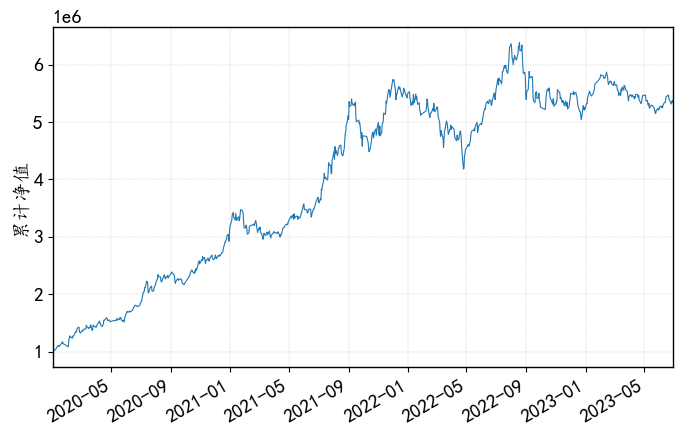

In [5]:
plt, fig, ax = post.matplot()
ax.plot(world0.series_net)
ax.set_ylabel('累计净值')
ax.set_xlim(world0.series_net.index[0], world0.series_net.index[-1])
plt.gcf().autofmt_xdate()

### 每日持仓数据

In [6]:
world0.dict_hold_amount

{Timestamp('2020-01-02 00:00:00'): code
 123031.SZ    100000.0
 113537.SH    100000.0
 123011.SZ    100000.0
 128079.SZ    100000.0
 113550.SH    100000.0
 113539.SH    100000.0
 123003.SZ    100000.0
 128074.SZ    100000.0
 113538.SH    100000.0
 113520.SH    100000.0
 dtype: float64,
 Timestamp('2020-01-03 00:00:00'): code
 128025.SZ    100057.820374
 113537.SH    100057.820374
 128079.SZ    100057.820374
 113539.SH    100057.820374
 113550.SH    100057.820374
 113548.SH    100057.820374
 128074.SZ    100057.820374
 123017.SZ    100057.820374
 128030.SZ    100057.820374
 123031.SZ    100057.820374
 dtype: float64,
 Timestamp('2020-01-06 00:00:00'): code
 113550.SH    102727.991366
 128074.SZ    102727.991366
 128079.SZ    102727.991366
 128020.SZ    102727.991366
 113538.SH    102727.991366
 128068.SZ    102727.991366
 123017.SZ    102727.991366
 113539.SH    102727.991366
 113548.SH    102727.991366
 123031.SZ    102727.991366
 dtype: float64,
 Timestamp('2020-01-07 00:00:00'): code

### 交割单

In [8]:
world0.df_excute

head,date,code,BuyOrSell,price,occurance_vol,occurance_amount,comm,remain_cash,stat,orderprice,ordervol
date,,,,,,,,,,,
0,2020-01-02,128079.SZ,Buy,127.555,783.975540,100000.000000,0.0,900000.000000,normal,close,783.975540
1,2020-01-02,113538.SH,Buy,147.750,676.818951,100000.000000,0.0,800000.000000,normal,close,676.818951
2,2020-01-02,128074.SZ,Buy,145.800,685.871056,100000.000000,0.0,700000.000000,normal,close,685.871056
3,2020-01-02,113537.SH,Buy,120.430,830.357884,100000.000000,0.0,600000.000000,normal,close,830.357884
4,2020-01-02,113550.SH,Buy,129.330,773.215805,100000.000000,0.0,500000.000000,normal,close,773.215805
...,...,...,...,...,...,...,...,...,...,...,...
18689,2023-06-29,113595.SH,Buy,108.564,29.520258,3204.837318,0.0,11613.916771,normal,close,29.520258
18690,2023-06-29,128081.SZ,Buy,126.730,15.687908,1988.128619,0.0,9625.788152,normal,close,15.687908
18691,2023-06-29,123136.SZ,Buy,106.760,53.842328,5748.206926,0.0,3877.581226,normal,close,53.842328


# 真实回测，按照第二日开盘价撮合成交

In [16]:
def init1(self):
    self.interval = 0
    
# 保持持有转股溢价率最低*只转债，仓位平均
intervals = 1
def strat1(self):
    if self.interval%intervals==0:
        market_ = self.cur_market
        # 低转股溢价率因子
        left = 0.95
        right = 1
        rank = (-market_['premium']).rank()
        factor = rank/rank.max()
        factor = factor[(factor<=right)&(factor>left)]
        basket_hold = list(factor.index)
        self.log("目标持有标的 %s %s"%(len(basket_hold), list(basket_hold)))
        position = self.cur_net/len(basket_hold)

        # 对于持仓， 不在新篮子中则卖出， 在篮子中的卖出至目标仓位
        for code in self.cur_hold_vol.index:
            # 略过缺失（）
            inmarket = True
            try:
                self.cur_market.loc[code]
            except:
                self.log_error('out of market %s'%code)
                inmarket = False
            if inmarket:
                # 卖出
                if code not in basket_hold:
                    # 不在低溢价率组卖出
                    self.log('调出标的 %s'%code)
                    self.sell(code, price='open')
                # 调整至目标仓位
                else:
                    hold_vol = self.cur_hold_vol[code]
                    buy_amount = position - hold_vol * self.cur_market['close'].loc[code]
                    buy_vol = buy_amount/self.cur_market['close'].loc[code]
                    if buy_vol > 0:
                        # 下期可交易才加仓
                        if not self.convertible_delist(code, intervals+1):
                            self.log('加仓 %s'%code)
                            self.buy(code, buy_vol, price='open')
                    else:
                        self.log('减仓 %s'%code)
                        self.sell(code, -buy_vol, price='open')
            # 如果下期无法交易则直接卖出
            if self.convertible_delist(code, intervals+1):
                self.log('调出标的 %s'%code)
                self.sell(code, price='open')
        # 篮子外的 并且下期可交易
        for code in basket_hold:
            if code not in self.cur_hold_vol.index:
                if not self.convertible_delist(code, intervals+1):
                    self.log('买入标的 %s'%code)
                    vol = position/self.cur_market['close'].loc[code]
                    self.buy(code, vol, price='open')
    self.interval += 1
                    
            
# 添加策略
barbybar.World.init = init1
barbybar.World.strategy = strat1
# 交易费用为0，限制每根bar成交为总成交量的999%
world0 = barbybar.World(market_convertible, comm=0, max_vol_perbar = 9.99)
world0.run()

2020-01-02 00:00:00 new bar
2020-01-02 00:00:00 excute yesterbar order
2020-01-02 00:00:00 run strategy
2020-01-02 00:00:00 目标持有标的 10 ['128079.SZ', '123011.SZ', '113538.SH', '113539.SH', '123031.SZ', '123003.SZ', '128074.SZ', '113520.SH', '113550.SH', '113537.SH']
2020-01-02 00:00:00 买入标的 128079.SZ
2020-01-02 00:00:00 买入标的 123011.SZ
2020-01-02 00:00:00 买入标的 113538.SH
2020-01-02 00:00:00 买入标的 113539.SH
2020-01-02 00:00:00 买入标的 123031.SZ
2020-01-02 00:00:00 买入标的 123003.SZ
2020-01-02 00:00:00 买入标的 128074.SZ
2020-01-02 00:00:00 买入标的 113520.SH
2020-01-02 00:00:00 买入标的 113550.SH
2020-01-02 00:00:00 买入标的 113537.SH
2020-01-02 00:00:00 end bar
2020-01-02 00:00:00 new bar
2020-01-03 00:00:00 excute yesterbar order
2020-01-03 00:00:00 run strategy
2020-01-03 00:00:00 目标持有标的 10 ['123017.SZ', '113548.SH', '128030.SZ', '113539.SH', '128079.SZ', '128074.SZ', '128025.SZ', '123031.SZ', '113537.SH', '113550.SH']
2020-01-03 00:00:00 减仓 113537.SH
2020-01-03 00:00:00 调出标的 123011.SZ
2020-01-03 00:00:00 加仓 1

2020-01-20 00:00:00 excute yesterbar order
2020-01-20 00:00:00 run strategy
2020-01-20 00:00:00 目标持有标的 11 ['113538.SH', '128079.SZ', '113548.SH', '113550.SH', '123031.SZ', '113522.SH', '128086.SZ', '128068.SZ', '123029.SZ', '113559.SH', '128074.SZ']
2020-01-20 00:00:00 加仓 113559.SH
2020-01-20 00:00:00 调出标的 113547.SH
2020-01-20 00:00:00 加仓 128079.SZ
2020-01-20 00:00:00 减仓 123029.SZ
2020-01-20 00:00:00 减仓 113548.SH
2020-01-20 00:00:00 加仓 113550.SH
2020-01-20 00:00:00 减仓 128086.SZ
2020-01-20 00:00:00 加仓 128074.SZ
2020-01-20 00:00:00 调出标的 128038.SZ
2020-01-20 00:00:00 加仓 123031.SZ
2020-01-20 00:00:00 调出标的 128043.SZ
2020-01-20 00:00:00 买入标的 113538.SH
2020-01-20 00:00:00 买入标的 113522.SH
2020-01-20 00:00:00 买入标的 128068.SZ
2020-01-20 00:00:00 end bar
2020-01-20 00:00:00 new bar
2020-01-21 00:00:00 excute yesterbar order
2020-01-21 00:00:00 run strategy
2020-01-21 00:00:00 目标持有标的 11 ['128086.SZ', '113522.SH', '123031.SZ', '128074.SZ', '128043.SZ', '123029.SZ', '113539.SH', '113548.SH', '113559.S

2020-02-11 00:00:00 run strategy
2020-02-11 00:00:00 目标持有标的 12 ['123029.SZ', '127004.SZ', '113550.SH', '128079.SZ', '128053.SZ', '113548.SH', '128090.SZ', '128086.SZ', '123009.SZ', '113555.SH', '128074.SZ', '123031.SZ']
2020-02-11 00:00:00 减仓 128079.SZ
2020-02-11 00:00:00 调出标的 113539.SH
2020-02-11 00:00:00 加仓 128090.SZ
2020-02-11 00:00:00 调出标的 113510.SH
2020-02-11 00:00:00 减仓 123029.SZ
2020-02-11 00:00:00 加仓 128053.SZ
2020-02-11 00:00:00 减仓 113550.SH
2020-02-11 00:00:00 加仓 113548.SH
2020-02-11 00:00:00 加仓 113555.SH
2020-02-11 00:00:00 减仓 123031.SZ
2020-02-11 00:00:00 加仓 128086.SZ
2020-02-11 00:00:00 调出标的 128043.SZ
2020-02-11 00:00:00 买入标的 127004.SZ
2020-02-11 00:00:00 买入标的 123009.SZ
2020-02-11 00:00:00 买入标的 128074.SZ
2020-02-11 00:00:00 end bar
2020-02-11 00:00:00 new bar
2020-02-12 00:00:00 excute yesterbar order
2020-02-12 00:00:00 run strategy
2020-02-12 00:00:00 目标持有标的 12 ['113555.SH', '113550.SH', '123031.SZ', '128086.SZ', '128090.SZ', '113548.SH', '113521.SH', '123029.SZ', '12300

2020-02-25 00:00:00 run strategy
2020-02-25 00:00:00 目标持有标的 12 ['128090.SZ', '128085.SZ', '128079.SZ', '128053.SZ', '123009.SZ', '123031.SZ', '113522.SH', '128086.SZ', '123029.SZ', '123038.SZ', '113548.SH', '113555.SH']
2020-02-25 00:00:00 加仓 128085.SZ
2020-02-25 00:00:00 减仓 128079.SZ
2020-02-25 00:00:00 调出标的 128039.SZ
2020-02-25 00:00:00 加仓 123038.SZ
2020-02-25 00:00:00 调出标的 110044.SH
2020-02-25 00:00:00 减仓 128090.SZ
2020-02-25 00:00:00 减仓 113555.SH
2020-02-25 00:00:00 减仓 128086.SZ
2020-02-25 00:00:00 加仓 113548.SH
2020-02-25 00:00:00 调出标的 113520.SH
2020-02-25 00:00:00 调出标的 113539.SH
2020-02-25 00:00:00 减仓 123031.SZ
2020-02-25 00:00:00 买入标的 128053.SZ
2020-02-25 00:00:00 买入标的 123009.SZ
2020-02-25 00:00:00 买入标的 113522.SH
2020-02-25 00:00:00 买入标的 123029.SZ
2020-02-25 00:00:00 end bar
2020-02-25 00:00:00 new bar
2020-02-26 00:00:00 excute yesterbar order
2020-02-26 00:00:00 run strategy
2020-02-26 00:00:00 目标持有标的 12 ['123038.SZ', '128038.SZ', '113555.SH', '128086.SZ', '113550.SH', '128079.

2020-03-10 00:00:00 excute yesterbar order
2020-03-10 00:00:00 run strategy
2020-03-10 00:00:00 目标持有标的 12 ['113550.SH', '128090.SZ', '123037.SZ', '113510.SH', '113555.SH', '123029.SZ', '128053.SZ', '123002.SZ', '113548.SH', '123009.SZ', '128079.SZ', '128086.SZ']
2020-03-10 00:00:00 调出标的 110054.SH
2020-03-10 00:00:00 调出标的 110046.SH
2020-03-10 00:00:00 减仓 123037.SZ
2020-03-10 00:00:00 减仓 128090.SZ
2020-03-10 00:00:00 减仓 113550.SH
2020-03-10 00:00:00 减仓 128079.SZ
2020-03-10 00:00:00 减仓 128086.SZ
2020-03-10 00:00:00 调出标的 127004.SZ
2020-03-10 00:00:00 减仓 113548.SH
2020-03-10 00:00:00 调出标的 123031.SZ
2020-03-10 00:00:00 加仓 113555.SH
2020-03-10 00:00:00 调出标的 128043.SZ
2020-03-10 00:00:00 买入标的 113510.SH
2020-03-10 00:00:00 买入标的 123029.SZ
2020-03-10 00:00:00 买入标的 128053.SZ
2020-03-10 00:00:00 买入标的 123002.SZ
2020-03-10 00:00:00 买入标的 123009.SZ
2020-03-10 00:00:00 end bar
2020-03-10 00:00:00 new bar
2020-03-11 00:00:00 excute yesterbar order
2020-03-11 00:00:00 run strategy
2020-03-11 00:00:00 目标持有

2020-03-24 00:00:00 excute yesterbar order
2020-03-24 00:00:00 run strategy
2020-03-24 00:00:00 目标持有标的 12 ['128016.SZ', '113555.SH', '128055.SZ', '113510.SH', '123037.SZ', '123029.SZ', '128086.SZ', '128079.SZ', '110050.SH', '123019.SZ', '110062.SH', '123034.SZ']
2020-03-24 00:00:00 减仓 123019.SZ
2020-03-24 00:00:00 调出标的 123019.SZ
2020-03-24 00:00:00 减仓 110050.SH
2020-03-24 00:00:00 减仓 128086.SZ
2020-03-24 00:00:00 减仓 110062.SH
2020-03-24 00:00:00 加仓 123037.SZ
2020-03-24 00:00:00 减仓 128079.SZ
2020-03-24 00:00:00 加仓 123034.SZ
2020-03-24 00:00:00 调出标的 123020.SZ
2020-03-24 00:00:00 加仓 113555.SH
2020-03-24 00:00:00 调出标的 128043.SZ
2020-03-24 00:00:00 买入标的 128016.SZ
2020-03-24 00:00:00 买入标的 128055.SZ
2020-03-24 00:00:00 买入标的 123029.SZ
2020-03-24 00:00:00 end bar
2020-03-24 00:00:00 new bar
2020-03-25 00:00:00 excute yesterbar order
2020-03-25 00:00:00 run strategy
2020-03-25 00:00:00 目标持有标的 12 ['123034.SZ', '113517.SH', '128016.SZ', '110062.SH', '123019.SZ', '110050.SH', '123029.SZ', '128086.S

2020-04-13 00:00:00 run strategy
2020-04-13 00:00:00 目标持有标的 12 ['128043.SZ', '113511.SH', '128087.SZ', '123018.SZ', '127015.SZ', '123029.SZ', '123020.SZ', '128086.SZ', '128079.SZ', '123034.SZ', '123021.SZ', '113555.SH']
2020-04-13 00:00:00 加仓 128087.SZ
2020-04-13 00:00:00 调出标的 128090.SZ
2020-04-13 00:00:00 加仓 123018.SZ
2020-04-13 00:00:00 加仓 128086.SZ
2020-04-13 00:00:00 加仓 123034.SZ
2020-04-13 00:00:00 加仓 113511.SH
2020-04-13 00:00:00 减仓 127015.SZ
2020-04-13 00:00:00 减仓 113555.SH
2020-04-13 00:00:00 减仓 123020.SZ
2020-04-13 00:00:00 加仓 128079.SZ
2020-04-13 00:00:00 减仓 123029.SZ
2020-04-13 00:00:00 买入标的 128043.SZ
2020-04-13 00:00:00 end bar
2020-04-13 00:00:00 new bar
2020-04-14 00:00:00 excute yesterbar order
2020-04-14 00:00:00 run strategy
2020-04-14 00:00:00 目标持有标的 12 ['113511.SH', '123018.SZ', '128090.SZ', '113555.SH', '127015.SZ', '123029.SZ', '128087.SZ', '128043.SZ', '123034.SZ', '128079.SZ', '123020.SZ', '128086.SZ']
2020-04-14 00:00:00 加仓 128087.SZ
2020-04-14 00:00:00 减仓 12303

2020-04-28 00:00:00 excute yesterbar order
2020-04-28 00:00:00 run strategy
2020-04-28 00:00:00 目标持有标的 12 ['127015.SZ', '128087.SZ', '128077.SZ', '113515.SH', '113571.SH', '128088.SZ', '113555.SH', '128086.SZ', '123029.SZ', '113511.SH', '113548.SH', '113531.SH']
2020-04-28 00:00:00 加仓 128087.SZ
2020-04-28 00:00:00 减仓 113515.SH
2020-04-28 00:00:00 调出标的 113509.SH
2020-04-28 00:00:00 减仓 113571.SH
2020-04-28 00:00:00 加仓 113531.SH
2020-04-28 00:00:00 调出标的 123018.SZ
2020-04-28 00:00:00 调出标的 128079.SZ
2020-04-28 00:00:00 减仓 128086.SZ
2020-04-28 00:00:00 减仓 127015.SZ
2020-04-28 00:00:00 减仓 113511.SH
2020-04-28 00:00:00 加仓 113555.SH
2020-04-28 00:00:00 减仓 123029.SZ
2020-04-28 00:00:00 买入标的 128077.SZ
2020-04-28 00:00:00 买入标的 128088.SZ
2020-04-28 00:00:00 买入标的 113548.SH
2020-04-28 00:00:00 end bar
2020-04-28 00:00:00 new bar
2020-04-29 00:00:00 excute yesterbar order
2020-04-29 00:00:00 run strategy
2020-04-29 00:00:00 目标持有标的 12 ['113511.SH', '113531.SH', '128086.SZ', '113555.SH', '113504.SH', '1

2020-05-18 00:00:00 目标持有标的 13 ['113531.SH', '113515.SH', '128088.SZ', '113548.SH', '113555.SH', '123018.SZ', '113565.SH', '123029.SZ', '123025.SZ', '127015.SZ', '128054.SZ', '128089.SZ', '128086.SZ']
2020-05-18 00:00:00 减仓 113531.SH
2020-05-18 00:00:00 调出标的 113509.SH
2020-05-18 00:00:00 加仓 113515.SH
2020-05-18 00:00:00 减仓 128054.SZ
2020-05-18 00:00:00 减仓 123018.SZ
2020-05-18 00:00:00 减仓 127015.SZ
2020-05-18 00:00:00 加仓 113548.SH
2020-05-18 00:00:00 调出标的 123034.SZ
2020-05-18 00:00:00 调出标的 113520.SH
2020-05-18 00:00:00 加仓 128088.SZ
2020-05-18 00:00:00 加仓 113555.SH
2020-05-18 00:00:00 减仓 128086.SZ
2020-05-18 00:00:00 减仓 123029.SZ
2020-05-18 00:00:00 买入标的 113565.SH
2020-05-18 00:00:00 买入标的 123025.SZ
2020-05-18 00:00:00 买入标的 128089.SZ
2020-05-18 00:00:00 end bar
2020-05-18 00:00:00 new bar
2020-05-19 00:00:00 excute yesterbar order
2020-05-19 00:00:00 run strategy
2020-05-19 00:00:00 目标持有标的 13 ['127015.SZ', '113515.SH', '123029.SZ', '113520.SH', '128054.SZ', '128086.SZ', '128089.SZ', '12808

2020-06-02 00:00:00 excute yesterbar order
2020-06-02 00:00:00 run strategy
2020-06-02 00:00:00 目标持有标的 13 ['123037.SZ', '113571.SH', '128086.SZ', '113565.SH', '123029.SZ', '113548.SH', '113521.SH', '113509.SH', '113551.SH', '113515.SH', '113520.SH', '127015.SZ', '113577.SH']
2020-06-02 00:00:00 加仓 113515.SH
2020-06-02 00:00:00 加仓 113565.SH
2020-06-02 00:00:00 减仓 113521.SH
2020-06-02 00:00:00 调出标的 128089.SZ
2020-06-02 00:00:00 加仓 113551.SH
2020-06-02 00:00:00 调出标的 128102.SZ
2020-06-02 00:00:00 加仓 113509.SH
2020-06-02 00:00:00 加仓 127015.SZ
2020-06-02 00:00:00 加仓 113571.SH
2020-06-02 00:00:00 加仓 123037.SZ
2020-06-02 00:00:00 调出标的 123020.SZ
2020-06-02 00:00:00 调出标的 113555.SH
2020-06-02 00:00:00 加仓 123029.SZ
2020-06-02 00:00:00 买入标的 128086.SZ
2020-06-02 00:00:00 买入标的 113548.SH
2020-06-02 00:00:00 买入标的 113520.SH
2020-06-02 00:00:00 买入标的 113577.SH
2020-06-02 00:00:00 end bar
2020-06-02 00:00:00 new bar
2020-06-03 00:00:00 excute yesterbar order
2020-06-03 00:00:00 run strategy
2020-06-03 00:0

2020-06-17 00:00:00 run strategy
2020-06-17 00:00:00 目标持有标的 13 ['128086.SZ', '113551.SH', '113565.SH', '113515.SH', '127015.SZ', '128088.SZ', '113554.SH', '128105.SZ', '113566.SH', '123037.SZ', '113577.SH', '113571.SH', '113581.SH']
2020-06-17 00:00:00 减仓 113566.SH
2020-06-17 00:00:00 加仓 113565.SH
2020-06-17 00:00:00 调出标的 128080.SZ
2020-06-17 00:00:00 加仓 113581.SH
2020-06-17 00:00:00 加仓 128105.SZ
2020-06-17 00:00:00 减仓 113577.SH
2020-06-17 00:00:00 加仓 127015.SZ
2020-06-17 00:00:00 调出标的 128077.SZ
2020-06-17 00:00:00 减仓 128088.SZ
2020-06-17 00:00:00 减仓 123037.SZ
2020-06-17 00:00:00 加仓 113571.SH
2020-06-17 00:00:00 加仓 128086.SZ
2020-06-17 00:00:00 调出标的 113555.SH
2020-06-17 00:00:00 买入标的 113551.SH
2020-06-17 00:00:00 买入标的 113554.SH
2020-06-17 00:00:00 end bar
2020-06-17 00:00:00 new bar
2020-06-18 00:00:00 excute yesterbar order
2020-06-18 00:00:00 run strategy
2020-06-18 00:00:00 目标持有标的 13 ['113566.SH', '123037.SZ', '113577.SH', '113555.SH', '113571.SH', '128088.SZ', '113565.SH', '127015.

2020-07-06 00:00:00 run strategy
2020-07-06 00:00:00 目标持有标的 14 ['113580.SH', '113554.SH', '128077.SZ', '113566.SH', '128074.SZ', '113551.SH', '128043.SZ', '113578.SH', '128106.SZ', '113581.SH', '128108.SZ', '123041.SZ', '113577.SH', '127015.SZ']
2020-07-06 00:00:00 加仓 113580.SH
2020-07-06 00:00:00 加仓 128106.SZ
2020-07-06 00:00:00 减仓 113578.SH
2020-07-06 00:00:00 调出标的 113031.SH
2020-07-06 00:00:00 加仓 128074.SZ
2020-07-06 00:00:00 加仓 113577.SH
2020-07-06 00:00:00 调出标的 113556.SH
2020-07-06 00:00:00 加仓 127015.SZ
2020-07-06 00:00:00 加仓 128108.SZ
2020-07-06 00:00:00 调出标的 113552.SH
2020-07-06 00:00:00 减仓 113581.SH
2020-07-06 00:00:00 加仓 113551.SH
2020-07-06 00:00:00 加仓 128043.SZ
2020-07-06 00:00:00 调出标的 128086.SZ
2020-07-06 00:00:00 买入标的 113554.SH
2020-07-06 00:00:00 买入标的 128077.SZ
2020-07-06 00:00:00 买入标的 113566.SH
2020-07-06 00:00:00 买入标的 123041.SZ
2020-07-06 00:00:00 end bar
2020-07-06 00:00:00 new bar
2020-07-07 00:00:00 excute yesterbar order
2020-07-07 00:00:00 run strategy
2020-07-07 0

2020-07-17 00:00:00 excute yesterbar order
2020-07-17 00:00:00 run strategy
2020-07-17 00:00:00 目标持有标的 14 ['113578.SH', '113565.SH', '113586.SH', '113558.SH', '113577.SH', '113552.SH', '123041.SZ', '113022.SH', '113581.SH', '113031.SH', '113575.SH', '113564.SH', '113566.SH', '128106.SZ']
2020-07-17 00:00:00 调出标的 128048.SZ
2020-07-17 00:00:00 减仓 113565.SH
2020-07-17 00:00:00 加仓 113566.SH
2020-07-17 00:00:00 减仓 113575.SH
2020-07-17 00:00:00 调出标的 128021.SZ
2020-07-17 00:00:00 减仓 128106.SZ
2020-07-17 00:00:00 加仓 113022.SH
2020-07-17 00:00:00 减仓 113577.SH
2020-07-17 00:00:00 加仓 113578.SH
2020-07-17 00:00:00 调出标的 113556.SH
2020-07-17 00:00:00 减仓 113581.SH
2020-07-17 00:00:00 加仓 123041.SZ
2020-07-17 00:00:00 减仓 113552.SH
2020-07-17 00:00:00 调出标的 123029.SZ
2020-07-17 00:00:00 买入标的 113586.SH
2020-07-17 00:00:00 买入标的 113558.SH
2020-07-17 00:00:00 买入标的 113031.SH
2020-07-17 00:00:00 买入标的 113564.SH
2020-07-17 00:00:00 end bar
2020-07-17 00:00:00 new bar
2020-07-20 00:00:00 excute yesterbar order
20

2020-07-31 00:00:00 excute yesterbar order
2020-07-31 00:00:00 run strategy
2020-07-31 00:00:00 目标持有标的 15 ['128059.SZ', '113586.SH', '113575.SH', '113547.SH', '128112.SZ', '113572.SH', '113577.SH', '113558.SH', '113565.SH', '128021.SZ', '128108.SZ', '110060.SH', '113585.SH', '113555.SH', '113581.SH']
2020-07-31 00:00:00 减仓 113585.SH
2020-07-31 00:00:00 减仓 113572.SH
2020-07-31 00:00:00 减仓 113565.SH
2020-07-31 00:00:00 调出标的 128084.SZ
2020-07-31 00:00:00 减仓 113558.SH
2020-07-31 00:00:00 减仓 113575.SH
2020-07-31 00:00:00 调出标的 128092.SZ
2020-07-31 00:00:00 减仓 110060.SH
2020-07-31 00:00:00 减仓 113547.SH
2020-07-31 00:00:00 减仓 128108.SZ
2020-07-31 00:00:00 调出标的 113521.SH
2020-07-31 00:00:00 减仓 113586.SH
2020-07-31 00:00:00 调出标的 123022.SZ
2020-07-31 00:00:00 减仓 113581.SH
2020-07-31 00:00:00 买入标的 128059.SZ
2020-07-31 00:00:00 买入标的 128112.SZ
2020-07-31 00:00:00 买入标的 113577.SH
2020-07-31 00:00:00 买入标的 128021.SZ
2020-07-31 00:00:00 买入标的 113555.SH
2020-07-31 00:00:00 end bar
2020-07-31 00:00:00 new b

2020-08-13 00:00:00 run strategy
2020-08-13 00:00:00 目标持有标的 15 ['113035.SH', '113581.SH', '113565.SH', '113571.SH', '128045.SZ', '128108.SZ', '113586.SH', '128059.SZ', '128115.SZ', '113550.SH', '123046.SZ', '113585.SH', '113575.SH', '123044.SZ', '128097.SZ']
2020-08-13 00:00:00 减仓 113565.SH
2020-08-13 00:00:00 加仓 113585.SH
2020-08-13 00:00:00 减仓 113575.SH
2020-08-13 00:00:00 减仓 128097.SZ
2020-08-13 00:00:00 调出标的 128084.SZ
2020-08-13 00:00:00 调出标的 113543.SH
2020-08-13 00:00:00 加仓 123046.SZ
2020-08-13 00:00:00 加仓 128108.SZ
2020-08-13 00:00:00 减仓 128115.SZ
2020-08-13 00:00:00 加仓 113035.SH
2020-08-13 00:00:00 加仓 113571.SH
2020-08-13 00:00:00 调出标的 128102.SZ
2020-08-13 00:00:00 加仓 113586.SH
2020-08-13 00:00:00 调出标的 113509.SH
2020-08-13 00:00:00 加仓 113581.SH
2020-08-13 00:00:00 买入标的 128045.SZ
2020-08-13 00:00:00 买入标的 113550.SH
2020-08-13 00:00:00 买入标的 123044.SZ
2020-08-13 00:00:00 end bar
2020-08-13 00:00:00 new bar
2020-08-14 00:00:00 excute yesterbar order
2020-08-14 00:00:00 run strategy
2

2020-08-27 00:00:00 run strategy
2020-08-27 00:00:00 目标持有标的 15 ['128108.SZ', '128097.SZ', '113581.SH', '113580.SH', '123051.SZ', '113586.SH', '113571.SH', '113035.SH', '113575.SH', '123046.SZ', '113587.SH', '123044.SZ', '113572.SH', '113518.SH', '113585.SH']
2020-08-27 00:00:00 加仓 113585.SH
2020-08-27 00:00:00 加仓 113580.SH
2020-08-27 00:00:00 减仓 128097.SZ
2020-08-27 00:00:00 加仓 113572.SH
2020-08-27 00:00:00 减仓 113575.SH
2020-08-27 00:00:00 减仓 123046.SZ
2020-08-27 00:00:00 调出标的 123026.SZ
2020-08-27 00:00:00 加仓 128108.SZ
2020-08-27 00:00:00 减仓 123044.SZ
2020-08-27 00:00:00 加仓 113587.SH
2020-08-27 00:00:00 减仓 113035.SH
2020-08-27 00:00:00 减仓 113586.SH
2020-08-27 00:00:00 调出标的 128115.SZ
2020-08-27 00:00:00 加仓 113571.SH
2020-08-27 00:00:00 加仓 113581.SH
2020-08-27 00:00:00 买入标的 123051.SZ
2020-08-27 00:00:00 end bar
2020-08-27 00:00:00 new bar
2020-08-28 00:00:00 excute yesterbar order
2020-08-28 00:00:00 run strategy
2020-08-28 00:00:00 目标持有标的 15 ['113581.SH', '113586.SH', '113580.SH', '1230

2020-09-10 00:00:00 run strategy
2020-09-10 00:00:00 目标持有标的 15 ['113592.SH', '123046.SZ', '113587.SH', '113572.SH', '128115.SZ', '113580.SH', '128104.SZ', '113585.SH', '123037.SZ', '113581.SH', '113571.SH', '113586.SH', '128102.SZ', '113575.SH', '123051.SZ']
2020-09-10 00:00:00 调出标的 123062.SZ
2020-09-10 00:00:00 调出标的 123048.SZ
2020-09-10 00:00:00 调出标的 128108.SZ
2020-09-10 00:00:00 减仓 113585.SH
2020-09-10 00:00:00 调出标的 113566.SH
2020-09-10 00:00:00 减仓 123051.SZ
2020-09-10 00:00:00 减仓 113575.SH
2020-09-10 00:00:00 调出标的 123050.SZ
2020-09-10 00:00:00 减仓 113580.SH
2020-09-10 00:00:00 减仓 123046.SZ
2020-09-10 00:00:00 减仓 128104.SZ
2020-09-10 00:00:00 加仓 128115.SZ
2020-09-10 00:00:00 加仓 113571.SH
2020-09-10 00:00:00 加仓 113586.SH
2020-09-10 00:00:00 减仓 113581.SH
2020-09-10 00:00:00 买入标的 113592.SH
2020-09-10 00:00:00 买入标的 113587.SH
2020-09-10 00:00:00 买入标的 113572.SH
2020-09-10 00:00:00 买入标的 128102.SZ
2020-09-10 00:00:00 end bar
2020-09-10 00:00:00 new bar
2020-09-11 00:00:00 excute yesterbar ord

2020-09-24 00:00:00 run strategy
2020-09-24 00:00:00 目标持有标的 15 ['113575.SH', '113586.SH', '113582.SH', '128115.SZ', '113585.SH', '113035.SH', '123051.SZ', '113599.SH', '113581.SH', '113576.SH', '123062.SZ', '128108.SZ', '123046.SZ', '113592.SH', '113580.SH']
2020-09-24 00:00:00 调出标的 123052.SZ
2020-09-24 00:00:00 加仓 123062.SZ
2020-09-24 00:00:00 加仓 123051.SZ
2020-09-24 00:00:00 加仓 113585.SH
2020-09-24 00:00:00 减仓 128108.SZ
2020-09-24 00:00:00 加仓 113575.SH
2020-09-24 00:00:00 加仓 113592.SH
2020-09-24 00:00:00 减仓 123046.SZ
2020-09-24 00:00:00 加仓 113576.SH
2020-09-24 00:00:00 减仓 113580.SH
2020-09-24 00:00:00 加仓 128115.SZ
2020-09-24 00:00:00 减仓 113035.SH
2020-09-24 00:00:00 加仓 113582.SH
2020-09-24 00:00:00 减仓 113586.SH
2020-09-24 00:00:00 加仓 113581.SH
2020-09-24 00:00:00 买入标的 113599.SH
2020-09-24 00:00:00 end bar
2020-09-24 00:00:00 new bar
2020-09-25 00:00:00 excute yesterbar order
2020-09-25 00:00:00 run strategy
2020-09-25 00:00:00 目标持有标的 15 ['123051.SZ', '113581.SH', '113577.SH', '123046

2020-10-16 00:00:00 run strategy
2020-10-16 00:00:00 目标持有标的 16 ['113580.SH', '113585.SH', '123052.SZ', '128108.SZ', '113582.SH', '113035.SH', '123051.SZ', '113592.SH', '123062.SZ', '113586.SH', '113576.SH', '123048.SZ', '123061.SZ', '123032.SZ', '113581.SH', '123045.SZ']
2020-10-16 00:00:00 减仓 123062.SZ
2020-10-16 00:00:00 减仓 123052.SZ
2020-10-16 00:00:00 减仓 113585.SH
2020-10-16 00:00:00 加仓 123045.SZ
2020-10-16 00:00:00 加仓 123051.SZ
2020-10-16 00:00:00 减仓 128108.SZ
2020-10-16 00:00:00 加仓 113576.SH
2020-10-16 00:00:00 减仓 123061.SZ
2020-10-16 00:00:00 减仓 113592.SH
2020-10-16 00:00:00 加仓 123048.SZ
2020-10-16 00:00:00 减仓 113580.SH
2020-10-16 00:00:00 减仓 123032.SZ
2020-10-16 00:00:00 加仓 113582.SH
2020-10-16 00:00:00 减仓 113035.SH
2020-10-16 00:00:00 减仓 113586.SH
2020-10-16 00:00:00 加仓 113581.SH
2020-10-16 00:00:00 end bar
2020-10-16 00:00:00 new bar
2020-10-19 00:00:00 excute yesterbar order
2020-10-19 00:00:00 run strategy
2020-10-19 00:00:00 目标持有标的 16 ['123051.SZ', '113592.SH', '128050.SZ'

2020-10-29 00:00:00 run strategy
2020-10-29 00:00:00 目标持有标的 16 ['113537.SH', '128029.SZ', '128115.SZ', '113592.SH', '113586.SH', '128108.SZ', '128065.SZ', '123026.SZ', '128058.SZ', '128112.SZ', '128075.SZ', '113585.SH', '113580.SH', '113581.SH', '113582.SH', '113035.SH']
2020-10-29 00:00:00 调出标的 128099.SZ
2020-10-29 00:00:00 调出标的 113025.SH
2020-10-29 00:00:00 调出标的 110058.SH
2020-10-29 00:00:00 减仓 128108.SZ
2020-10-29 00:00:00 减仓 113585.SH
2020-10-29 00:00:00 加仓 128065.SZ
2020-10-29 00:00:00 减仓 113592.SH
2020-10-29 00:00:00 调出标的 128095.SZ
2020-10-29 00:00:00 减仓 128058.SZ
2020-10-29 00:00:00 加仓 113580.SH
2020-10-29 00:00:00 加仓 113582.SH
2020-10-29 00:00:00 加仓 128112.SZ
2020-10-29 00:00:00 加仓 128115.SZ
2020-10-29 00:00:00 减仓 113035.SH
2020-10-29 00:00:00 加仓 113586.SH
2020-10-29 00:00:00 加仓 113581.SH
2020-10-29 00:00:00 买入标的 113537.SH
2020-10-29 00:00:00 买入标的 128029.SZ
2020-10-29 00:00:00 买入标的 123026.SZ
2020-10-29 00:00:00 买入标的 128075.SZ
2020-10-29 00:00:00 end bar
2020-10-29 00:00:00 new 

2020-11-10 00:00:00 run strategy
2020-11-10 00:00:00 目标持有标的 16 ['128112.SZ', '123055.SZ', '128111.SZ', '113035.SH', '123062.SZ', '123029.SZ', '113555.SH', '113585.SH', '113020.SH', '113582.SH', '123052.SZ', '123051.SZ', '113592.SH', '123047.SZ', '128115.SZ', '113586.SH']
2020-11-10 00:00:00 调出标的 128050.SZ
2020-11-10 00:00:00 调出标的 128108.SZ
2020-11-10 00:00:00 减仓 128111.SZ
2020-11-10 00:00:00 减仓 123051.SZ
2020-11-10 00:00:00 减仓 123047.SZ
2020-11-10 00:00:00 减仓 123052.SZ
2020-11-10 00:00:00 减仓 123055.SZ
2020-11-10 00:00:00 减仓 113585.SH
2020-11-10 00:00:00 加仓 123062.SZ
2020-11-10 00:00:00 调出标的 128065.SZ
2020-11-10 00:00:00 调出标的 123030.SZ
2020-11-10 00:00:00 加仓 113582.SH
2020-11-10 00:00:00 加仓 128112.SZ
2020-11-10 00:00:00 加仓 113586.SH
2020-11-10 00:00:00 加仓 128115.SZ
2020-11-10 00:00:00 加仓 113035.SH
2020-11-10 00:00:00 买入标的 123029.SZ
2020-11-10 00:00:00 买入标的 113555.SH
2020-11-10 00:00:00 买入标的 113020.SH
2020-11-10 00:00:00 买入标的 113592.SH
2020-11-10 00:00:00 end bar
2020-11-10 00:00:00 new 

2020-11-23 00:00:00 run strategy
2020-11-23 00:00:00 目标持有标的 16 ['128110.SZ', '113587.SH', '110055.SH', '113585.SH', '128112.SZ', '128128.SZ', '123055.SZ', '128111.SZ', '113582.SH', '113545.SH', '113035.SH', '113586.SH', '113034.SH', '123062.SZ', '113592.SH', '128115.SZ']
2020-11-23 00:00:00 减仓 113034.SH
2020-11-23 00:00:00 减仓 128111.SZ
2020-11-23 00:00:00 减仓 128110.SZ
2020-11-23 00:00:00 加仓 123055.SZ
2020-11-23 00:00:00 减仓 110055.SH
2020-11-23 00:00:00 加仓 113592.SH
2020-11-23 00:00:00 加仓 123062.SZ
2020-11-23 00:00:00 调出标的 113590.SH
2020-11-23 00:00:00 加仓 113585.SH
2020-11-23 00:00:00 加仓 113587.SH
2020-11-23 00:00:00 加仓 128112.SZ
2020-11-23 00:00:00 调出标的 113020.SH
2020-11-23 00:00:00 加仓 113582.SH
2020-11-23 00:00:00 减仓 113586.SH
2020-11-23 00:00:00 加仓 128115.SZ
2020-11-23 00:00:00 减仓 113035.SH
2020-11-23 00:00:00 买入标的 128128.SZ
2020-11-23 00:00:00 买入标的 113545.SH
2020-11-23 00:00:00 end bar
2020-11-23 00:00:00 new bar
2020-11-24 00:00:00 excute yesterbar order
2020-11-24 00:00:00 run str

2020-12-07 00:00:00 excute yesterbar order
2020-12-07 00:00:00 run strategy
2020-12-07 00:00:00 目标持有标的 16 ['123055.SZ', '113593.SH', '128119.SZ', '128111.SZ', '128029.SZ', '123074.SZ', '113587.SH', '113545.SH', '113585.SH', '128110.SZ', '113592.SH', '128112.SZ', '113586.SH', '113590.SH', '113565.SH', '128115.SZ']
2020-12-07 00:00:00 调出标的 113016.SH
2020-12-07 00:00:00 减仓 123074.SZ
2020-12-07 00:00:00 加仓 113593.SH
2020-12-07 00:00:00 减仓 113565.SH
2020-12-07 00:00:00 加仓 128111.SZ
2020-12-07 00:00:00 调出标的 113032.SH
2020-12-07 00:00:00 加仓 123055.SZ
2020-12-07 00:00:00 调出标的 123061.SZ
2020-12-07 00:00:00 加仓 113587.SH
2020-12-07 00:00:00 减仓 113592.SH
2020-12-07 00:00:00 加仓 113585.SH
2020-12-07 00:00:00 加仓 128112.SZ
2020-12-07 00:00:00 加仓 128110.SZ
2020-12-07 00:00:00 加仓 128115.SZ
2020-12-07 00:00:00 调出标的 113035.SH
2020-12-07 00:00:00 减仓 113586.SH
2020-12-07 00:00:00 买入标的 128119.SZ
2020-12-07 00:00:00 买入标的 128029.SZ
2020-12-07 00:00:00 买入标的 113545.SH
2020-12-07 00:00:00 买入标的 113590.SH
2020-12-0

2020-12-18 00:00:00 run strategy
2020-12-18 00:00:00 目标持有标的 16 ['128102.SZ', '128111.SZ', '128104.SZ', '128112.SZ', '113562.SH', '113575.SH', '113585.SH', '123074.SZ', '123055.SZ', '113587.SH', '110066.SH', '110055.SH', '113592.SH', '128115.SZ', '113590.SH', '113035.SH']
2020-12-18 00:00:00 调出标的 128108.SZ
2020-12-18 00:00:00 调出标的 128019.SZ
2020-12-18 00:00:00 调出标的 113032.SH
2020-12-18 00:00:00 加仓 123055.SZ
2020-12-18 00:00:00 调出标的 128119.SZ
2020-12-18 00:00:00 减仓 123074.SZ
2020-12-18 00:00:00 减仓 128111.SZ
2020-12-18 00:00:00 加仓 113587.SH
2020-12-18 00:00:00 加仓 113585.SH
2020-12-18 00:00:00 加仓 128112.SZ
2020-12-18 00:00:00 加仓 113592.SH
2020-12-18 00:00:00 调出标的 113580.SH
2020-12-18 00:00:00 调出标的 128095.SZ
2020-12-18 00:00:00 加仓 128115.SZ
2020-12-18 00:00:00 调出标的 128110.SZ
2020-12-18 00:00:00 减仓 113035.SH
2020-12-18 00:00:00 买入标的 128102.SZ
2020-12-18 00:00:00 买入标的 128104.SZ
2020-12-18 00:00:00 买入标的 113575.SH
2020-12-18 00:00:00 买入标的 110066.SH
2020-12-18 00:00:00 买入标的 110055.SH
2020-12-18 

2020-12-31 00:00:00 run strategy
2020-12-31 00:00:00 目标持有标的 17 ['113587.SH', '128126.SZ', '128112.SZ', '128110.SZ', '110066.SH', '113543.SH', '113586.SH', '128028.SZ', '128111.SZ', '113032.SH', '123055.SZ', '128115.SZ', '128010.SZ', '128104.SZ', '113509.SH', '128019.SZ', '113592.SH']
2020-12-31 00:00:00 调出标的 128104.SZ
2020-12-31 00:00:00 调出标的 113575.SH
2020-12-31 00:00:00 加仓 128010.SZ
2020-12-31 00:00:00 加仓 128019.SZ
2020-12-31 00:00:00 加仓 113032.SH
2020-12-31 00:00:00 调出标的 123022.SZ
2020-12-31 00:00:00 调出标的 113580.SH
2020-12-31 00:00:00 加仓 113587.SH
2020-12-31 00:00:00 加仓 123055.SZ
2020-12-31 00:00:00 加仓 113592.SH
2020-12-31 00:00:00 调出标的 113590.SH
2020-12-31 00:00:00 加仓 128126.SZ
2020-12-31 00:00:00 加仓 128111.SZ
2020-12-31 00:00:00 减仓 113543.SH
2020-12-31 00:00:00 调出标的 113520.SH
2020-12-31 00:00:00 加仓 128028.SZ
2020-12-31 00:00:00 加仓 113586.SH
2020-12-31 00:00:00 买入标的 128112.SZ
2020-12-31 00:00:00 买入标的 128110.SZ
2020-12-31 00:00:00 买入标的 110066.SH
2020-12-31 00:00:00 买入标的 128115.SZ
20

2021-01-13 00:00:00 run strategy
2021-01-13 00:00:00 目标持有标的 17 ['128115.SZ', '113592.SH', '113032.SH', '123017.SZ', '128126.SZ', '128112.SZ', '113556.SH', '128111.SZ', '113025.SH', '113008.SH', '128110.SZ', '128108.SZ', '123074.SZ', '113586.SH', '113585.SH', '113587.SH', '128128.SZ']
2021-01-13 00:00:00 减仓 113556.SH
2021-01-13 00:00:00 减仓 128108.SZ
2021-01-13 00:00:00 调出标的 123062.SZ
2021-01-13 00:00:00 调出标的 123055.SZ
2021-01-13 00:00:00 加仓 113025.SH
2021-01-13 00:00:00 减仓 113587.SH
2021-01-13 00:00:00 减仓 123074.SZ
2021-01-13 00:00:00 加仓 113592.SH
2021-01-13 00:00:00 加仓 123017.SZ
2021-01-13 00:00:00 调出标的 113038.SH
2021-01-13 00:00:00 加仓 128111.SZ
2021-01-13 00:00:00 加仓 128126.SZ
2021-01-13 00:00:00 减仓 128115.SZ
2021-01-13 00:00:00 调出标的 113035.SH
2021-01-13 00:00:00 调出标的 128028.SZ
2021-01-13 00:00:00 减仓 113586.SH
2021-01-13 00:00:00 买入标的 128112.SZ
2021-01-13 00:00:00 买入标的 113008.SH
2021-01-13 00:00:00 买入标的 128110.SZ
2021-01-13 00:00:00 买入标的 113585.SH
2021-01-13 00:00:00 买入标的 128128.SZ
20

2021-01-25 00:00:00 run strategy
2021-01-25 00:00:00 目标持有标的 18 ['113545.SH', '128128.SZ', '113029.SH', '113592.SH', '128010.SZ', '128108.SZ', '128112.SZ', '113035.SH', '128028.SZ', '123074.SZ', '128065.SZ', '113556.SH', '128115.SZ', '128111.SZ', '123055.SZ', '128126.SZ', '113038.SH', '113590.SH']
2021-01-25 00:00:00 减仓 128128.SZ
2021-01-25 00:00:00 调出标的 113585.SH
2021-01-25 00:00:00 减仓 128010.SZ
2021-01-25 00:00:00 加仓 123074.SZ
2021-01-25 00:00:00 减仓 128108.SZ
2021-01-25 00:00:00 减仓 113029.SH
2021-01-25 00:00:00 加仓 128112.SZ
2021-01-25 00:00:00 减仓 113592.SH
2021-01-25 00:00:00 加仓 113590.SH
2021-01-25 00:00:00 减仓 128111.SZ
2021-01-25 00:00:00 加仓 113038.SH
2021-01-25 00:00:00 减仓 128126.SZ
2021-01-25 00:00:00 减仓 128115.SZ
2021-01-25 00:00:00 减仓 113035.SH
2021-01-25 00:00:00 加仓 128065.SZ
2021-01-25 00:00:00 减仓 128028.SZ
2021-01-25 00:00:00 调出标的 128110.SZ
2021-01-25 00:00:00 买入标的 113545.SH
2021-01-25 00:00:00 买入标的 123055.SZ
2021-01-25 00:00:00 end bar
2021-01-25 00:00:00 new bar
2021-01-26 

2021-02-05 00:00:00 run strategy
2021-02-05 00:00:00 目标持有标的 18 ['128108.SZ', '113590.SH', '113509.SH', '128110.SZ', '110043.SH', '128094.SZ', '110066.SH', '128112.SZ', '113038.SH', '113577.SH', '128119.SZ', '113585.SH', '123017.SZ', '128103.SZ', '113587.SH', '113025.SH', '123055.SZ', '128010.SZ']
2021-02-05 00:00:00 减仓 128094.SZ
2021-02-05 00:00:00 加仓 113577.SH
2021-02-05 00:00:00 调出标的 113537.SH
2021-02-05 00:00:00 调出标的 128050.SZ
2021-02-05 00:00:00 减仓 123055.SZ
2021-02-05 00:00:00 减仓 113585.SH
2021-02-05 00:00:00 减仓 113587.SH
2021-02-05 00:00:00 加仓 128108.SZ
2021-02-05 00:00:00 加仓 128112.SZ
2021-02-05 00:00:00 加仓 110066.SH
2021-02-05 00:00:00 调出标的 128046.SZ
2021-02-05 00:00:00 加仓 123017.SZ
2021-02-05 00:00:00 减仓 113590.SH
2021-02-05 00:00:00 减仓 113038.SH
2021-02-05 00:00:00 调出标的 128065.SZ
2021-02-05 00:00:00 调出标的 113592.SH
2021-02-05 00:00:00 加仓 128110.SZ
2021-02-05 00:00:00 调出标的 128115.SZ
2021-02-05 00:00:00 买入标的 113509.SH
2021-02-05 00:00:00 买入标的 110043.SH
2021-02-05 00:00:00 买入标的 1

2021-02-25 00:00:00 run strategy
2021-02-25 00:00:00 目标持有标的 18 ['113016.SH', '128128.SZ', '113585.SH', '113577.SH', '113592.SH', '113038.SH', '128028.SZ', '123074.SZ', '110063.SH', '113583.SH', '113590.SH', '128094.SZ', '127008.SZ', '128050.SZ', '127023.SZ', '113508.SH', '128130.SZ', '128065.SZ']
2021-02-25 00:00:00 加仓 128128.SZ
2021-02-25 00:00:00 加仓 113016.SH
2021-02-25 00:00:00 减仓 128130.SZ
2021-02-25 00:00:00 调出标的 110047.SH
2021-02-25 00:00:00 加仓 123074.SZ
2021-02-25 00:00:00 减仓 110063.SH
2021-02-25 00:00:00 调出标的 113034.SH
2021-02-25 00:00:00 调出标的 128108.SZ
2021-02-25 00:00:00 减仓 113585.SH
2021-02-25 00:00:00 减仓 113508.SH
2021-02-25 00:00:00 减仓 127008.SZ
2021-02-25 00:00:00 调出标的 128112.SZ
2021-02-25 00:00:00 加仓 113590.SH
2021-02-25 00:00:00 减仓 113038.SH
2021-02-25 00:00:00 加仓 128065.SZ
2021-02-25 00:00:00 加仓 113592.SH
2021-02-25 00:00:00 加仓 128028.SZ
2021-02-25 00:00:00 买入标的 113577.SH
2021-02-25 00:00:00 买入标的 113583.SH
2021-02-25 00:00:00 买入标的 128094.SZ
2021-02-25 00:00:00 买入标的 128

2021-03-09 00:00:00 run strategy
2021-03-09 00:00:00 目标持有标的 17 ['127023.SZ', '113038.SH', '113029.SH', '128130.SZ', '128113.SZ', '110065.SH', '113541.SH', '113561.SH', '113585.SH', '128050.SZ', '128075.SZ', '128128.SZ', '128013.SZ', '128094.SZ', '113598.SH', '113016.SH', '113577.SH']
2021-03-09 00:00:00 减仓 128013.SZ
2021-03-09 00:00:00 调出标的 113039.SH
2021-03-09 00:00:00 调出标的 128051.SZ
2021-03-09 00:00:00 调出标的 123073.SZ
2021-03-09 00:00:00 减仓 128130.SZ
2021-03-09 00:00:00 加仓 128128.SZ
2021-03-09 00:00:00 减仓 128094.SZ
2021-03-09 00:00:00 减仓 127023.SZ
2021-03-09 00:00:00 调出标的 110048.SH
2021-03-09 00:00:00 调出标的 113034.SH
2021-03-09 00:00:00 减仓 113585.SH
2021-03-09 00:00:00 减仓 110065.SH
2021-03-09 00:00:00 加仓 113577.SH
2021-03-09 00:00:00 减仓 128050.SZ
2021-03-09 00:00:00 加仓 113029.SH
2021-03-09 00:00:00 调出标的 110066.SH
2021-03-09 00:00:00 加仓 113038.SH
2021-03-09 00:00:00 买入标的 128113.SZ
2021-03-09 00:00:00 买入标的 113541.SH
2021-03-09 00:00:00 买入标的 113561.SH
2021-03-09 00:00:00 买入标的 128075.SZ
20

2021-03-22 00:00:00 目标持有标的 17 ['110048.SH', '110069.SH', '128130.SZ', '113585.SH', '113557.SH', '123073.SZ', '128085.SZ', '113038.SH', '127023.SZ', '128141.SZ', '110065.SH', '113564.SH', '113577.SH', '113034.SH', '113039.SH', '128113.SZ', '123046.SZ']
2021-03-22 00:00:00 减仓 128085.SZ
2021-03-22 00:00:00 调出标的 128013.SZ
2021-03-22 00:00:00 减仓 113039.SH
2021-03-22 00:00:00 调出标的 128051.SZ
2021-03-22 00:00:00 调出标的 113541.SH
2021-03-22 00:00:00 减仓 128141.SZ
2021-03-22 00:00:00 调出标的 113598.SH
2021-03-22 00:00:00 加仓 110065.SH
2021-03-22 00:00:00 减仓 110069.SH
2021-03-22 00:00:00 加仓 128113.SZ
2021-03-22 00:00:00 加仓 113564.SH
2021-03-22 00:00:00 加仓 127023.SZ
2021-03-22 00:00:00 调出标的 113016.SH
2021-03-22 00:00:00 加仓 113038.SH
2021-03-22 00:00:00 加仓 123046.SZ
2021-03-22 00:00:00 调出标的 128095.SZ
2021-03-22 00:00:00 调出标的 113543.SH
2021-03-22 00:00:00 买入标的 110048.SH
2021-03-22 00:00:00 买入标的 128130.SZ
2021-03-22 00:00:00 买入标的 113585.SH
2021-03-22 00:00:00 买入标的 113557.SH
2021-03-22 00:00:00 买入标的 123073.S

2021-04-01 00:00:00 excute yesterbar order
2021-04-01 00:00:00 run strategy
2021-04-01 00:00:00 目标持有标的 18 ['113541.SH', '127023.SZ', '113016.SH', '113504.SH', '123073.SZ', '113557.SH', '110066.SH', '113039.SH', '110061.SH', '113585.SH', '123102.SZ', '128126.SZ', '113509.SH', '110048.SH', '128033.SZ', '123046.SZ', '123074.SZ', '110069.SH']
2021-04-01 00:00:00 减仓 123073.SZ
2021-04-01 00:00:00 加仓 113541.SH
2021-04-01 00:00:00 调出标的 110065.SH
2021-04-01 00:00:00 减仓 113585.SH
2021-04-01 00:00:00 调出标的 128050.SZ
2021-04-01 00:00:00 减仓 127023.SZ
2021-04-01 00:00:00 调出标的 123066.SZ
2021-04-01 00:00:00 加仓 110061.SH
2021-04-01 00:00:00 减仓 110069.SH
2021-04-01 00:00:00 减仓 110066.SH
2021-04-01 00:00:00 调出标的 113564.SH
2021-04-01 00:00:00 调出标的 128113.SZ
2021-04-01 00:00:00 加仓 113504.SH
2021-04-01 00:00:00 减仓 113016.SH
2021-04-01 00:00:00 加仓 128033.SZ
2021-04-01 00:00:00 调出标的 128097.SZ
2021-04-01 00:00:00 调出标的 128095.SZ
2021-04-01 00:00:00 减仓 113509.SH
2021-04-01 00:00:00 买入标的 113557.SH
2021-04-01 00:00

2021-04-13 00:00:00 run strategy
2021-04-13 00:00:00 目标持有标的 18 ['123102.SZ', '113543.SH', '123080.SZ', '113564.SH', '128126.SZ', '110066.SH', '110069.SH', '128095.SZ', '113577.SH', '113016.SH', '113034.SH', '113557.SH', '113025.SH', '113585.SH', '127023.SZ', '128113.SZ', '128013.SZ', '123052.SZ']
2021-04-13 00:00:00 调出标的 128082.SZ
2021-04-13 00:00:00 调出标的 128128.SZ
2021-04-13 00:00:00 调出标的 123073.SZ
2021-04-13 00:00:00 加仓 113564.SH
2021-04-13 00:00:00 调出标的 110070.SH
2021-04-13 00:00:00 减仓 113034.SH
2021-04-13 00:00:00 减仓 113585.SH
2021-04-13 00:00:00 减仓 110069.SH
2021-04-13 00:00:00 调出标的 128050.SZ
2021-04-13 00:00:00 调出标的 123066.SZ
2021-04-13 00:00:00 加仓 110066.SH
2021-04-13 00:00:00 调出标的 113504.SH
2021-04-13 00:00:00 加仓 127023.SZ
2021-04-13 00:00:00 减仓 128126.SZ
2021-04-13 00:00:00 调出标的 123046.SZ
2021-04-13 00:00:00 减仓 128095.SZ
2021-04-13 00:00:00 减仓 113016.SH
2021-04-13 00:00:00 加仓 113543.SH
2021-04-13 00:00:00 买入标的 123102.SZ
2021-04-13 00:00:00 买入标的 123080.SZ
2021-04-13 00:00:00 买入

2021-04-22 00:00:00 run strategy
2021-04-22 00:00:00 目标持有标的 18 ['127023.SZ', '128128.SZ', '123086.SZ', '113025.SH', '123029.SZ', '127028.SZ', '110065.SH', '128050.SZ', '123052.SZ', '113550.SH', '113585.SH', '113609.SH', '113541.SH', '113557.SH', '123073.SZ', '113564.SH', '110069.SH', '113598.SH']
2021-04-22 00:00:00 加仓 127028.SZ
2021-04-22 00:00:00 减仓 113609.SH
2021-04-22 00:00:00 减仓 128128.SZ
2021-04-22 00:00:00 加仓 123073.SZ
2021-04-22 00:00:00 加仓 113564.SH
2021-04-22 00:00:00 调出标的 113559.SH
2021-04-22 00:00:00 加仓 123052.SZ
2021-04-22 00:00:00 加仓 113598.SH
2021-04-22 00:00:00 调出标的 128113.SZ
2021-04-22 00:00:00 加仓 113585.SH
2021-04-22 00:00:00 加仓 128050.SZ
2021-04-22 00:00:00 减仓 127023.SZ
2021-04-22 00:00:00 调出标的 113537.SH
2021-04-22 00:00:00 调出标的 113504.SH
2021-04-22 00:00:00 调出标的 110055.SH
2021-04-22 00:00:00 加仓 113550.SH
2021-04-22 00:00:00 调出标的 128095.SZ
2021-04-22 00:00:00 调出标的 128111.SZ
2021-04-22 00:00:00 买入标的 123086.SZ
2021-04-22 00:00:00 买入标的 113025.SH
2021-04-22 00:00:00 买入标的

2021-05-07 00:00:00 excute yesterbar order
2021-05-07 00:00:00 run strategy
2021-05-07 00:00:00 目标持有标的 18 ['128128.SZ', '128095.SZ', '113041.SH', '110065.SH', '128081.SZ', '113609.SH', '128082.SZ', '113504.SH', '110070.SH', '113543.SH', '128106.SZ', '113598.SH', '113034.SH', '127029.SZ', '113025.SH', '128113.SZ', '127023.SZ', '128093.SZ']
2021-05-07 00:00:00 调出标的 123080.SZ
2021-05-07 00:00:00 调出标的 113541.SH
2021-05-07 00:00:00 减仓 128128.SZ
2021-05-07 00:00:00 减仓 128093.SZ
2021-05-07 00:00:00 调出标的 110048.SH
2021-05-07 00:00:00 减仓 110065.SH
2021-05-07 00:00:00 调出标的 128108.SZ
2021-05-07 00:00:00 调出标的 113537.SH
2021-05-07 00:00:00 减仓 113609.SH
2021-05-07 00:00:00 减仓 113034.SH
2021-05-07 00:00:00 加仓 113504.SH
2021-05-07 00:00:00 减仓 127023.SZ
2021-05-07 00:00:00 减仓 113025.SH
2021-05-07 00:00:00 调出标的 128126.SZ
2021-05-07 00:00:00 加仓 127029.SZ
2021-05-07 00:00:00 加仓 128095.SZ
2021-05-07 00:00:00 调出标的 123029.SZ
2021-05-07 00:00:00 买入标的 113041.SH
2021-05-07 00:00:00 买入标的 128081.SZ
2021-05-07 00:

2021-05-18 00:00:00 run strategy
2021-05-18 00:00:00 目标持有标的 19 ['113612.SH', '113585.SH', '113564.SH', '127029.SZ', '127023.SZ', '127028.SZ', '113609.SH', '113025.SH', '128093.SZ', '113034.SH', '128085.SZ', '113541.SH', '123029.SZ', '128113.SZ', '128128.SZ', '113543.SH', '128051.SZ', '113559.SH', '128095.SZ']
2021-05-18 00:00:00 减仓 128085.SZ
2021-05-18 00:00:00 调出标的 123080.SZ
2021-05-18 00:00:00 加仓 127028.SZ
2021-05-18 00:00:00 加仓 113541.SH
2021-05-18 00:00:00 减仓 113612.SH
2021-05-18 00:00:00 加仓 113609.SH
2021-05-18 00:00:00 加仓 128093.SZ
2021-05-18 00:00:00 减仓 128128.SZ
2021-05-18 00:00:00 加仓 113585.SH
2021-05-18 00:00:00 加仓 113559.SH
2021-05-18 00:00:00 减仓 128113.SZ
2021-05-18 00:00:00 加仓 127023.SZ
2021-05-18 00:00:00 加仓 113034.SH
2021-05-18 00:00:00 减仓 127029.SZ
2021-05-18 00:00:00 调出标的 113545.SH
2021-05-18 00:00:00 减仓 128095.SZ
2021-05-18 00:00:00 加仓 113543.SH
2021-05-18 00:00:00 减仓 123029.SZ
2021-05-18 00:00:00 买入标的 113025.SH
2021-05-18 00:00:00 买入标的 128051.SZ
2021-05-18 00:00:00 e

2021-05-31 00:00:00 run strategy
2021-05-31 00:00:00 目标持有标的 19 ['110065.SH', '113559.SH', '127029.SZ', '128085.SZ', '128095.SZ', '113041.SH', '113541.SH', '113545.SH', '123102.SZ', '123029.SZ', '113016.SH', '123094.SZ', '113609.SH', '123066.SZ', '128051.SZ', '128130.SZ', '113612.SH', '113585.SH', '128128.SZ']
2021-05-31 00:00:00 加仓 128085.SZ
2021-05-31 00:00:00 减仓 123102.SZ
2021-05-31 00:00:00 加仓 128130.SZ
2021-05-31 00:00:00 加仓 113609.SH
2021-05-31 00:00:00 加仓 128051.SZ
2021-05-31 00:00:00 调出标的 128082.SZ
2021-05-31 00:00:00 加仓 113612.SH
2021-05-31 00:00:00 加仓 113585.SH
2021-05-31 00:00:00 加仓 113541.SH
2021-05-31 00:00:00 调出标的 110074.SH
2021-05-31 00:00:00 加仓 123066.SZ
2021-05-31 00:00:00 加仓 128128.SZ
2021-05-31 00:00:00 减仓 123094.SZ
2021-05-31 00:00:00 减仓 113559.SH
2021-05-31 00:00:00 加仓 113041.SH
2021-05-31 00:00:00 加仓 127029.SZ
2021-05-31 00:00:00 减仓 128095.SZ
2021-05-31 00:00:00 加仓 113016.SH
2021-05-31 00:00:00 加仓 123029.SZ
2021-05-31 00:00:00 买入标的 110065.SH
2021-05-31 00:00:00 买入标

2021-06-09 00:00:00 run strategy
2021-06-09 00:00:00 目标持有标的 19 ['113534.SH', '128051.SZ', '113541.SH', '113016.SH', '113509.SH', '128113.SZ', '123066.SZ', '113041.SH', '128032.SZ', '123058.SZ', '113559.SH', '113508.SH', '127029.SZ', '123089.SZ', '110065.SH', '110074.SH', '113550.SH', '123102.SZ', '113609.SH']
2021-06-09 00:00:00 减仓 128051.SZ
2021-06-09 00:00:00 减仓 113609.SH
2021-06-09 00:00:00 减仓 123102.SZ
2021-06-09 00:00:00 减仓 123089.SZ
2021-06-09 00:00:00 加仓 113534.SH
2021-06-09 00:00:00 减仓 110065.SH
2021-06-09 00:00:00 减仓 113541.SH
2021-06-09 00:00:00 减仓 128032.SZ
2021-06-09 00:00:00 调出标的 128128.SZ
2021-06-09 00:00:00 减仓 123066.SZ
2021-06-09 00:00:00 调出标的 128094.SZ
2021-06-09 00:00:00 减仓 127029.SZ
2021-06-09 00:00:00 减仓 123058.SZ
2021-06-09 00:00:00 减仓 113041.SH
2021-06-09 00:00:00 减仓 113559.SH
2021-06-09 00:00:00 调出标的 113545.SH
2021-06-09 00:00:00 调出标的 110055.SH
2021-06-09 00:00:00 调出标的 113543.SH
2021-06-09 00:00:00 减仓 113016.SH
2021-06-09 00:00:00 买入标的 113509.SH
2021-06-09 00:00:

2021-06-22 00:00:00 run strategy
2021-06-22 00:00:00 目标持有标的 19 ['123089.SZ', '113039.SH', '123054.SZ', '127029.SZ', '128051.SZ', '128032.SZ', '110048.SH', '123063.SZ', '128094.SZ', '123110.SZ', '110065.SH', '113534.SH', '113041.SH', '113611.SH', '123094.SZ', '113559.SH', '128057.SZ', '123102.SZ', '123058.SZ']
2021-06-22 00:00:00 减仓 123102.SZ
2021-06-22 00:00:00 加仓 128057.SZ
2021-06-22 00:00:00 调出标的 128093.SZ
2021-06-22 00:00:00 调出标的 123052.SZ
2021-06-22 00:00:00 调出标的 127023.SZ
2021-06-22 00:00:00 减仓 110048.SH
2021-06-22 00:00:00 调出标的 113621.SH
2021-06-22 00:00:00 调出标的 113504.SH
2021-06-22 00:00:00 调出标的 113040.SH
2021-06-22 00:00:00 减仓 123058.SZ
2021-06-22 00:00:00 加仓 127029.SZ
2021-06-22 00:00:00 加仓 123054.SZ
2021-06-22 00:00:00 加仓 113559.SH
2021-06-22 00:00:00 减仓 113534.SH
2021-06-22 00:00:00 调出标的 110055.SH
2021-06-22 00:00:00 调出标的 113527.SH
2021-06-22 00:00:00 调出标的 123046.SZ
2021-06-22 00:00:00 调出标的 113016.SH
2021-06-22 00:00:00 调出标的 123029.SZ
2021-06-22 00:00:00 买入标的 123089.SZ
2021-

2021-07-01 00:00:00 run strategy
2021-07-01 00:00:00 目标持有标的 19 ['123094.SZ', '123031.SZ', '113543.SH', '113550.SH', '127029.SZ', '128128.SZ', '123058.SZ', '123102.SZ', '128051.SZ', '113527.SH', '113508.SH', '128032.SZ', '113611.SH', '110065.SH', '128134.SZ', '113545.SH', '113534.SH', '113040.SH', '113034.SH']
2021-07-01 00:00:00 减仓 128051.SZ
2021-07-01 00:00:00 调出标的 123052.SZ
2021-07-01 00:00:00 调出标的 127023.SZ
2021-07-01 00:00:00 调出标的 128093.SZ
2021-07-01 00:00:00 调出标的 128026.SZ
2021-07-01 00:00:00 调出标的 113585.SH
2021-07-01 00:00:00 调出标的 128046.SZ
2021-07-01 00:00:00 减仓 113040.SH
2021-07-01 00:00:00 调出标的 113621.SH
2021-07-01 00:00:00 加仓 123102.SZ
2021-07-01 00:00:00 加仓 127029.SZ
2021-07-01 00:00:00 加仓 123058.SZ
2021-07-01 00:00:00 加仓 128128.SZ
2021-07-01 00:00:00 加仓 128032.SZ
2021-07-01 00:00:00 加仓 123094.SZ
2021-07-01 00:00:00 加仓 113534.SH
2021-07-01 00:00:00 加仓 113527.SH
2021-07-01 00:00:00 减仓 123031.SZ
2021-07-01 00:00:00 买入标的 113543.SH
2021-07-01 00:00:00 买入标的 113550.SH
2021-07-01 

2021-07-12 00:00:00 run strategy
2021-07-12 00:00:00 目标持有标的 19 ['127023.SZ', '128093.SZ', '113527.SH', '113508.SH', '128032.SZ', '128064.SZ', '123089.SZ', '128051.SZ', '113534.SH', '113568.SH', '123102.SZ', '127029.SZ', '110066.SH', '123069.SZ', '113611.SH', '123094.SZ', '123007.SZ', '113621.SH', '113040.SH']
2021-07-12 00:00:00 调出标的 113609.SH
2021-07-12 00:00:00 减仓 113568.SH
2021-07-12 00:00:00 减仓 123089.SZ
2021-07-12 00:00:00 加仓 127023.SZ
2021-07-12 00:00:00 减仓 113040.SH
2021-07-12 00:00:00 减仓 128064.SZ
2021-07-12 00:00:00 减仓 128093.SZ
2021-07-12 00:00:00 加仓 127029.SZ
2021-07-12 00:00:00 加仓 128051.SZ
2021-07-12 00:00:00 调出标的 113615.SH
2021-07-12 00:00:00 调出标的 128128.SZ
2021-07-12 00:00:00 调出标的 123110.SZ
2021-07-12 00:00:00 加仓 110066.SH
2021-07-12 00:00:00 加仓 123102.SZ
2021-07-12 00:00:00 减仓 123007.SZ
2021-07-12 00:00:00 加仓 113611.SH
2021-07-12 00:00:00 减仓 123094.SZ
2021-07-12 00:00:00 加仓 113527.SH
2021-07-12 00:00:00 买入标的 113508.SH
2021-07-12 00:00:00 买入标的 128032.SZ
2021-07-12 00:00:

2021-07-22 00:00:00 excute yesterbar order
2021-07-22 00:00:00 run strategy
2021-07-22 00:00:00 目标持有标的 19 ['128032.SZ', '123071.SZ', '128128.SZ', '127029.SZ', '128064.SZ', '113585.SH', '128051.SZ', '123102.SZ', '123007.SZ', '123094.SZ', '128094.SZ', '113611.SH', '113040.SH', '123079.SZ', '113508.SH', '123050.SZ', '123089.SZ', '123069.SZ', '123098.SZ']
2021-07-22 00:00:00 调出标的 113568.SH
2021-07-22 00:00:00 加仓 128094.SZ
2021-07-22 00:00:00 调出标的 128026.SZ
2021-07-22 00:00:00 加仓 113508.SH
2021-07-22 00:00:00 加仓 113040.SH
2021-07-22 00:00:00 减仓 128064.SZ
2021-07-22 00:00:00 调出标的 128082.SZ
2021-07-22 00:00:00 减仓 128051.SZ
2021-07-22 00:00:00 调出标的 113621.SH
2021-07-22 00:00:00 加仓 127029.SZ
2021-07-22 00:00:00 调出标的 128093.SZ
2021-07-22 00:00:00 减仓 123079.SZ
2021-07-22 00:00:00 加仓 123069.SZ
2021-07-22 00:00:00 调出标的 123074.SZ
2021-07-22 00:00:00 减仓 123102.SZ
2021-07-22 00:00:00 加仓 128032.SZ
2021-07-22 00:00:00 减仓 113611.SH
2021-07-22 00:00:00 加仓 123007.SZ
2021-07-22 00:00:00 加仓 123094.SZ
2021-07

2021-08-02 00:00:00 run strategy
2021-08-02 00:00:00 目标持有标的 19 ['123031.SZ', '128094.SZ', '128064.SZ', '127029.SZ', '123098.SZ', '123033.SZ', '123094.SZ', '113040.SH', '113508.SH', '123079.SZ', '123050.SZ', '123070.SZ', '113568.SH', '123080.SZ', '113621.SH', '128051.SZ', '128050.SZ', '123102.SZ', '123074.SZ']
2021-08-02 00:00:00 调出标的 128085.SZ
2021-08-02 00:00:00 减仓 113508.SH
2021-08-02 00:00:00 加仓 128064.SZ
2021-08-02 00:00:00 加仓 123098.SZ
2021-08-02 00:00:00 调出标的 128082.SZ
2021-08-02 00:00:00 加仓 123050.SZ
2021-08-02 00:00:00 加仓 127029.SZ
2021-08-02 00:00:00 调出标的 113585.SH
2021-08-02 00:00:00 加仓 123033.SZ
2021-08-02 00:00:00 减仓 128051.SZ
2021-08-02 00:00:00 减仓 123070.SZ
2021-08-02 00:00:00 加仓 123102.SZ
2021-08-02 00:00:00 调出标的 123066.SZ
2021-08-02 00:00:00 加仓 123079.SZ
2021-08-02 00:00:00 加仓 113621.SH
2021-08-02 00:00:00 调出标的 113534.SH
2021-08-02 00:00:00 调出标的 110074.SH
2021-08-02 00:00:00 调出标的 123067.SZ
2021-08-02 00:00:00 买入标的 123031.SZ
2021-08-02 00:00:00 买入标的 128094.SZ
2021-08-02 

2021-08-11 00:00:00 run strategy
2021-08-11 00:00:00 目标持有标的 19 ['127029.SZ', '113508.SH', '113014.SH', '123098.SZ', '128085.SZ', '123084.SZ', '123007.SZ', '128064.SZ', '128051.SZ', '113585.SH', '123067.SZ', '123089.SZ', '123102.SZ', '113012.SH', '123052.SZ', '113610.SH', '113509.SH', '123066.SZ', '123079.SZ']
2021-08-11 00:00:00 加仓 113508.SH
2021-08-11 00:00:00 减仓 128085.SZ
2021-08-11 00:00:00 加仓 128064.SZ
2021-08-11 00:00:00 调出标的 123080.SZ
2021-08-11 00:00:00 减仓 113014.SH
2021-08-11 00:00:00 减仓 113610.SH
2021-08-11 00:00:00 加仓 123098.SZ
2021-08-11 00:00:00 减仓 127029.SZ
2021-08-11 00:00:00 减仓 123089.SZ
2021-08-11 00:00:00 加仓 113585.SH
2021-08-11 00:00:00 调出标的 123033.SZ
2021-08-11 00:00:00 减仓 123102.SZ
2021-08-11 00:00:00 加仓 128051.SZ
2021-08-11 00:00:00 调出标的 113528.SH
2021-08-11 00:00:00 减仓 123007.SZ
2021-08-11 00:00:00 调出标的 123007.SZ
2021-08-11 00:00:00 加仓 123066.SZ
2021-08-11 00:00:00 调出标的 123042.SZ
2021-08-11 00:00:00 加仓 123079.SZ
2021-08-11 00:00:00 加仓 113509.SH
2021-08-11 00:00:00

2021-08-20 00:00:00 run strategy
2021-08-20 00:00:00 目标持有标的 19 ['128064.SZ', '113048.SH', '128082.SZ', '123098.SZ', '123033.SZ', '123084.SZ', '123052.SZ', '113508.SH', '113585.SH', '127029.SZ', '128051.SZ', '123042.SZ', '113528.SH', '128050.SZ', '123079.SZ', '123102.SZ', '113012.SH', '123094.SZ', '113612.SH']
2021-08-20 00:00:00 加仓 113508.SH
2021-08-20 00:00:00 减仓 113012.SH
2021-08-20 00:00:00 加仓 113048.SH
2021-08-20 00:00:00 减仓 113612.SH
2021-08-20 00:00:00 加仓 123098.SZ
2021-08-20 00:00:00 调出标的 123086.SZ
2021-08-20 00:00:00 调出标的 123085.SZ
2021-08-20 00:00:00 调出标的 128085.SZ
2021-08-20 00:00:00 加仓 113585.SH
2021-08-20 00:00:00 加仓 128064.SZ
2021-08-20 00:00:00 加仓 127029.SZ
2021-08-20 00:00:00 加仓 113528.SH
2021-08-20 00:00:00 减仓 128051.SZ
2021-08-20 00:00:00 加仓 123102.SZ
2021-08-20 00:00:00 减仓 128050.SZ
2021-08-20 00:00:00 减仓 123079.SZ
2021-08-20 00:00:00 加仓 123094.SZ
2021-08-20 00:00:00 调出标的 113034.SH
2021-08-20 00:00:00 调出标的 123067.SZ
2021-08-20 00:00:00 买入标的 128082.SZ
2021-08-20 00:00:

2021-09-01 00:00:00 run strategy
2021-09-01 00:00:00 目标持有标的 19 ['113612.SH', '113525.SH', '113027.SH', '123094.SZ', '113012.SH', '113572.SH', '123068.SZ', '123069.SZ', '113607.SH', '127018.SZ', '127029.SZ', '128051.SZ', '123102.SZ', '113014.SH', '110033.SH', '123030.SZ', '113016.SH', '113048.SH', '128085.SZ']
2021-09-01 00:00:00 减仓 127018.SZ
2021-09-01 00:00:00 减仓 110033.SH
2021-09-01 00:00:00 调出标的 127020.SZ
2021-09-01 00:00:00 减仓 113014.SH
2021-09-01 00:00:00 减仓 123068.SZ
2021-09-01 00:00:00 调出标的 113039.SH
2021-09-01 00:00:00 调出标的 113012.SH
2021-09-01 00:00:00 加仓 128085.SZ
2021-09-01 00:00:00 加仓 113048.SH
2021-09-01 00:00:00 加仓 113612.SH
2021-09-01 00:00:00 加仓 113572.SH
2021-09-01 00:00:00 减仓 127029.SZ
2021-09-01 00:00:00 调出标的 128103.SZ
2021-09-01 00:00:00 加仓 128051.SZ
2021-09-01 00:00:00 加仓 123030.SZ
2021-09-01 00:00:00 减仓 123094.SZ
2021-09-01 00:00:00 调出标的 123079.SZ
2021-09-01 00:00:00 加仓 123102.SZ
2021-09-01 00:00:00 买入标的 113525.SH
2021-09-01 00:00:00 买入标的 113027.SH
2021-09-01 00:0

2021-09-14 00:00:00 run strategy
2021-09-14 00:00:00 目标持有标的 19 ['128113.SZ', '127030.SZ', '127029.SZ', '127040.SZ', '127018.SZ', '123102.SZ', '113607.SH', '113615.SH', '123030.SZ', '113014.SH', '128103.SZ', '110041.SH', '127020.SZ', '113572.SH', '113525.SH', '128085.SZ', '113549.SH', '110033.SH', '113039.SH']
2021-09-14 00:00:00 减仓 113607.SH
2021-09-14 00:00:00 减仓 113014.SH
2021-09-14 00:00:00 加仓 127018.SZ
2021-09-14 00:00:00 加仓 110033.SH
2021-09-14 00:00:00 加仓 127020.SZ
2021-09-14 00:00:00 调出标的 123068.SZ
2021-09-14 00:00:00 加仓 113039.SH
2021-09-14 00:00:00 减仓 127040.SZ
2021-09-14 00:00:00 加仓 128085.SZ
2021-09-14 00:00:00 加仓 113572.SH
2021-09-14 00:00:00 加仓 127029.SZ
2021-09-14 00:00:00 减仓 128113.SZ
2021-09-14 00:00:00 加仓 128103.SZ
2021-09-14 00:00:00 调出标的 113528.SH
2021-09-14 00:00:00 减仓 113615.SH
2021-09-14 00:00:00 减仓 113525.SH
2021-09-14 00:00:00 加仓 127030.SZ
2021-09-14 00:00:00 减仓 123102.SZ
2021-09-14 00:00:00 调出标的 123067.SZ
2021-09-14 00:00:00 买入标的 110041.SH
2021-09-14 00:00:00 买

2021-09-27 00:00:00 run strategy
2021-09-27 00:00:00 目标持有标的 19 ['128050.SZ', '113549.SH', '127029.SZ', '128085.SZ', '113528.SH', '110033.SH', '110048.SH', '128111.SZ', '113048.SH', '110077.SH', '123102.SZ', '127043.SZ', '123028.SZ', '113607.SH', '110074.SH', '110041.SH', '113525.SH', '113039.SH', '113568.SH']
2021-09-27 00:00:00 加仓 110033.SH
2021-09-27 00:00:00 减仓 113607.SH
2021-09-27 00:00:00 调出标的 128141.SZ
2021-09-27 00:00:00 加仓 113549.SH
2021-09-27 00:00:00 调出标的 113014.SH
2021-09-27 00:00:00 调出标的 113014.SH
2021-09-27 00:00:00 调出标的 113051.SH
2021-09-27 00:00:00 加仓 127029.SZ
2021-09-27 00:00:00 调出标的 118000.SH
2021-09-27 00:00:00 加仓 113039.SH
2021-09-27 00:00:00 加仓 113048.SH
2021-09-27 00:00:00 加仓 127043.SZ
2021-09-27 00:00:00 加仓 110041.SH
2021-09-27 00:00:00 减仓 123028.SZ
2021-09-27 00:00:00 加仓 128050.SZ
2021-09-27 00:00:00 加仓 110074.SH
2021-09-27 00:00:00 减仓 113528.SH
2021-09-27 00:00:00 加仓 113525.SH
2021-09-27 00:00:00 减仓 123102.SZ
2021-09-27 00:00:00 调出标的 123067.SZ
2021-09-27 00:00:

2021-10-13 00:00:00 run strategy
2021-10-13 00:00:00 目标持有标的 19 ['123067.SZ', '128082.SZ', '110033.SH', '113585.SH', '123051.SZ', '113525.SH', '123069.SZ', '118000.SH', '113051.SH', '123047.SZ', '127027.SZ', '113504.SH', '128085.SZ', '113039.SH', '123103.SZ', '110074.SH', '128128.SZ', '110041.SH', '113048.SH']
2021-10-13 00:00:00 减仓 110033.SH
2021-10-13 00:00:00 调出标的 123051.SZ
2021-10-13 00:00:00 加仓 127027.SZ
2021-10-13 00:00:00 调出标的 113600.SH
2021-10-13 00:00:00 减仓 113048.SH
2021-10-13 00:00:00 调出标的 123086.SZ
2021-10-13 00:00:00 减仓 128082.SZ
2021-10-13 00:00:00 调出标的 128096.SZ
2021-10-13 00:00:00 调出标的 123083.SZ
2021-10-13 00:00:00 减仓 113504.SH
2021-10-13 00:00:00 加仓 113051.SH
2021-10-13 00:00:00 调出标的 113568.SH
2021-10-13 00:00:00 加仓 113039.SH
2021-10-13 00:00:00 加仓 110041.SH
2021-10-13 00:00:00 加仓 110074.SH
2021-10-13 00:00:00 加仓 128128.SZ
2021-10-13 00:00:00 调出标的 123102.SZ
2021-10-13 00:00:00 调出标的 113528.SH
2021-10-13 00:00:00 减仓 123067.SZ
2021-10-13 00:00:00 买入标的 113585.SH
2021-10-13 

2021-10-25 00:00:00 run strategy
2021-10-25 00:00:00 目标持有标的 19 ['113591.SH', '123102.SZ', '113039.SH', '110041.SH', '110048.SH', '110033.SH', '123111.SZ', '113048.SH', '128057.SZ', '127042.SZ', '123067.SZ', '123083.SZ', '123069.SZ', '113504.SH', '113051.SH', '128085.SZ', '127043.SZ', '113009.SH', '113600.SH']
2021-10-25 00:00:00 加仓 110033.SH
2021-10-25 00:00:00 调出标的 113607.SH
2021-10-25 00:00:00 减仓 113591.SH
2021-10-25 00:00:00 减仓 128085.SZ
2021-10-25 00:00:00 加仓 123111.SZ
2021-10-25 00:00:00 减仓 113600.SH
2021-10-25 00:00:00 减仓 113048.SH
2021-10-25 00:00:00 减仓 113051.SH
2021-10-25 00:00:00 加仓 110041.SH
2021-10-25 00:00:00 调出标的 128082.SZ
2021-10-25 00:00:00 加仓 113504.SH
2021-10-25 00:00:00 减仓 123083.SZ
2021-10-25 00:00:00 减仓 127043.SZ
2021-10-25 00:00:00 调出标的 118000.SH
2021-10-25 00:00:00 调出标的 128128.SZ
2021-10-25 00:00:00 减仓 123069.SZ
2021-10-25 00:00:00 调出标的 113528.SH
2021-10-25 00:00:00 加仓 123102.SZ
2021-10-25 00:00:00 减仓 123067.SZ
2021-10-25 00:00:00 买入标的 113039.SH
2021-10-25 00:00:

2021-11-03 00:00:00 run strategy
2021-11-03 00:00:00 目标持有标的 19 ['123102.SZ', '123069.SZ', '110048.SH', '123067.SZ', '110041.SH', '113039.SH', '113504.SH', '128050.SZ', '128128.SZ', '113603.SH', '113051.SH', '128085.SZ', '128082.SZ', '128096.SZ', '113048.SH', '128057.SZ', '123083.SZ', '110033.SH', '110066.SH']
2021-11-03 00:00:00 减仓 128085.SZ
2021-11-03 00:00:00 调出标的 123111.SZ
2021-11-03 00:00:00 减仓 128057.SZ
2021-11-03 00:00:00 调出标的 110041.SH
2021-11-03 00:00:00 减仓 128082.SZ
2021-11-03 00:00:00 加仓 113048.SH
2021-11-03 00:00:00 减仓 128096.SZ
2021-11-03 00:00:00 加仓 113051.SH
2021-11-03 00:00:00 减仓 113504.SH
2021-11-03 00:00:00 减仓 128128.SZ
2021-11-03 00:00:00 调出标的 127043.SZ
2021-11-03 00:00:00 加仓 113039.SH
2021-11-03 00:00:00 减仓 113603.SH
2021-11-03 00:00:00 加仓 123069.SZ
2021-11-03 00:00:00 加仓 123083.SZ
2021-11-03 00:00:00 调出标的 123084.SZ
2021-11-03 00:00:00 加仓 123102.SZ
2021-11-03 00:00:00 减仓 128050.SZ
2021-11-03 00:00:00 加仓 123067.SZ
2021-11-03 00:00:00 买入标的 110048.SH
2021-11-03 00:00:00

2021-11-16 00:00:00 run strategy
2021-11-16 00:00:00 目标持有标的 19 ['128096.SZ', '123070.SZ', '123102.SZ', '123028.SZ', '113528.SH', '128013.SZ', '113614.SH', '128057.SZ', '110051.SH', '123086.SZ', '123067.SZ', '123081.SZ', '113580.SH', '128050.SZ', '128128.SZ', '113603.SH', '128085.SZ', '113607.SH', '113504.SH']
2021-11-16 00:00:00 调出标的 113591.SH
2021-11-16 00:00:00 减仓 128057.SZ
2021-11-16 00:00:00 加仓 128085.SZ
2021-11-16 00:00:00 加仓 113607.SH
2021-11-16 00:00:00 调出标的 113541.SH
2021-11-16 00:00:00 调出标的 123111.SZ
2021-11-16 00:00:00 加仓 128096.SZ
2021-11-16 00:00:00 加仓 123081.SZ
2021-11-16 00:00:00 加仓 113580.SH
2021-11-16 00:00:00 减仓 110051.SH
2021-11-16 00:00:00 加仓 113504.SH
2021-11-16 00:00:00 减仓 113603.SH
2021-11-16 00:00:00 加仓 123070.SZ
2021-11-16 00:00:00 加仓 123086.SZ
2021-11-16 00:00:00 减仓 113528.SH
2021-11-16 00:00:00 调出标的 123083.SZ
2021-11-16 00:00:00 加仓 123102.SZ
2021-11-16 00:00:00 调出标的 123042.SZ
2021-11-16 00:00:00 加仓 123028.SZ
2021-11-16 00:00:00 买入标的 128013.SZ
2021-11-16 00:00:

2021-11-26 00:00:00 run strategy
2021-11-26 00:00:00 目标持有标的 19 ['113504.SH', '123083.SZ', '123070.SZ', '123081.SZ', '123086.SZ', '113614.SH', '113541.SH', '113607.SH', '113603.SH', '123028.SZ', '123042.SZ', '128057.SZ', '123092.SZ', '113016.SH', '128050.SZ', '128085.SZ', '128082.SZ', '128094.SZ', '110051.SH']
2021-11-26 00:00:00 加仓 113614.SH
2021-11-26 00:00:00 减仓 128057.SZ
2021-11-26 00:00:00 调出标的 128057.SZ
2021-11-26 00:00:00 加仓 123081.SZ
2021-11-26 00:00:00 减仓 128085.SZ
2021-11-26 00:00:00 减仓 113607.SH
2021-11-26 00:00:00 加仓 110051.SH
2021-11-26 00:00:00 加仓 128082.SZ
2021-11-26 00:00:00 减仓 113541.SH
2021-11-26 00:00:00 加仓 128094.SZ
2021-11-26 00:00:00 加仓 113504.SH
2021-11-26 00:00:00 减仓 113603.SH
2021-11-26 00:00:00 调出标的 113603.SH
2021-11-26 00:00:00 减仓 123070.SZ
2021-11-26 00:00:00 加仓 123086.SZ
2021-11-26 00:00:00 加仓 123092.SZ
2021-11-26 00:00:00 加仓 123083.SZ
2021-11-26 00:00:00 调出标的 123067.SZ
2021-11-26 00:00:00 调出标的 123028.SZ
2021-11-26 00:00:00 加仓 128050.SZ
2021-11-26 00:00:00 调

2021-12-09 00:00:00 run strategy
2021-12-09 00:00:00 目标持有标的 19 ['110051.SH', '113614.SH', '113016.SH', '123086.SZ', '113541.SH', '128106.SZ', '113607.SH', '128111.SZ', '128094.SZ', '128128.SZ', '113528.SH', '113009.SH', '123074.SZ', '123081.SZ', '123083.SZ', '113534.SH', '128082.SZ', '123092.SZ', '128085.SZ']
2021-12-09 00:00:00 调出标的 113591.SH
2021-12-09 00:00:00 减仓 113009.SH
2021-12-09 00:00:00 调出标的 128081.SZ
2021-12-09 00:00:00 加仓 128106.SZ
2021-12-09 00:00:00 减仓 113614.SH
2021-12-09 00:00:00 加仓 113607.SH
2021-12-09 00:00:00 减仓 123074.SZ
2021-12-09 00:00:00 加仓 128085.SZ
2021-12-09 00:00:00 减仓 123081.SZ
2021-12-09 00:00:00 减仓 110051.SH
2021-12-09 00:00:00 加仓 128082.SZ
2021-12-09 00:00:00 减仓 128128.SZ
2021-12-09 00:00:00 减仓 128094.SZ
2021-12-09 00:00:00 加仓 113541.SH
2021-12-09 00:00:00 减仓 123083.SZ
2021-12-09 00:00:00 加仓 123092.SZ
2021-12-09 00:00:00 加仓 113528.SH
2021-12-09 00:00:00 调出标的 128050.SZ
2021-12-09 00:00:00 加仓 128111.SZ
2021-12-09 00:00:00 买入标的 113016.SH
2021-12-09 00:00:00 买

2021-12-22 00:00:00 run strategy
2021-12-22 00:00:00 目标持有标的 19 ['113034.SH', '113541.SH', '113009.SH', '113629.SH', '123086.SZ', '123073.SZ', '123012.SZ', '128094.SZ', '123085.SZ', '128085.SZ', '128106.SZ', '127007.SZ', '128050.SZ', '113528.SH', '123053.SZ', '113536.SH', '113607.SH', '128103.SZ', '128013.SZ']
2021-12-22 00:00:00 加仓 113009.SH
2021-12-22 00:00:00 调出标的 128100.SZ
2021-12-22 00:00:00 加仓 127007.SZ
2021-12-22 00:00:00 加仓 128013.SZ
2021-12-22 00:00:00 调出标的 128081.SZ
2021-12-22 00:00:00 加仓 113536.SH
2021-12-22 00:00:00 减仓 123053.SZ
2021-12-22 00:00:00 调出标的 113549.SH
2021-12-22 00:00:00 减仓 128106.SZ
2021-12-22 00:00:00 加仓 128085.SZ
2021-12-22 00:00:00 减仓 123085.SZ
2021-12-22 00:00:00 加仓 113607.SH
2021-12-22 00:00:00 加仓 113541.SH
2021-12-22 00:00:00 加仓 128094.SZ
2021-12-22 00:00:00 加仓 113034.SH
2021-12-22 00:00:00 调出标的 123092.SZ
2021-12-22 00:00:00 减仓 113528.SH
2021-12-22 00:00:00 调出标的 113528.SH
2021-12-22 00:00:00 调出标的 123083.SZ
2021-12-22 00:00:00 加仓 123086.SZ
2021-12-22 00:00:

2022-01-05 00:00:00 run strategy
2022-01-05 00:00:00 目标持有标的 19 ['128106.SZ', '123111.SZ', '128050.SZ', '123078.SZ', '128094.SZ', '128128.SZ', '128085.SZ', '128103.SZ', '113591.SH', '113009.SH', '127007.SZ', '123083.SZ', '113585.SH', '123092.SZ', '113541.SH', '113026.SH', '128013.SZ', '128046.SZ', '113034.SH']
2022-01-05 00:00:00 减仓 113009.SH
2022-01-05 00:00:00 减仓 128013.SZ
2022-01-05 00:00:00 减仓 113591.SH
2022-01-05 00:00:00 加仓 113026.SH
2022-01-05 00:00:00 调出标的 123127.SZ
2022-01-05 00:00:00 调出标的 123085.SZ
2022-01-05 00:00:00 减仓 128085.SZ
2022-01-05 00:00:00 加仓 123111.SZ
2022-01-05 00:00:00 调出标的 127029.SZ
2022-01-05 00:00:00 加仓 113034.SH
2022-01-05 00:00:00 加仓 113541.SH
2022-01-05 00:00:00 调出标的 123073.SZ
2022-01-05 00:00:00 减仓 128094.SZ
2022-01-05 00:00:00 减仓 128103.SZ
2022-01-05 00:00:00 减仓 128128.SZ
2022-01-05 00:00:00 加仓 128106.SZ
2022-01-05 00:00:00 加仓 123092.SZ
2022-01-05 00:00:00 调出标的 113534.SH
2022-01-05 00:00:00 调出标的 128111.SZ
2022-01-05 00:00:00 买入标的 128050.SZ
2022-01-05 00:0

2022-01-17 00:00:00 excute yesterbar order
2022-01-17 00:00:00 run strategy
2022-01-17 00:00:00 目标持有标的 19 ['113629.SH', '128085.SZ', '128050.SZ', '123078.SZ', '128046.SZ', '128094.SZ', '113026.SH', '128013.SZ', '113591.SH', '128106.SZ', '127011.SZ', '113541.SH', '113626.SH', '123092.SZ', '127007.SZ', '123111.SZ', '123085.SZ', '128103.SZ', '123073.SZ']
2022-01-17 00:00:00 加仓 128013.SZ
2022-01-17 00:00:00 加仓 113026.SH
2022-01-17 00:00:00 加仓 113591.SH
2022-01-17 00:00:00 加仓 123111.SZ
2022-01-17 00:00:00 加仓 128085.SZ
2022-01-17 00:00:00 加仓 123073.SZ
2022-01-17 00:00:00 减仓 113541.SH
2022-01-17 00:00:00 加仓 128094.SZ
2022-01-17 00:00:00 减仓 128046.SZ
2022-01-17 00:00:00 调出标的 123012.SZ
2022-01-17 00:00:00 减仓 127007.SZ
2022-01-17 00:00:00 减仓 128103.SZ
2022-01-17 00:00:00 加仓 128106.SZ
2022-01-17 00:00:00 调出标的 128128.SZ
2022-01-17 00:00:00 减仓 123078.SZ
2022-01-17 00:00:00 加仓 123092.SZ
2022-01-17 00:00:00 调出标的 123083.SZ
2022-01-17 00:00:00 减仓 113626.SH
2022-01-17 00:00:00 加仓 128050.SZ
2022-01-17 00

2022-01-26 00:00:00 run strategy
2022-01-26 00:00:00 目标持有标的 20 ['113591.SH', '128103.SZ', '123092.SZ', '127040.SZ', '128046.SZ', '128096.SZ', '123086.SZ', '128106.SZ', '113541.SH', '123111.SZ', '123073.SZ', '113548.SH', '113026.SH', '128094.SZ', '128113.SZ', '113585.SH', '128050.SZ', '127011.SZ', '128013.SZ', '128085.SZ']
2022-01-26 00:00:00 减仓 113026.SH
2022-01-26 00:00:00 减仓 113591.SH
2022-01-26 00:00:00 调出标的 113017.SH
2022-01-26 00:00:00 减仓 128096.SZ
2022-01-26 00:00:00 调出标的 128044.SZ
2022-01-26 00:00:00 减仓 128085.SZ
2022-01-26 00:00:00 减仓 127040.SZ
2022-01-26 00:00:00 减仓 123111.SZ
2022-01-26 00:00:00 加仓 123073.SZ
2022-01-26 00:00:00 加仓 113541.SH
2022-01-26 00:00:00 加仓 128094.SZ
2022-01-26 00:00:00 加仓 128046.SZ
2022-01-26 00:00:00 减仓 128103.SZ
2022-01-26 00:00:00 减仓 128113.SZ
2022-01-26 00:00:00 减仓 113585.SH
2022-01-26 00:00:00 加仓 128106.SZ
2022-01-26 00:00:00 减仓 123086.SZ
2022-01-26 00:00:00 加仓 127011.SZ
2022-01-26 00:00:00 减仓 113548.SH
2022-01-26 00:00:00 买入标的 123092.SZ
2022-01-26

2022-02-15 00:00:00 run strategy
2022-02-15 00:00:00 目标持有标的 20 ['128096.SZ', '123043.SZ', '128111.SZ', '113541.SH', '123042.SZ', '123073.SZ', '128085.SZ', '127011.SZ', '123111.SZ', '128107.SZ', '128103.SZ', '128106.SZ', '113026.SH', '128094.SZ', '127042.SZ', '128013.SZ', '128113.SZ', '128093.SZ', '123092.SZ', '110064.SH']
2022-02-15 00:00:00 加仓 123111.SZ
2022-02-15 00:00:00 加仓 128013.SZ
2022-02-15 00:00:00 加仓 113026.SH
2022-02-15 00:00:00 加仓 127042.SZ
2022-02-15 00:00:00 加仓 128096.SZ
2022-02-15 00:00:00 加仓 128094.SZ
2022-02-15 00:00:00 减仓 128085.SZ
2022-02-15 00:00:00 加仓 110064.SH
2022-02-15 00:00:00 加仓 113541.SH
2022-02-15 00:00:00 减仓 127011.SZ
2022-02-15 00:00:00 调出标的 113568.SH
2022-02-15 00:00:00 减仓 123043.SZ
2022-02-15 00:00:00 调出标的 123024.SZ
2022-02-15 00:00:00 加仓 128106.SZ
2022-02-15 00:00:00 调出标的 127007.SZ
2022-02-15 00:00:00 加仓 128113.SZ
2022-02-15 00:00:00 加仓 128103.SZ
2022-02-15 00:00:00 调出标的 113585.SH
2022-02-15 00:00:00 加仓 128093.SZ
2022-02-15 00:00:00 减仓 123042.SZ
2022-02-

2022-02-24 00:00:00 run strategy
2022-02-24 00:00:00 目标持有标的 20 ['128111.SZ', '128093.SZ', '128096.SZ', '123024.SZ', '128040.SZ', '127040.SZ', '113036.SH', '128013.SZ', '110052.SH', '128085.SZ', '128046.SZ', '128094.SZ', '128106.SZ', '113026.SH', '123111.SZ', '110066.SH', '123086.SZ', '123092.SZ', '128103.SZ', '123042.SZ']
2022-02-24 00:00:00 减仓 123111.SZ
2022-02-24 00:00:00 减仓 113026.SH
2022-02-24 00:00:00 减仓 128096.SZ
2022-02-24 00:00:00 调出标的 128107.SZ
2022-02-24 00:00:00 加仓 127040.SZ
2022-02-24 00:00:00 减仓 128085.SZ
2022-02-24 00:00:00 加仓 128106.SZ
2022-02-24 00:00:00 加仓 128103.SZ
2022-02-24 00:00:00 加仓 123024.SZ
2022-02-24 00:00:00 调出标的 113568.SH
2022-02-24 00:00:00 减仓 128046.SZ
2022-02-24 00:00:00 减仓 123092.SZ
2022-02-24 00:00:00 减仓 110066.SH
2022-02-24 00:00:00 加仓 128093.SZ
2022-02-24 00:00:00 加仓 123086.SZ
2022-02-24 00:00:00 调出标的 113534.SH
2022-02-24 00:00:00 加仓 128111.SZ
2022-02-24 00:00:00 买入标的 128040.SZ
2022-02-24 00:00:00 买入标的 113036.SH
2022-02-24 00:00:00 买入标的 128013.SZ
2022

2022-03-08 00:00:00 run strategy
2022-03-08 00:00:00 目标持有标的 20 ['113585.SH', '128046.SZ', '123092.SZ', '123078.SZ', '128106.SZ', '113036.SH', '128040.SZ', '113026.SH', '123024.SZ', '128111.SZ', '113525.SH', '113548.SH', '128085.SZ', '110066.SH', '113568.SH', '123073.SZ', '123083.SZ', '113025.SH', '113541.SH', '118002.SH']
2022-03-08 00:00:00 调出标的 127040.SZ
2022-03-08 00:00:00 调出标的 113567.SH
2022-03-08 00:00:00 加仓 128085.SZ
2022-03-08 00:00:00 调出标的 123085.SZ
2022-03-08 00:00:00 减仓 118002.SH
2022-03-08 00:00:00 加仓 123073.SZ
2022-03-08 00:00:00 加仓 123024.SZ
2022-03-08 00:00:00 加仓 113036.SH
2022-03-08 00:00:00 减仓 113568.SH
2022-03-08 00:00:00 加仓 113541.SH
2022-03-08 00:00:00 减仓 123078.SZ
2022-03-08 00:00:00 加仓 113525.SH
2022-03-08 00:00:00 加仓 128106.SZ
2022-03-08 00:00:00 加仓 128046.SZ
2022-03-08 00:00:00 加仓 113585.SH
2022-03-08 00:00:00 减仓 123083.SZ
2022-03-08 00:00:00 加仓 123092.SZ
2022-03-08 00:00:00 减仓 110066.SH
2022-03-08 00:00:00 加仓 128111.SZ
2022-03-08 00:00:00 买入标的 128040.SZ
2022-03-

2022-03-21 00:00:00 run strategy
2022-03-21 00:00:00 目标持有标的 20 ['123092.SZ', '123052.SZ', '113025.SH', '128107.SZ', '128091.SZ', '123078.SZ', '123070.SZ', '127027.SZ', '118002.SH', '123086.SZ', '113548.SH', '113618.SH', '128046.SZ', '128106.SZ', '113620.SH', '123024.SZ', '123083.SZ', '113541.SH', '113567.SH', '113585.SH']
2022-03-21 00:00:00 加仓 127027.SZ
2022-03-21 00:00:00 减仓 128107.SZ
2022-03-21 00:00:00 加仓 118002.SH
2022-03-21 00:00:00 调出标的 123085.SZ
2022-03-21 00:00:00 加仓 113567.SH
2022-03-21 00:00:00 调出标的 113036.SH
2022-03-21 00:00:00 调出标的 113568.SH
2022-03-21 00:00:00 减仓 113541.SH
2022-03-21 00:00:00 减仓 113618.SH
2022-03-21 00:00:00 加仓 128046.SZ
2022-03-21 00:00:00 加仓 128106.SZ
2022-03-21 00:00:00 加仓 113585.SH
2022-03-21 00:00:00 加仓 123083.SZ
2022-03-21 00:00:00 加仓 123092.SZ
2022-03-21 00:00:00 调出标的 123073.SZ
2022-03-21 00:00:00 加仓 123086.SZ
2022-03-21 00:00:00 加仓 123070.SZ
2022-03-21 00:00:00 减仓 113025.SH
2022-03-21 00:00:00 调出标的 128111.SZ
2022-03-21 00:00:00 买入标的 123052.SZ
2022

2022-03-30 00:00:00 run strategy
2022-03-30 00:00:00 目标持有标的 20 ['128106.SZ', '113548.SH', '128111.SZ', '113541.SH', '123083.SZ', '127003.SZ', '123086.SZ', '123092.SZ', '113618.SH', '118002.SH', '128046.SZ', '113567.SH', '113550.SH', '128013.SZ', '127007.SZ', '123107.SZ', '113036.SH', '127027.SZ', '128128.SZ', '113620.SH']
2022-03-30 00:00:00 加仓 127003.SZ
2022-03-30 00:00:00 加仓 118002.SH
2022-03-30 00:00:00 加仓 123107.SZ
2022-03-30 00:00:00 加仓 127027.SZ
2022-03-30 00:00:00 减仓 113567.SH
2022-03-30 00:00:00 调出标的 113568.SH
2022-03-30 00:00:00 减仓 113550.SH
2022-03-30 00:00:00 加仓 113036.SH
2022-03-30 00:00:00 减仓 128128.SZ
2022-03-30 00:00:00 减仓 128046.SZ
2022-03-30 00:00:00 减仓 127007.SZ
2022-03-30 00:00:00 减仓 113541.SH
2022-03-30 00:00:00 加仓 123092.SZ
2022-03-30 00:00:00 加仓 113620.SH
2022-03-30 00:00:00 减仓 123083.SZ
2022-03-30 00:00:00 调出标的 123073.SZ
2022-03-30 00:00:00 加仓 128106.SZ
2022-03-30 00:00:00 加仓 123086.SZ
2022-03-30 00:00:00 减仓 113548.SH
2022-03-30 00:00:00 加仓 128111.SZ
2022-03-30 0

2022-04-13 00:00:00 run strategy
2022-04-13 00:00:00 目标持有标的 20 ['128128.SZ', '128085.SZ', '128106.SZ', '113027.SH', '123086.SZ', '113568.SH', '128046.SZ', '113541.SH', '127027.SZ', '123092.SZ', '127039.SZ', '123083.SZ', '127007.SZ', '113620.SH', '123073.SZ', '128107.SZ', '128111.SZ', '113567.SH', '113548.SH', '113550.SH']
2022-04-13 00:00:00 调出标的 127003.SZ
2022-04-13 00:00:00 调出标的 128013.SZ
2022-04-13 00:00:00 减仓 127027.SZ
2022-04-13 00:00:00 调出标的 123107.SZ
2022-04-13 00:00:00 加仓 113550.SH
2022-04-13 00:00:00 加仓 113567.SH
2022-04-13 00:00:00 加仓 113568.SH
2022-04-13 00:00:00 加仓 128107.SZ
2022-04-13 00:00:00 减仓 128128.SZ
2022-04-13 00:00:00 加仓 123083.SZ
2022-04-13 00:00:00 加仓 127007.SZ
2022-04-13 00:00:00 减仓 113541.SH
2022-04-13 00:00:00 减仓 123092.SZ
2022-04-13 00:00:00 加仓 113620.SH
2022-04-13 00:00:00 加仓 128106.SZ
2022-04-13 00:00:00 减仓 123086.SZ
2022-04-13 00:00:00 调出标的 123070.SZ
2022-04-13 00:00:00 减仓 113548.SH
2022-04-13 00:00:00 减仓 128111.SZ
2022-04-13 00:00:00 买入标的 128085.SZ
2022-0

2022-04-22 00:00:00 run strategy
2022-04-22 00:00:00 目标持有标的 20 ['127027.SZ', '123092.SZ', '128111.SZ', '110053.SH', '113615.SH', '113025.SH', '113567.SH', '123078.SZ', '128046.SZ', '113027.SH', '113541.SH', '113050.SH', '123083.SZ', '127007.SZ', '123086.SZ', '113016.SH', '113548.SH', '113620.SH', '128128.SZ', '128106.SZ']
2022-04-22 00:00:00 减仓 113050.SH
2022-04-22 00:00:00 减仓 127027.SZ
2022-04-22 00:00:00 调出标的 110071.SH
2022-04-22 00:00:00 减仓 113567.SH
2022-04-22 00:00:00 减仓 128128.SZ
2022-04-22 00:00:00 加仓 123078.SZ
2022-04-22 00:00:00 加仓 123083.SZ
2022-04-22 00:00:00 减仓 113541.SH
2022-04-22 00:00:00 减仓 123092.SZ
2022-04-22 00:00:00 调出标的 113626.SH
2022-04-22 00:00:00 加仓 113620.SH
2022-04-22 00:00:00 加仓 123086.SZ
2022-04-22 00:00:00 加仓 128046.SZ
2022-04-22 00:00:00 加仓 127007.SZ
2022-04-22 00:00:00 减仓 128106.SZ
2022-04-22 00:00:00 减仓 113615.SH
2022-04-22 00:00:00 加仓 113027.SH
2022-04-22 00:00:00 减仓 113025.SH
2022-04-22 00:00:00 减仓 113548.SH
2022-04-22 00:00:00 加仓 128111.SZ
2022-04-22 0

2022-05-06 00:00:00 run strategy
2022-05-06 00:00:00 目标持有标的 20 ['113585.SH', '128046.SZ', '113548.SH', '123073.SZ', '128111.SZ', '113615.SH', '128106.SZ', '113025.SH', '113567.SH', '113537.SH', '123070.SZ', '110071.SH', '123092.SZ', '127043.SZ', '127027.SZ', '128107.SZ', '113541.SH', '113055.SH', '113027.SH', '123086.SZ']
2022-05-06 00:00:00 调出标的 110053.SH
2022-05-06 00:00:00 调出标的 113050.SH
2022-05-06 00:00:00 调出标的 110079.SH
2022-05-06 00:00:00 加仓 113055.SH
2022-05-06 00:00:00 减仓 113567.SH
2022-05-06 00:00:00 减仓 127027.SZ
2022-05-06 00:00:00 减仓 110071.SH
2022-05-06 00:00:00 加仓 128107.SZ
2022-05-06 00:00:00 减仓 123086.SZ
2022-05-06 00:00:00 减仓 123073.SZ
2022-05-06 00:00:00 减仓 123070.SZ
2022-05-06 00:00:00 减仓 128106.SZ
2022-05-06 00:00:00 减仓 123092.SZ
2022-05-06 00:00:00 减仓 113615.SH
2022-05-06 00:00:00 加仓 128046.SZ
2022-05-06 00:00:00 减仓 113585.SH
2022-05-06 00:00:00 加仓 113537.SH
2022-05-06 00:00:00 减仓 113025.SH
2022-05-06 00:00:00 减仓 113548.SH
2022-05-06 00:00:00 加仓 128111.SZ
2022-05-06

2022-05-18 00:00:00 run strategy
2022-05-18 00:00:00 目标持有标的 21 ['113585.SH', '128046.SZ', '113568.SH', '128013.SZ', '123086.SZ', '123078.SZ', '113537.SH', '110071.SH', '113548.SH', '128111.SZ', '128066.SZ', '113615.SH', '123070.SZ', '123092.SZ', '127027.SZ', '123073.SZ', '128107.SZ', '128106.SZ', '127013.SZ', '113534.SH', '113025.SH']
2022-05-18 00:00:00 调出标的 113050.SH
2022-05-18 00:00:00 调出标的 110077.SH
2022-05-18 00:00:00 减仓 110071.SH
2022-05-18 00:00:00 减仓 127027.SZ
2022-05-18 00:00:00 加仓 128107.SZ
2022-05-18 00:00:00 调出标的 128141.SZ
2022-05-18 00:00:00 加仓 127013.SZ
2022-05-18 00:00:00 调出标的 127043.SZ
2022-05-18 00:00:00 减仓 123086.SZ
2022-05-18 00:00:00 减仓 123078.SZ
2022-05-18 00:00:00 减仓 128106.SZ
2022-05-18 00:00:00 减仓 113615.SH
2022-05-18 00:00:00 加仓 128046.SZ
2022-05-18 00:00:00 减仓 123092.SZ
2022-05-18 00:00:00 加仓 113585.SH
2022-05-18 00:00:00 减仓 123070.SZ
2022-05-18 00:00:00 减仓 113534.SH
2022-05-18 00:00:00 加仓 123073.SZ
2022-05-18 00:00:00 减仓 113025.SH
2022-05-18 00:00:00 加仓 11354

2022-05-27 00:00:00 run strategy
2022-05-27 00:00:00 目标持有标的 21 ['113585.SH', '123070.SZ', '128141.SZ', '113548.SH', '128046.SZ', '127040.SZ', '123085.SZ', '113541.SH', '110071.SH', '113615.SH', '127043.SZ', '128106.SZ', '127013.SZ', '127027.SZ', '113025.SH', '123086.SZ', '123092.SZ', '128111.SZ', '113568.SH', '128107.SZ', '123083.SZ']
2022-05-27 00:00:00 加仓 113541.SH
2022-05-27 00:00:00 加仓 127040.SZ
2022-05-27 00:00:00 减仓 128107.SZ
2022-05-27 00:00:00 加仓 127013.SZ
2022-05-27 00:00:00 加仓 128141.SZ
2022-05-27 00:00:00 加仓 123085.SZ
2022-05-27 00:00:00 加仓 110071.SH
2022-05-27 00:00:00 加仓 127027.SZ
2022-05-27 00:00:00 调出标的 128128.SZ
2022-05-27 00:00:00 减仓 113568.SH
2022-05-27 00:00:00 加仓 128106.SZ
2022-05-27 00:00:00 减仓 127043.SZ
2022-05-27 00:00:00 加仓 123086.SZ
2022-05-27 00:00:00 减仓 113615.SH
2022-05-27 00:00:00 减仓 128046.SZ
2022-05-27 00:00:00 加仓 123092.SZ
2022-05-27 00:00:00 调出标的 127007.SZ
2022-05-27 00:00:00 减仓 123070.SZ
2022-05-27 00:00:00 减仓 113025.SH
2022-05-27 00:00:00 减仓 113548.SH

2022-06-08 00:00:00 run strategy
2022-06-08 00:00:00 目标持有标的 21 ['110071.SH', '113548.SH', '123092.SZ', '128046.SZ', '128081.SZ', '128107.SZ', '113568.SH', '123083.SZ', '113599.SH', '128141.SZ', '113541.SH', '127040.SZ', '127043.SZ', '123085.SZ', '123070.SZ', '128111.SZ', '127013.SZ', '127027.SZ', '113615.SH', '113630.SH', '123086.SZ']
2022-06-08 00:00:00 减仓 128107.SZ
2022-06-08 00:00:00 加仓 113541.SH
2022-06-08 00:00:00 加仓 127040.SZ
2022-06-08 00:00:00 加仓 113599.SH
2022-06-08 00:00:00 加仓 110071.SH
2022-06-08 00:00:00 加仓 128141.SZ
2022-06-08 00:00:00 减仓 127027.SZ
2022-06-08 00:00:00 加仓 127013.SZ
2022-06-08 00:00:00 加仓 123085.SZ
2022-06-08 00:00:00 加仓 113630.SH
2022-06-08 00:00:00 加仓 113568.SH
2022-06-08 00:00:00 减仓 127043.SZ
2022-06-08 00:00:00 减仓 113615.SH
2022-06-08 00:00:00 加仓 123086.SZ
2022-06-08 00:00:00 减仓 128046.SZ
2022-06-08 00:00:00 减仓 123092.SZ
2022-06-08 00:00:00 加仓 123083.SZ
2022-06-08 00:00:00 加仓 123070.SZ
2022-06-08 00:00:00 调出标的 113537.SH
2022-06-08 00:00:00 减仓 113548.SH
2

2022-06-20 00:00:00 run strategy
2022-06-20 00:00:00 目标持有标的 21 ['113615.SH', '127027.SZ', '127040.SZ', '123085.SZ', '123092.SZ', '123070.SZ', '128046.SZ', '128013.SZ', '128107.SZ', '113541.SH', '113599.SH', '110085.SH', '110071.SH', '128114.SZ', '127013.SZ', '127043.SZ', '128106.SZ', '113548.SH', '128111.SZ', '123086.SZ', '113630.SH']
2022-06-20 00:00:00 减仓 128114.SZ
2022-06-20 00:00:00 加仓 128013.SZ
2022-06-20 00:00:00 调出标的 110084.SH
2022-06-20 00:00:00 加仓 113541.SH
2022-06-20 00:00:00 加仓 113599.SH
2022-06-20 00:00:00 加仓 127040.SZ
2022-06-20 00:00:00 减仓 128107.SZ
2022-06-20 00:00:00 加仓 110071.SH
2022-06-20 00:00:00 减仓 113630.SH
2022-06-20 00:00:00 加仓 110085.SH
2022-06-20 00:00:00 加仓 127027.SZ
2022-06-20 00:00:00 加仓 127013.SZ
2022-06-20 00:00:00 加仓 127043.SZ
2022-06-20 00:00:00 加仓 123086.SZ
2022-06-20 00:00:00 调出标的 123083.SZ
2022-06-20 00:00:00 加仓 128046.SZ
2022-06-20 00:00:00 减仓 128106.SZ
2022-06-20 00:00:00 减仓 123092.SZ
2022-06-20 00:00:00 减仓 123070.SZ
2022-06-20 00:00:00 减仓 128111.SZ

2022-06-29 00:00:00 run strategy
2022-06-29 00:00:00 目标持有标的 21 ['113548.SH', '128107.SZ', '123121.SZ', '113599.SH', '128128.SZ', '110085.SH', '127027.SZ', '123107.SZ', '113630.SH', '113626.SH', '128046.SZ', '123085.SZ', '113534.SH', '128111.SZ', '127040.SZ', '123070.SZ', '123057.SZ', '127043.SZ', '123086.SZ', '128013.SZ', '128106.SZ']
2022-06-29 00:00:00 减仓 128013.SZ
2022-06-29 00:00:00 加仓 127040.SZ
2022-06-29 00:00:00 减仓 128107.SZ
2022-06-29 00:00:00 加仓 113599.SH
2022-06-29 00:00:00 调出标的 110071.SH
2022-06-29 00:00:00 加仓 123107.SZ
2022-06-29 00:00:00 调出标的 123097.SZ
2022-06-29 00:00:00 减仓 127027.SZ
2022-06-29 00:00:00 加仓 113630.SH
2022-06-29 00:00:00 加仓 123121.SZ
2022-06-29 00:00:00 加仓 110085.SH
2022-06-29 00:00:00 加仓 123086.SZ
2022-06-29 00:00:00 加仓 128046.SZ
2022-06-29 00:00:00 加仓 123057.SZ
2022-06-29 00:00:00 加仓 128106.SZ
2022-06-29 00:00:00 加仓 113626.SH
2022-06-29 00:00:00 加仓 123070.SZ
2022-06-29 00:00:00 加仓 113534.SH
2022-06-29 00:00:00 加仓 128111.SZ
2022-06-29 00:00:00 加仓 113548.SH

2022-07-08 00:00:00 run strategy
2022-07-08 00:00:00 目标持有标的 21 ['128013.SZ', '128114.SZ', '113599.SH', '110085.SH', '128046.SZ', '123085.SZ', '113620.SH', '113537.SH', '128106.SZ', '127040.SZ', '128139.SZ', '123070.SZ', '113534.SH', '123107.SZ', '123057.SZ', '123086.SZ', '113630.SH', '128111.SZ', '110061.SH', '113642.SH', '113548.SH']
2022-07-08 00:00:00 减仓 128114.SZ
2022-07-08 00:00:00 加仓 113630.SH
2022-07-08 00:00:00 加仓 127040.SZ
2022-07-08 00:00:00 减仓 123107.SZ
2022-07-08 00:00:00 减仓 110061.SH
2022-07-08 00:00:00 减仓 113599.SH
2022-07-08 00:00:00 调出标的 123137.SZ
2022-07-08 00:00:00 减仓 113620.SH
2022-07-08 00:00:00 加仓 110085.SH
2022-07-08 00:00:00 加仓 123085.SZ
2022-07-08 00:00:00 加仓 113642.SH
2022-07-08 00:00:00 加仓 123086.SZ
2022-07-08 00:00:00 减仓 128046.SZ
2022-07-08 00:00:00 加仓 123057.SZ
2022-07-08 00:00:00 减仓 128106.SZ
2022-07-08 00:00:00 调出标的 123092.SZ
2022-07-08 00:00:00 加仓 113537.SH
2022-07-08 00:00:00 加仓 123070.SZ
2022-07-08 00:00:00 加仓 128111.SZ
2022-07-08 00:00:00 加仓 113548.SH

2022-07-20 00:00:00 run strategy
2022-07-20 00:00:00 目标持有标的 21 ['113630.SH', '110085.SH', '110053.SH', '113534.SH', '113548.SH', '123086.SZ', '128139.SZ', '123073.SZ', '113620.SH', '128081.SZ', '123092.SZ', '123085.SZ', '123070.SZ', '113599.SH', '110052.SH', '123097.SZ', '123057.SZ', '123107.SZ', '123084.SZ', '113626.SH', '110061.SH']
2022-07-20 00:00:00 减仓 110053.SH
2022-07-20 00:00:00 减仓 113630.SH
2022-07-20 00:00:00 调出标的 127045.SZ
2022-07-20 00:00:00 加仓 123107.SZ
2022-07-20 00:00:00 减仓 113599.SH
2022-07-20 00:00:00 加仓 110061.SH
2022-07-20 00:00:00 减仓 110085.SH
2022-07-20 00:00:00 加仓 123097.SZ
2022-07-20 00:00:00 加仓 123084.SZ
2022-07-20 00:00:00 调出标的 123105.SZ
2022-07-20 00:00:00 减仓 123073.SZ
2022-07-20 00:00:00 加仓 113620.SH
2022-07-20 00:00:00 调出标的 127043.SZ
2022-07-20 00:00:00 减仓 123086.SZ
2022-07-20 00:00:00 减仓 123085.SZ
2022-07-20 00:00:00 减仓 128139.SZ
2022-07-20 00:00:00 加仓 123057.SZ
2022-07-20 00:00:00 减仓 113626.SH
2022-07-20 00:00:00 减仓 123092.SZ
2022-07-20 00:00:00 减仓 123070.

2022-07-29 00:00:00 run strategy
2022-07-29 00:00:00 目标持有标的 22 ['113630.SH', '123105.SZ', '110053.SH', '123084.SZ', '128139.SZ', '113534.SH', '123086.SZ', '128046.SZ', '123121.SZ', '128081.SZ', '113537.SH', '123107.SZ', '123073.SZ', '123012.SZ', '110052.SH', '123085.SZ', '113620.SH', '110061.SH', '113548.SH', '127048.SZ', '123097.SZ', '113626.SH']
2022-07-29 00:00:00 加仓 110053.SH
2022-07-29 00:00:00 加仓 128081.SZ
2022-07-29 00:00:00 加仓 123097.SZ
2022-07-29 00:00:00 加仓 123073.SZ
2022-07-29 00:00:00 调出标的 110085.SH
2022-07-29 00:00:00 加仓 110052.SH
2022-07-29 00:00:00 加仓 110061.SH
2022-07-29 00:00:00 减仓 113620.SH
2022-07-29 00:00:00 加仓 123084.SZ
2022-07-29 00:00:00 调出标的 123045.SZ
2022-07-29 00:00:00 加仓 123086.SZ
2022-07-29 00:00:00 加仓 128046.SZ
2022-07-29 00:00:00 加仓 123121.SZ
2022-07-29 00:00:00 加仓 128139.SZ
2022-07-29 00:00:00 加仓 123085.SZ
2022-07-29 00:00:00 减仓 113626.SH
2022-07-29 00:00:00 加仓 123012.SZ
2022-07-29 00:00:00 减仓 113537.SH
2022-07-29 00:00:00 加仓 113534.SH
2022-07-29 00:00:00

2022-08-09 00:00:00 run strategy
2022-08-09 00:00:00 目标持有标的 22 ['113534.SH', '127048.SZ', '123027.SZ', '113620.SH', '128087.SZ', '123097.SZ', '123105.SZ', '128046.SZ', '123086.SZ', '123073.SZ', '123057.SZ', '123121.SZ', '123085.SZ', '123045.SZ', '128141.SZ', '123084.SZ', '110061.SH', '113537.SH', '113548.SH', '128139.SZ', '123123.SZ', '113626.SH']
2022-08-09 00:00:00 调出标的 128081.SZ
2022-08-09 00:00:00 调出标的 110052.SH
2022-08-09 00:00:00 加仓 123097.SZ
2022-08-09 00:00:00 加仓 123105.SZ
2022-08-09 00:00:00 加仓 123073.SZ
2022-08-09 00:00:00 加仓 113620.SH
2022-08-09 00:00:00 加仓 110061.SH
2022-08-09 00:00:00 加仓 123084.SZ
2022-08-09 00:00:00 减仓 123045.SZ
2022-08-09 00:00:00 加仓 123086.SZ
2022-08-09 00:00:00 减仓 128046.SZ
2022-08-09 00:00:00 减仓 123121.SZ
2022-08-09 00:00:00 加仓 128139.SZ
2022-08-09 00:00:00 减仓 123085.SZ
2022-08-09 00:00:00 减仓 127048.SZ
2022-08-09 00:00:00 加仓 123057.SZ
2022-08-09 00:00:00 加仓 113626.SH
2022-08-09 00:00:00 减仓 113534.SH
2022-08-09 00:00:00 加仓 123027.SZ
2022-08-09 00:00:00

2022-08-19 00:00:00 run strategy
2022-08-19 00:00:00 目标持有标的 22 ['123121.SZ', '123084.SZ', '128046.SZ', '123057.SZ', '118001.SH', '110085.SH', '127048.SZ', '123097.SZ', '123085.SZ', '123137.SZ', '123045.SZ', '128087.SZ', '113534.SH', '113620.SH', '113626.SH', '113537.SH', '123086.SZ', '123027.SZ', '123023.SZ', '113635.SH', '123107.SZ', '110061.SH']
2022-08-19 00:00:00 减仓 118001.SH
2022-08-19 00:00:00 减仓 128087.SZ
2022-08-19 00:00:00 减仓 113620.SH
2022-08-19 00:00:00 加仓 113635.SH
2022-08-19 00:00:00 加仓 123097.SZ
2022-08-19 00:00:00 减仓 110061.SH
2022-08-19 00:00:00 加仓 123023.SZ
2022-08-19 00:00:00 调出标的 113629.SH
2022-08-19 00:00:00 减仓 123086.SZ
2022-08-19 00:00:00 加仓 123045.SZ
2022-08-19 00:00:00 减仓 128046.SZ
2022-08-19 00:00:00 减仓 123137.SZ
2022-08-19 00:00:00 减仓 123121.SZ
2022-08-19 00:00:00 加仓 123085.SZ
2022-08-19 00:00:00 调出标的 123062.SZ
2022-08-19 00:00:00 减仓 127048.SZ
2022-08-19 00:00:00 加仓 123057.SZ
2022-08-19 00:00:00 减仓 113626.SH
2022-08-19 00:00:00 减仓 123027.SZ
2022-08-19 00:00:00

2022-08-30 00:00:00 run strategy
2022-08-30 00:00:00 目标持有标的 22 ['113626.SH', '128111.SZ', '123057.SZ', '118001.SH', '123012.SZ', '123097.SZ', '123023.SZ', '123080.SZ', '128046.SZ', '113635.SH', '113502.SH', '123085.SZ', '128087.SZ', '110085.SH', '113537.SH', '110052.SH', '123137.SZ', '123062.SZ', '123027.SZ', '123121.SZ', '110061.SH', '123123.SZ']
2022-08-30 00:00:00 加仓 118001.SH
2022-08-30 00:00:00 加仓 123097.SZ
2022-08-30 00:00:00 调出标的 110084.SH
2022-08-30 00:00:00 减仓 128087.SZ
2022-08-30 00:00:00 减仓 113635.SH
2022-08-30 00:00:00 加仓 110052.SH
2022-08-30 00:00:00 调出标的 123107.SZ
2022-08-30 00:00:00 减仓 113502.SH
2022-08-30 00:00:00 加仓 110061.SH
2022-08-30 00:00:00 加仓 123023.SZ
2022-08-30 00:00:00 加仓 123062.SZ
2022-08-30 00:00:00 加仓 123137.SZ
2022-08-30 00:00:00 加仓 123085.SZ
2022-08-30 00:00:00 减仓 128046.SZ
2022-08-30 00:00:00 加仓 123121.SZ
2022-08-30 00:00:00 加仓 123057.SZ
2022-08-30 00:00:00 加仓 123012.SZ
2022-08-30 00:00:00 加仓 113626.SH
2022-08-30 00:00:00 减仓 123027.SZ
2022-08-30 00:00:00

2022-09-08 00:00:00 run strategy
2022-09-08 00:00:00 目标持有标的 22 ['123057.SZ', '123062.SZ', '118001.SH', '110085.SH', '128046.SZ', '123121.SZ', '128111.SZ', '128087.SZ', '113626.SH', '128081.SZ', '127027.SZ', '110061.SH', '123123.SZ', '123023.SZ', '113502.SH', '123137.SZ', '113537.SH', '110053.SH', '123027.SZ', '110052.SH', '113635.SH', '123080.SZ']
2022-09-08 00:00:00 减仓 118001.SH
2022-09-08 00:00:00 减仓 113635.SH
2022-09-08 00:00:00 减仓 110053.SH
2022-09-08 00:00:00 减仓 128087.SZ
2022-09-08 00:00:00 减仓 128081.SZ
2022-09-08 00:00:00 减仓 110052.SH
2022-09-08 00:00:00 加仓 123023.SZ
2022-09-08 00:00:00 加仓 123080.SZ
2022-09-08 00:00:00 调出标的 128073.SZ
2022-09-08 00:00:00 减仓 110085.SH
2022-09-08 00:00:00 减仓 110061.SH
2022-09-08 00:00:00 减仓 123137.SZ
2022-09-08 00:00:00 减仓 128046.SZ
2022-09-08 00:00:00 调出标的 123085.SZ
2022-09-08 00:00:00 减仓 123121.SZ
2022-09-08 00:00:00 减仓 123123.SZ
2022-09-08 00:00:00 加仓 123057.SZ
2022-09-08 00:00:00 减仓 113626.SH
2022-09-08 00:00:00 减仓 123027.SZ
2022-09-08 00:00:00

2022-09-21 00:00:00 run strategy
2022-09-21 00:00:00 目标持有标的 22 ['113626.SH', '113537.SH', '113534.SH', '123123.SZ', '127027.SZ', '128081.SZ', '113591.SH', '110085.SH', '123137.SZ', '123027.SZ', '128111.SZ', '113649.SH', '123057.SZ', '113635.SH', '123067.SZ', '123085.SZ', '128106.SZ', '128029.SZ', '128046.SZ', '110053.SH', '110061.SH', '128073.SZ']
2022-09-21 00:00:00 减仓 113635.SH
2022-09-21 00:00:00 调出标的 128087.SZ
2022-09-21 00:00:00 减仓 110053.SH
2022-09-21 00:00:00 减仓 113591.SH
2022-09-21 00:00:00 减仓 128081.SZ
2022-09-21 00:00:00 减仓 127027.SZ
2022-09-21 00:00:00 加仓 110085.SH
2022-09-21 00:00:00 减仓 110061.SH
2022-09-21 00:00:00 减仓 128029.SZ
2022-09-21 00:00:00 调出标的 123080.SZ
2022-09-21 00:00:00 减仓 128046.SZ
2022-09-21 00:00:00 减仓 123085.SZ
2022-09-21 00:00:00 加仓 123123.SZ
2022-09-21 00:00:00 减仓 123057.SZ
2022-09-21 00:00:00 加仓 113626.SH
2022-09-21 00:00:00 加仓 128106.SZ
2022-09-21 00:00:00 减仓 113534.SH
2022-09-21 00:00:00 加仓 123027.SZ
2022-09-21 00:00:00 加仓 113537.SH
2022-09-21 00:00:00

2022-09-30 00:00:00 run strategy
2022-09-30 00:00:00 目标持有标的 22 ['110061.SH', '128106.SZ', '110053.SH', '128046.SZ', '128081.SZ', '113055.SH', '110052.SH', '113537.SH', '123085.SZ', '128029.SZ', '123057.SZ', '123133.SZ', '123027.SZ', '113534.SH', '128073.SZ', '113642.SH', '127058.SZ', '123067.SZ', '110085.SH', '123123.SZ', '113626.SH', '128111.SZ']
2022-09-30 00:00:00 减仓 128081.SZ
2022-09-30 00:00:00 减仓 113055.SH
2022-09-30 00:00:00 减仓 110053.SH
2022-09-30 00:00:00 减仓 110085.SH
2022-09-30 00:00:00 加仓 128073.SZ
2022-09-30 00:00:00 加仓 113642.SH
2022-09-30 00:00:00 减仓 123133.SZ
2022-09-30 00:00:00 减仓 110061.SH
2022-09-30 00:00:00 减仓 127058.SZ
2022-09-30 00:00:00 减仓 128029.SZ
2022-09-30 00:00:00 减仓 128046.SZ
2022-09-30 00:00:00 减仓 110052.SH
2022-09-30 00:00:00 减仓 123085.SZ
2022-09-30 00:00:00 调出标的 123012.SZ
2022-09-30 00:00:00 加仓 123123.SZ
2022-09-30 00:00:00 加仓 123067.SZ
2022-09-30 00:00:00 减仓 128106.SZ
2022-09-30 00:00:00 加仓 113626.SH
2022-09-30 00:00:00 加仓 123027.SZ
2022-09-30 00:00:00 减

2022-10-18 00:00:00 run strategy
2022-10-18 00:00:00 目标持有标的 22 ['110053.SH', '123133.SZ', '128087.SZ', '113591.SH', '110061.SH', '110038.SH', '110052.SH', '128081.SZ', '123067.SZ', '113598.SH', '110056.SH', '113642.SH', '128015.SZ', '123027.SZ', '128106.SZ', '128073.SZ', '110085.SH', '113044.SH', '123107.SZ', '128029.SZ', '128046.SZ', '127058.SZ']
2022-10-18 00:00:00 加仓 128073.SZ
2022-10-18 00:00:00 减仓 110038.SH
2022-10-18 00:00:00 加仓 128015.SZ
2022-10-18 00:00:00 调出标的 110084.SH
2022-10-18 00:00:00 加仓 110053.SH
2022-10-18 00:00:00 加仓 128081.SZ
2022-10-18 00:00:00 加仓 110085.SH
2022-10-18 00:00:00 减仓 113591.SH
2022-10-18 00:00:00 加仓 123107.SZ
2022-10-18 00:00:00 加仓 113642.SH
2022-10-18 00:00:00 加仓 123133.SZ
2022-10-18 00:00:00 减仓 110056.SH
2022-10-18 00:00:00 加仓 110061.SH
2022-10-18 00:00:00 加仓 128029.SZ
2022-10-18 00:00:00 减仓 128046.SZ
2022-10-18 00:00:00 减仓 127058.SZ
2022-10-18 00:00:00 减仓 110052.SH
2022-10-18 00:00:00 调出标的 113585.SH
2022-10-18 00:00:00 调出标的 123057.SZ
2022-10-18 00:00:

2022-10-28 00:00:00 run strategy
2022-10-28 00:00:00 目标持有标的 23 ['111000.SH', '128091.SZ', '127058.SZ', '123067.SZ', '128029.SZ', '110061.SH', '123057.SZ', '113642.SH', '110038.SH', '110053.SH', '128015.SZ', '113591.SH', '123123.SZ', '128069.SZ', '128046.SZ', '110056.SH', '113598.SH', '128081.SZ', '110085.SH', '113626.SH', '123110.SZ', '113537.SH', '110068.SH']
2022-10-28 00:00:00 减仓 110053.SH
2022-10-28 00:00:00 减仓 128015.SZ
2022-10-28 00:00:00 减仓 128081.SZ
2022-10-28 00:00:00 减仓 110061.SH
2022-10-28 00:00:00 减仓 110056.SH
2022-10-28 00:00:00 减仓 110085.SH
2022-10-28 00:00:00 减仓 113591.SH
2022-10-28 00:00:00 加仓 113642.SH
2022-10-28 00:00:00 减仓 128069.SZ
2022-10-28 00:00:00 减仓 110038.SH
2022-10-28 00:00:00 减仓 113598.SH
2022-10-28 00:00:00 加仓 110068.SH
2022-10-28 00:00:00 减仓 111000.SH
2022-10-28 00:00:00 调出标的 128046.SZ
2022-10-28 00:00:00 减仓 128029.SZ
2022-10-28 00:00:00 加仓 123110.SZ
2022-10-28 00:00:00 减仓 127058.SZ
2022-10-28 00:00:00 减仓 123123.SZ
2022-10-28 00:00:00 调出标的 113615.SH
2022-1

2022-11-08 00:00:00 run strategy
2022-11-08 00:00:00 目标持有标的 23 ['113626.SH', '113537.SH', '110056.SH', '123067.SZ', '113615.SH', '128029.SZ', '128111.SZ', '123110.SZ', '113591.SH', '111000.SH', '123057.SZ', '128015.SZ', '128069.SZ', '110038.SH', '123139.SZ', '123092.SZ', '110061.SH', '113025.SH', '113642.SH', '128022.SZ', '128081.SZ', '128040.SZ', '110068.SH']
2022-11-08 00:00:00 减仓 110056.SH
2022-11-08 00:00:00 减仓 128081.SZ
2022-11-08 00:00:00 加仓 128029.SZ
2022-11-08 00:00:00 加仓 110061.SH
2022-11-08 00:00:00 加仓 113591.SH
2022-11-08 00:00:00 调出标的 110085.SH
2022-11-08 00:00:00 加仓 113642.SH
2022-11-08 00:00:00 减仓 111000.SH
2022-11-08 00:00:00 加仓 123110.SZ
2022-11-08 00:00:00 减仓 110068.SH
2022-11-08 00:00:00 加仓 123139.SZ
2022-11-08 00:00:00 减仓 128015.SZ
2022-11-08 00:00:00 加仓 128022.SZ
2022-11-08 00:00:00 加仓 128069.SZ
2022-11-08 00:00:00 调出标的 123085.SZ
2022-11-08 00:00:00 加仓 113615.SH
2022-11-08 00:00:00 加仓 113025.SH
2022-11-08 00:00:00 加仓 123057.SZ
2022-11-08 00:00:00 减仓 123067.SZ
2022-1

2022-11-18 00:00:00 excute yesterbar order
2022-11-18 00:00:00 run strategy
2022-11-18 00:00:00 目标持有标的 23 ['123057.SZ', '123067.SZ', '128087.SZ', '123085.SZ', '128081.SZ', '128022.SZ', '123139.SZ', '113626.SH', '123110.SZ', '128040.SZ', '128029.SZ', '110056.SH', '128078.SZ', '128015.SZ', '113615.SH', '127058.SZ', '123098.SZ', '110068.SH', '128069.SZ', '110061.SH', '113025.SH', '128106.SZ', '128091.SZ']
2022-11-18 00:00:00 加仓 110056.SH
2022-11-18 00:00:00 加仓 123139.SZ
2022-11-18 00:00:00 加仓 128087.SZ
2022-11-18 00:00:00 减仓 128029.SZ
2022-11-18 00:00:00 加仓 128081.SZ
2022-11-18 00:00:00 减仓 110061.SH
2022-11-18 00:00:00 加仓 128015.SZ
2022-11-18 00:00:00 调出标的 113647.SH
2022-11-18 00:00:00 加仓 128022.SZ
2022-11-18 00:00:00 加仓 123110.SZ
2022-11-18 00:00:00 减仓 123098.SZ
2022-11-18 00:00:00 加仓 128078.SZ
2022-11-18 00:00:00 加仓 123085.SZ
2022-11-18 00:00:00 加仓 128040.SZ
2022-11-18 00:00:00 减仓 128069.SZ
2022-11-18 00:00:00 调出标的 128025.SZ
2022-11-18 00:00:00 加仓 128106.SZ
2022-11-18 00:00:00 加仓 113615

2022-11-29 00:00:00 run strategy
2022-11-29 00:00:00 目标持有标的 23 ['128081.SZ', '110056.SH', '128022.SZ', '123067.SZ', '128111.SZ', '123060.SZ', '123125.SZ', '128106.SZ', '113615.SH', '123098.SZ', '127058.SZ', '128015.SZ', '128029.SZ', '113647.SH', '123057.SZ', '123123.SZ', '110053.SH', '113626.SH', '128025.SZ', '128087.SZ', '110061.SH', '128078.SZ', '123118.SZ']
2022-11-29 00:00:00 调出标的 110056.SH
2022-11-29 00:00:00 加仓 128015.SZ
2022-11-29 00:00:00 减仓 110053.SH
2022-11-29 00:00:00 减仓 128081.SZ
2022-11-29 00:00:00 加仓 128029.SZ
2022-11-29 00:00:00 加仓 113647.SH
2022-11-29 00:00:00 减仓 123098.SZ
2022-11-29 00:00:00 减仓 128022.SZ
2022-11-29 00:00:00 加仓 110061.SH
2022-11-29 00:00:00 减仓 123125.SZ
2022-11-29 00:00:00 加仓 128078.SZ
2022-11-29 00:00:00 减仓 127058.SZ
2022-11-29 00:00:00 调出标的 110068.SH
2022-11-29 00:00:00 加仓 123123.SZ
2022-11-29 00:00:00 加仓 123118.SZ
2022-11-29 00:00:00 调出标的 123085.SZ
2022-11-29 00:00:00 减仓 113615.SH
2022-11-29 00:00:00 加仓 128106.SZ
2022-11-29 00:00:00 加仓 113626.SH
2022

2022-12-08 00:00:00 run strategy
2022-12-08 00:00:00 目标持有标的 23 ['110061.SH', '111004.SH', '123012.SZ', '128029.SZ', '110053.SH', '123060.SZ', '128111.SZ', '123123.SZ', '113626.SH', '113649.SH', '110084.SH', '127058.SZ', '113615.SH', '128022.SZ', '128081.SZ', '123085.SZ', '113647.SH', '123098.SZ', '123118.SZ', '113504.SH', '123125.SZ', '128087.SZ', '128069.SZ']
2022-12-08 00:00:00 减仓 110053.SH
2022-12-08 00:00:00 减仓 128081.SZ
2022-12-08 00:00:00 减仓 128087.SZ
2022-12-08 00:00:00 减仓 110061.SH
2022-12-08 00:00:00 加仓 128069.SZ
2022-12-08 00:00:00 加仓 128029.SZ
2022-12-08 00:00:00 减仓 111004.SH
2022-12-08 00:00:00 加仓 113647.SH
2022-12-08 00:00:00 加仓 123123.SZ
2022-12-08 00:00:00 加仓 123125.SZ
2022-12-08 00:00:00 调出标的 123105.SZ
2022-12-08 00:00:00 加仓 113504.SH
2022-12-08 00:00:00 加仓 127058.SZ
2022-12-08 00:00:00 减仓 128022.SZ
2022-12-08 00:00:00 加仓 113649.SH
2022-12-08 00:00:00 加仓 123085.SZ
2022-12-08 00:00:00 调出标的 128040.SZ
2022-12-08 00:00:00 调出标的 128106.SZ
2022-12-08 00:00:00 减仓 123060.SZ
2022

2022-12-20 00:00:00 run strategy
2022-12-20 00:00:00 目标持有标的 24 ['123080.SZ', '123085.SZ', '128081.SZ', '128111.SZ', '113626.SH', '113615.SH', '123092.SZ', '123125.SZ', '128087.SZ', '110068.SH', '110061.SH', '123118.SZ', '123057.SZ', '113025.SH', '110048.SH', '128106.SZ', '111002.SH', '110053.SH', '127058.SZ', '123067.SZ', '113525.SH', '110052.SH', '123098.SZ', '123060.SZ']
2022-12-20 00:00:00 加仓 123125.SZ
2022-12-20 00:00:00 减仓 110053.SH
2022-12-20 00:00:00 减仓 128081.SZ
2022-12-20 00:00:00 调出标的 113647.SH
2022-12-20 00:00:00 减仓 123098.SZ
2022-12-20 00:00:00 减仓 111002.SH
2022-12-20 00:00:00 加仓 110061.SH
2022-12-20 00:00:00 调出标的 127028.SZ
2022-12-20 00:00:00 减仓 110068.SH
2022-12-20 00:00:00 加仓 127058.SZ
2022-12-20 00:00:00 减仓 113525.SH
2022-12-20 00:00:00 加仓 123080.SZ
2022-12-20 00:00:00 加仓 110052.SH
2022-12-20 00:00:00 减仓 123118.SZ
2022-12-20 00:00:00 调出标的 113585.SH
2022-12-20 00:00:00 减仓 123060.SZ
2022-12-20 00:00:00 加仓 128106.SZ
2022-12-20 00:00:00 加仓 113615.SH
2022-12-20 00:00:00 减仓 1

2022-12-29 00:00:00 run strategy
2022-12-29 00:00:00 目标持有标的 24 ['110053.SH', '113525.SH', '123067.SZ', '128081.SZ', '113534.SH', '123085.SZ', '128114.SZ', '123098.SZ', '128106.SZ', '128111.SZ', '128145.SZ', '113626.SH', '123118.SZ', '113615.SH', '123092.SZ', '110068.SH', '110052.SH', '123057.SZ', '123080.SZ', '110061.SH', '123060.SZ', '113025.SH', '123125.SZ', '127058.SZ']
2022-12-29 00:00:00 加仓 128114.SZ
2022-12-29 00:00:00 减仓 123125.SZ
2022-12-29 00:00:00 加仓 110053.SH
2022-12-29 00:00:00 加仓 128081.SZ
2022-12-29 00:00:00 调出标的 123151.SZ
2022-12-29 00:00:00 减仓 123098.SZ
2022-12-29 00:00:00 减仓 110061.SH
2022-12-29 00:00:00 减仓 123080.SZ
2022-12-29 00:00:00 减仓 128145.SZ
2022-12-29 00:00:00 加仓 110068.SH
2022-12-29 00:00:00 调出标的 113525.SH
2022-12-29 00:00:00 减仓 127058.SZ
2022-12-29 00:00:00 减仓 110052.SH
2022-12-29 00:00:00 加仓 123057.SZ
2022-12-29 00:00:00 减仓 123067.SZ
2022-12-29 00:00:00 加仓 128106.SZ
2022-12-29 00:00:00 加仓 113615.SH
2022-12-29 00:00:00 减仓 123118.SZ
2022-12-29 00:00:00 减仓 123

2023-01-10 00:00:00 run strategy
2023-01-10 00:00:00 目标持有标的 24 ['113585.SH', '128087.SZ', '123092.SZ', '110068.SH', '128111.SZ', '128114.SZ', '123118.SZ', '123148.SZ', '128140.SZ', '123085.SZ', '110061.SH', '128106.SZ', '128081.SZ', '113615.SH', '110052.SH', '123098.SZ', '123105.SZ', '128040.SZ', '123067.SZ', '123080.SZ', '127058.SZ', '110053.SH', '111004.SH', '113626.SH']
2023-01-10 00:00:00 加仓 128114.SZ
2023-01-10 00:00:00 加仓 110053.SH
2023-01-10 00:00:00 加仓 128081.SZ
2023-01-10 00:00:00 加仓 128087.SZ
2023-01-10 00:00:00 调出标的 128145.SZ
2023-01-10 00:00:00 减仓 110061.SH
2023-01-10 00:00:00 加仓 123085.SZ
2023-01-10 00:00:00 加仓 110068.SH
2023-01-10 00:00:00 加仓 123098.SZ
2023-01-10 00:00:00 减仓 123080.SZ
2023-01-10 00:00:00 加仓 128040.SZ
2023-01-10 00:00:00 加仓 127058.SZ
2023-01-10 00:00:00 加仓 128140.SZ
2023-01-10 00:00:00 减仓 123118.SZ
2023-01-10 00:00:00 减仓 123148.SZ
2023-01-10 00:00:00 加仓 113585.SH
2023-01-10 00:00:00 加仓 128106.SZ
2023-01-10 00:00:00 加仓 110052.SH
2023-01-10 00:00:00 减仓 11361

2023-01-20 00:00:00 run strategy
2023-01-20 00:00:00 目标持有标的 24 ['128111.SZ', '128091.SZ', '123118.SZ', '110068.SH', '110052.SH', '128087.SZ', '123092.SZ', '128140.SZ', '113615.SH', '110061.SH', '113626.SH', '123098.SZ', '123085.SZ', '123067.SZ', '128078.SZ', '127058.SZ', '128040.SZ', '123012.SZ', '128081.SZ', '111002.SH', '110083.SH', '123148.SZ', '110053.SH', '123105.SZ']
2023-01-20 00:00:00 加仓 110053.SH
2023-01-20 00:00:00 减仓 128087.SZ
2023-01-20 00:00:00 加仓 110083.SH
2023-01-20 00:00:00 调出标的 113647.SH
2023-01-20 00:00:00 加仓 128081.SZ
2023-01-20 00:00:00 加仓 123105.SZ
2023-01-20 00:00:00 加仓 110061.SH
2023-01-20 00:00:00 减仓 123085.SZ
2023-01-20 00:00:00 加仓 128040.SZ
2023-01-20 00:00:00 加仓 123098.SZ
2023-01-20 00:00:00 加仓 127058.SZ
2023-01-20 00:00:00 加仓 123012.SZ
2023-01-20 00:00:00 减仓 110068.SH
2023-01-20 00:00:00 加仓 128091.SZ
2023-01-20 00:00:00 减仓 128078.SZ
2023-01-20 00:00:00 减仓 123118.SZ
2023-01-20 00:00:00 加仓 128140.SZ
2023-01-20 00:00:00 减仓 110052.SH
2023-01-20 00:00:00 减仓 12314

2023-02-07 00:00:00 excute yesterbar order
2023-02-07 00:00:00 run strategy
2023-02-07 00:00:00 目标持有标的 24 ['110053.SH', '113649.SH', '113534.SH', '128081.SZ', '123092.SZ', '128078.SZ', '128040.SZ', '111004.SH', '123105.SZ', '113626.SH', '123148.SZ', '113570.SH', '123118.SZ', '123134.SZ', '128106.SZ', '128145.SZ', '113027.SH', '128087.SZ', '110052.SH', '127065.SZ', '110061.SH', '110068.SH', '127058.SZ', '113537.SH']
2023-02-07 00:00:00 减仓 110053.SH
2023-02-07 00:00:00 减仓 128081.SZ
2023-02-07 00:00:00 加仓 128087.SZ
2023-02-07 00:00:00 加仓 123134.SZ
2023-02-07 00:00:00 加仓 113570.SH
2023-02-07 00:00:00 减仓 111004.SH
2023-02-07 00:00:00 调出标的 113567.SH
2023-02-07 00:00:00 加仓 128145.SZ
2023-02-07 00:00:00 减仓 110061.SH
2023-02-07 00:00:00 减仓 128040.SZ
2023-02-07 00:00:00 加仓 127058.SZ
2023-02-07 00:00:00 减仓 110068.SH
2023-02-07 00:00:00 减仓 127065.SZ
2023-02-07 00:00:00 减仓 110052.SH
2023-02-07 00:00:00 调出标的 123098.SZ
2023-02-07 00:00:00 加仓 123105.SZ
2023-02-07 00:00:00 加仓 128078.SZ
2023-02-07 00:00

2023-02-15 00:00:00 run strategy
2023-02-15 00:00:00 目标持有标的 24 ['111004.SH', '128081.SZ', '128078.SZ', '113585.SH', '113622.SH', '110052.SH', '128087.SZ', '128145.SZ', '113570.SH', '123134.SZ', '113027.SH', '110061.SH', '127058.SZ', '123092.SZ', '123118.SZ', '113567.SH', '128106.SZ', '110053.SH', '128040.SZ', '123105.SZ', '113649.SH', '111002.SH', '110068.SH', '118013.SH']
2023-02-15 00:00:00 减仓 110053.SH
2023-02-15 00:00:00 减仓 128081.SZ
2023-02-15 00:00:00 减仓 128087.SZ
2023-02-15 00:00:00 加仓 111004.SH
2023-02-15 00:00:00 减仓 128145.SZ
2023-02-15 00:00:00 加仓 123134.SZ
2023-02-15 00:00:00 减仓 113649.SH
2023-02-15 00:00:00 加仓 111002.SH
2023-02-15 00:00:00 加仓 113567.SH
2023-02-15 00:00:00 减仓 113622.SH
2023-02-15 00:00:00 加仓 113570.SH
2023-02-15 00:00:00 加仓 110061.SH
2023-02-15 00:00:00 加仓 128040.SZ
2023-02-15 00:00:00 减仓 110068.SH
2023-02-15 00:00:00 加仓 127058.SZ
2023-02-15 00:00:00 减仓 128078.SZ
2023-02-15 00:00:00 调出标的 127065.SZ
2023-02-15 00:00:00 减仓 110052.SH
2023-02-15 00:00:00 调出标的 123

2023-02-24 00:00:00 run strategy
2023-02-24 00:00:00 目标持有标的 24 ['111002.SH', '128145.SZ', '113570.SH', '123105.SZ', '110052.SH', '127058.SZ', '113585.SH', '110068.SH', '123098.SZ', '113622.SH', '110061.SH', '123134.SZ', '110053.SH', '128081.SZ', '111004.SH', '123118.SZ', '128087.SZ', '128140.SZ', '113567.SH', '123092.SZ', '123057.SZ', '128078.SZ', '113534.SH', '113647.SH']
2023-02-24 00:00:00 减仓 110053.SH
2023-02-24 00:00:00 减仓 128081.SZ
2023-02-24 00:00:00 加仓 128087.SZ
2023-02-24 00:00:00 减仓 113567.SH
2023-02-24 00:00:00 加仓 123134.SZ
2023-02-24 00:00:00 加仓 111004.SH
2023-02-24 00:00:00 加仓 111002.SH
2023-02-24 00:00:00 加仓 113570.SH
2023-02-24 00:00:00 减仓 113622.SH
2023-02-24 00:00:00 减仓 110061.SH
2023-02-24 00:00:00 加仓 127058.SZ
2023-02-24 00:00:00 调出标的 127065.SZ
2023-02-24 00:00:00 加仓 128078.SZ
2023-02-24 00:00:00 减仓 110052.SH
2023-02-24 00:00:00 减仓 123098.SZ
2023-02-24 00:00:00 加仓 110068.SH
2023-02-24 00:00:00 减仓 123057.SZ
2023-02-24 00:00:00 调出标的 128106.SZ
2023-02-24 00:00:00 减仓 123

2023-03-08 00:00:00 excute yesterbar order
2023-03-08 00:00:00 run strategy
2023-03-08 00:00:00 目标持有标的 24 ['113044.SH', '110061.SH', '128087.SZ', '110053.SH', '110052.SH', '113585.SH', '123092.SZ', '123098.SZ', '110075.SH', '113622.SH', '113534.SH', '123083.SZ', '110068.SH', '127029.SZ', '127063.SZ', '123134.SZ', '128078.SZ', '127057.SZ', '113626.SH', '113567.SH', '127058.SZ', '123118.SZ', '113570.SH', '128081.SZ']
2023-03-08 00:00:00 加仓 113044.SH
2023-03-08 00:00:00 调出标的 123134.SZ
2023-03-08 00:00:00 减仓 110053.SH
2023-03-08 00:00:00 减仓 113567.SH
2023-03-08 00:00:00 调出标的 113567.SH
2023-03-08 00:00:00 减仓 113570.SH
2023-03-08 00:00:00 减仓 128081.SZ
2023-03-08 00:00:00 减仓 127063.SZ
2023-03-08 00:00:00 加仓 128087.SZ
2023-03-08 00:00:00 减仓 113622.SH
2023-03-08 00:00:00 减仓 127057.SZ
2023-03-08 00:00:00 减仓 110061.SH
2023-03-08 00:00:00 减仓 127029.SZ
2023-03-08 00:00:00 加仓 127058.SZ
2023-03-08 00:00:00 减仓 110068.SH
2023-03-08 00:00:00 减仓 123083.SZ
2023-03-08 00:00:00 减仓 110052.SH
2023-03-08 00:00

2023-03-17 00:00:00 run strategy
2023-03-17 00:00:00 目标持有标的 24 ['123098.SZ', '123092.SZ', '123057.SZ', '113615.SH', '110068.SH', '123083.SZ', '128081.SZ', '123118.SZ', '113570.SH', '127057.SZ', '113622.SH', '128078.SZ', '113595.SH', '127029.SZ', '123077.SZ', '127058.SZ', '110053.SH', '110075.SH', '110061.SH', '110052.SH', '113585.SH', '128114.SZ', '113044.SH', '113534.SH']
2023-03-17 00:00:00 加仓 128114.SZ
2023-03-17 00:00:00 加仓 113044.SH
2023-03-17 00:00:00 调出标的 113622.SH
2023-03-17 00:00:00 加仓 110053.SH
2023-03-17 00:00:00 调出标的 110084.SH
2023-03-17 00:00:00 减仓 113570.SH
2023-03-17 00:00:00 调出标的 113570.SH
2023-03-17 00:00:00 加仓 128081.SZ
2023-03-17 00:00:00 减仓 110075.SH
2023-03-17 00:00:00 加仓 127057.SZ
2023-03-17 00:00:00 加仓 110061.SH
2023-03-17 00:00:00 减仓 127029.SZ
2023-03-17 00:00:00 加仓 127058.SZ
2023-03-17 00:00:00 减仓 110052.SH
2023-03-17 00:00:00 加仓 110068.SH
2023-03-17 00:00:00 加仓 123057.SZ
2023-03-17 00:00:00 减仓 123083.SZ
2023-03-17 00:00:00 减仓 123098.SZ
2023-03-17 00:00:00 调出标的

2023-03-28 00:00:00 run strategy
2023-03-28 00:00:00 目标持有标的 24 ['110053.SH', '113044.SH', '128044.SZ', '110061.SH', '123083.SZ', '123057.SZ', '113585.SH', '123118.SZ', '128114.SZ', '110052.SH', '111006.SH', '123112.SZ', '123092.SZ', '127058.SZ', '128078.SZ', '127014.SZ', '123156.SZ', '113595.SH', '110083.SH', '113534.SH', '123077.SZ', '128081.SZ', '123098.SZ', '123164.SZ']
2023-03-28 00:00:00 加仓 128114.SZ
2023-03-28 00:00:00 加仓 113044.SH
2023-03-28 00:00:00 加仓 110053.SH
2023-03-28 00:00:00 加仓 128081.SZ
2023-03-28 00:00:00 减仓 113595.SH
2023-03-28 00:00:00 减仓 111006.SH
2023-03-28 00:00:00 调出标的 113504.SH
2023-03-28 00:00:00 减仓 110061.SH
2023-03-28 00:00:00 调出标的 127029.SZ
2023-03-28 00:00:00 加仓 123077.SZ
2023-03-28 00:00:00 调出标的 127021.SZ
2023-03-28 00:00:00 减仓 127058.SZ
2023-03-28 00:00:00 调出标的 123116.SZ
2023-03-28 00:00:00 加仓 123164.SZ
2023-03-28 00:00:00 加仓 123057.SZ
2023-03-28 00:00:00 调出标的 110068.SH
2023-03-28 00:00:00 加仓 110052.SH
2023-03-28 00:00:00 减仓 128078.SZ
2023-03-28 00:00:00 

2023-04-07 00:00:00 run strategy
2023-04-07 00:00:00 目标持有标的 24 ['128078.SZ', '110075.SH', '110061.SH', '123116.SZ', '128081.SZ', '123057.SZ', '123098.SZ', '113044.SH', '123112.SZ', '110068.SH', '111006.SH', '123083.SZ', '113648.SH', '123107.SZ', '127058.SZ', '113534.SH', '123092.SZ', '128114.SZ', '123118.SZ', '123077.SZ', '110057.SH', '110053.SH', '113595.SH', '110052.SH']
2023-04-07 00:00:00 加仓 128114.SZ
2023-04-07 00:00:00 加仓 113044.SH
2023-04-07 00:00:00 加仓 111006.SH
2023-04-07 00:00:00 加仓 110053.SH
2023-04-07 00:00:00 加仓 128081.SZ
2023-04-07 00:00:00 减仓 110057.SH
2023-04-07 00:00:00 加仓 123107.SZ
2023-04-07 00:00:00 加仓 113595.SH
2023-04-07 00:00:00 减仓 123077.SZ
2023-04-07 00:00:00 加仓 110075.SH
2023-04-07 00:00:00 减仓 123112.SZ
2023-04-07 00:00:00 加仓 113648.SH
2023-04-07 00:00:00 减仓 123116.SZ
2023-04-07 00:00:00 加仓 110061.SH
2023-04-07 00:00:00 加仓 110052.SH
2023-04-07 00:00:00 加仓 123083.SZ
2023-04-07 00:00:00 减仓 127058.SZ
2023-04-07 00:00:00 减仓 110068.SH
2023-04-07 00:00:00 减仓 128078.

2023-04-18 00:00:00 excute yesterbar order
2023-04-18 00:00:00 run strategy
2023-04-18 00:00:00 目标持有标的 24 ['127058.SZ', '123164.SZ', '111006.SH', '128114.SZ', '123092.SZ', '123148.SZ', '127069.SZ', '110053.SH', '110057.SH', '110083.SH', '113648.SH', '110068.SH', '123116.SZ', '123077.SZ', '123118.SZ', '113595.SH', '128081.SZ', '123098.SZ', '113534.SH', '123107.SZ', '110061.SH', '127021.SZ', '110075.SH', '113044.SH']
2023-04-18 00:00:00 加仓 128114.SZ
2023-04-18 00:00:00 加仓 111006.SH
2023-04-18 00:00:00 加仓 113044.SH
2023-04-18 00:00:00 加仓 127021.SZ
2023-04-18 00:00:00 加仓 110053.SH
2023-04-18 00:00:00 加仓 123077.SZ
2023-04-18 00:00:00 加仓 113595.SH
2023-04-18 00:00:00 加仓 128081.SZ
2023-04-18 00:00:00 加仓 110083.SH
2023-04-18 00:00:00 加仓 110075.SH
2023-04-18 00:00:00 调出标的 123136.SZ
2023-04-18 00:00:00 加仓 113648.SH
2023-04-18 00:00:00 加仓 110057.SH
2023-04-18 00:00:00 加仓 123148.SZ
2023-04-18 00:00:00 调出标的 123176.SZ
2023-04-18 00:00:00 加仓 110061.SH
2023-04-18 00:00:00 减仓 123116.SZ
2023-04-18 00:00

2023-04-26 00:00:00 run strategy
2023-04-26 00:00:00 目标持有标的 25 ['127058.SZ', '110057.SH', '111006.SH', '123116.SZ', '127069.SZ', '113044.SH', '123092.SZ', '110068.SH', '110053.SH', '113534.SH', '128017.SZ', '123150.SZ', '110061.SH', '110052.SH', '123118.SZ', '123098.SZ', '128128.SZ', '123176.SZ', '113585.SH', '127021.SZ', '123148.SZ', '110083.SH', '110075.SH', '113595.SH', '128081.SZ']
2023-04-26 00:00:00 加仓 111006.SH
2023-04-26 00:00:00 减仓 113595.SH
2023-04-26 00:00:00 加仓 113044.SH
2023-04-26 00:00:00 加仓 127021.SZ
2023-04-26 00:00:00 加仓 110053.SH
2023-04-26 00:00:00 减仓 110083.SH
2023-04-26 00:00:00 调出标的 128049.SZ
2023-04-26 00:00:00 减仓 123150.SZ
2023-04-26 00:00:00 减仓 110057.SH
2023-04-26 00:00:00 减仓 123148.SZ
2023-04-26 00:00:00 调出标的 123164.SZ
2023-04-26 00:00:00 调出标的 110060.SH
2023-04-26 00:00:00 减仓 110068.SH
2023-04-26 00:00:00 减仓 110061.SH
2023-04-26 00:00:00 加仓 127069.SZ
2023-04-26 00:00:00 减仓 127058.SZ
2023-04-26 00:00:00 加仓 123176.SZ
2023-04-26 00:00:00 加仓 123098.SZ
2023-04-26 

2023-05-09 00:00:00 run strategy
2023-05-09 00:00:00 目标持有标的 25 ['128081.SZ', '123116.SZ', '110053.SH', '127069.SZ', '123148.SZ', '110057.SH', '110068.SH', '113585.SH', '113534.SH', '113595.SH', '113044.SH', '123118.SZ', '127028.SZ', '127006.SZ', '110061.SH', '110077.SH', '110083.SH', '123136.SZ', '113025.SH', '127029.SZ', '113021.SH', '128017.SZ', '113057.SH', '127058.SZ', '123092.SZ']
2023-05-09 00:00:00 加仓 113044.SH
2023-05-09 00:00:00 加仓 113595.SH
2023-05-09 00:00:00 加仓 113021.SH
2023-05-09 00:00:00 减仓 127006.SZ
2023-05-09 00:00:00 减仓 128081.SZ
2023-05-09 00:00:00 加仓 110053.SH
2023-05-09 00:00:00 减仓 113057.SH
2023-05-09 00:00:00 减仓 110083.SH
2023-05-09 00:00:00 调出标的 123150.SZ
2023-05-09 00:00:00 减仓 127028.SZ
2023-05-09 00:00:00 加仓 110057.SH
2023-05-09 00:00:00 加仓 110077.SH
2023-05-09 00:00:00 加仓 123148.SZ
2023-05-09 00:00:00 加仓 123136.SZ
2023-05-09 00:00:00 调出标的 110052.SH
2023-05-09 00:00:00 减仓 127069.SZ
2023-05-09 00:00:00 加仓 110068.SH
2023-05-09 00:00:00 减仓 110061.SH
2023-05-09 00

2023-05-18 00:00:00 run strategy
2023-05-18 00:00:00 目标持有标的 25 ['110061.SH', '113057.SH', '118021.SH', '113585.SH', '127058.SZ', '110077.SH', '123098.SZ', '123148.SZ', '113534.SH', '110057.SH', '110083.SH', '128083.SZ', '127069.SZ', '110068.SH', '110053.SH', '128091.SZ', '123150.SZ', '113025.SH', '113044.SH', '128100.SZ', '123136.SZ', '127028.SZ', '123118.SZ', '123092.SZ', '128081.SZ']
2023-05-18 00:00:00 加仓 128100.SZ
2023-05-18 00:00:00 减仓 113044.SH
2023-05-18 00:00:00 调出标的 127006.SZ
2023-05-18 00:00:00 减仓 128081.SZ
2023-05-18 00:00:00 减仓 110057.SH
2023-05-18 00:00:00 减仓 110053.SH
2023-05-18 00:00:00 加仓 113057.SH
2023-05-18 00:00:00 减仓 110083.SH
2023-05-18 00:00:00 减仓 127028.SZ
2023-05-18 00:00:00 加仓 110077.SH
2023-05-18 00:00:00 减仓 123150.SZ
2023-05-18 00:00:00 减仓 123136.SZ
2023-05-18 00:00:00 减仓 118021.SH
2023-05-18 00:00:00 加仓 123148.SZ
2023-05-18 00:00:00 减仓 127069.SZ
2023-05-18 00:00:00 加仓 110068.SH
2023-05-18 00:00:00 减仓 110061.SH
2023-05-18 00:00:00 加仓 113025.SH
2023-05-18 00:0

2023-05-29 00:00:00 excute yesterbar order
2023-05-29 00:00:00 run strategy
2023-05-29 00:00:00 目标持有标的 25 ['123098.SZ', '128091.SZ', '127069.SZ', '110057.SH', '110061.SH', '123118.SZ', '110068.SH', '113534.SH', '123092.SZ', '113585.SH', '110083.SH', '128081.SZ', '110084.SH', '110077.SH', '113044.SH', '127006.SZ', '127058.SZ', '110053.SH', '118021.SH', '128114.SZ', '123156.SZ', '128025.SZ', '123150.SZ', '127028.SZ', '123136.SZ']
2023-05-29 00:00:00 加仓 128114.SZ
2023-05-29 00:00:00 减仓 113044.SH
2023-05-29 00:00:00 加仓 123136.SZ
2023-05-29 00:00:00 减仓 127006.SZ
2023-05-29 00:00:00 加仓 128081.SZ
2023-05-29 00:00:00 加仓 110053.SH
2023-05-29 00:00:00 加仓 110057.SH
2023-05-29 00:00:00 减仓 110084.SH
2023-05-29 00:00:00 加仓 110083.SH
2023-05-29 00:00:00 加仓 127028.SZ
2023-05-29 00:00:00 减仓 110077.SH
2023-05-29 00:00:00 减仓 123150.SZ
2023-05-29 00:00:00 减仓 123156.SZ
2023-05-29 00:00:00 调出标的 123162.SZ
2023-05-29 00:00:00 调出标的 113582.SH
2023-05-29 00:00:00 加仓 118021.SH
2023-05-29 00:00:00 减仓 127069.SZ
202

2023-06-06 00:00:00 run strategy
2023-06-06 00:00:00 目标持有标的 25 ['123075.SZ', '128081.SZ', '110068.SH', '110057.SH', '127028.SZ', '123118.SZ', '123098.SZ', '110083.SH', '128114.SZ', '123092.SZ', '110061.SH', '113044.SH', '127058.SZ', '110053.SH', '127069.SZ', '113016.SH', '128025.SZ', '110084.SH', '123156.SZ', '128083.SZ', '123136.SZ', '113534.SH', '113595.SH', '123164.SZ', '123150.SZ']
2023-06-06 00:00:00 减仓 128114.SZ
2023-06-06 00:00:00 减仓 113044.SH
2023-06-06 00:00:00 调出标的 127006.SZ
2023-06-06 00:00:00 减仓 110053.SH
2023-06-06 00:00:00 减仓 128081.SZ
2023-06-06 00:00:00 减仓 110084.SH
2023-06-06 00:00:00 加仓 110057.SH
2023-06-06 00:00:00 减仓 123136.SZ
2023-06-06 00:00:00 加仓 110083.SH
2023-06-06 00:00:00 加仓 127028.SZ
2023-06-06 00:00:00 加仓 113016.SH
2023-06-06 00:00:00 减仓 123150.SZ
2023-06-06 00:00:00 加仓 123156.SZ
2023-06-06 00:00:00 加仓 123164.SZ
2023-06-06 00:00:00 减仓 127069.SZ
2023-06-06 00:00:00 减仓 110061.SH
2023-06-06 00:00:00 加仓 110068.SH
2023-06-06 00:00:00 加仓 123098.SZ
2023-06-06 00:0

2023-06-15 00:00:00 run strategy
2023-06-15 00:00:00 目标持有标的 25 ['113016.SH', '127069.SZ', '123150.SZ', '128081.SZ', '123098.SZ', '113626.SH', '110083.SH', '113628.SH', '127065.SZ', '113534.SH', '128083.SZ', '127063.SZ', '123118.SZ', '110084.SH', '127036.SZ', '118021.SH', '123136.SZ', '110053.SH', '123092.SZ', '127058.SZ', '113044.SH', '123075.SZ', '110068.SH', '123014.SZ', '110061.SH']
2023-06-15 00:00:00 调出标的 128114.SZ
2023-06-15 00:00:00 加仓 113044.SH
2023-06-15 00:00:00 加仓 128081.SZ
2023-06-15 00:00:00 加仓 110053.SH
2023-06-15 00:00:00 加仓 110083.SH
2023-06-15 00:00:00 调出标的 127028.SZ
2023-06-15 00:00:00 加仓 113628.SH
2023-06-15 00:00:00 加仓 128083.SZ
2023-06-15 00:00:00 加仓 123014.SZ
2023-06-15 00:00:00 加仓 127063.SZ
2023-06-15 00:00:00 加仓 123136.SZ
2023-06-15 00:00:00 调出标的 123164.SZ
2023-06-15 00:00:00 加仓 123075.SZ
2023-06-15 00:00:00 减仓 113016.SH
2023-06-15 00:00:00 调出标的 113016.SH
2023-06-15 00:00:00 减仓 127069.SZ
2023-06-15 00:00:00 加仓 110061.SH
2023-06-15 00:00:00 减仓 110068.SH
2023-06-1

2023-06-27 00:00:00 run strategy
2023-06-27 00:00:00 目标持有标的 25 ['123118.SZ', '128114.SZ', '113628.SH', '123014.SZ', '113626.SH', '127069.SZ', '110084.SH', '110061.SH', '118021.SH', '128081.SZ', '127058.SZ', '113044.SH', '113534.SH', '127065.SZ', '113595.SH', '110083.SH', '110068.SH', '123098.SZ', '123075.SZ', '123136.SZ', '123092.SZ', '110053.SH', '127036.SZ', '113648.SH', '127063.SZ']
2023-06-27 00:00:00 减仓 113595.SH
2023-06-27 00:00:00 加仓 113044.SH
2023-06-27 00:00:00 加仓 123136.SZ
2023-06-27 00:00:00 减仓 123014.SZ
2023-06-27 00:00:00 减仓 110053.SH
2023-06-27 00:00:00 减仓 113628.SH
2023-06-27 00:00:00 加仓 128081.SZ
2023-06-27 00:00:00 减仓 110083.SH
2023-06-27 00:00:00 加仓 110084.SH
2023-06-27 00:00:00 减仓 127063.SZ
2023-06-27 00:00:00 减仓 113648.SH
2023-06-27 00:00:00 调出标的 113588.SH
2023-06-27 00:00:00 加仓 127036.SZ
2023-06-27 00:00:00 减仓 123075.SZ
2023-06-27 00:00:00 减仓 127069.SZ
2023-06-27 00:00:00 减仓 123098.SZ
2023-06-27 00:00:00 加仓 110061.SH
2023-06-27 00:00:00 加仓 127065.SZ
2023-06-27 00:0

<Figure size 640x480 with 0 Axes>

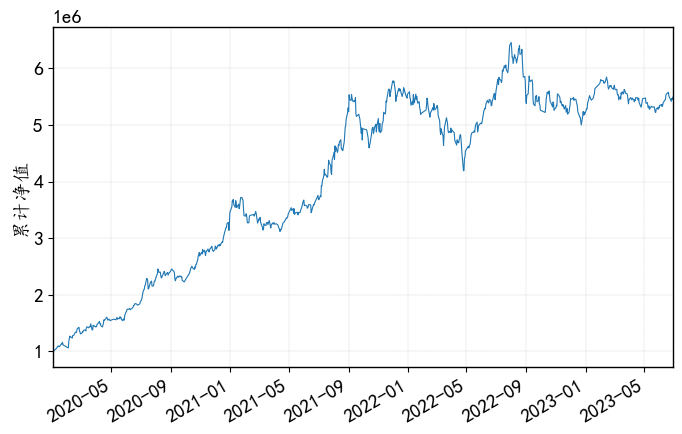

In [18]:
plt, fig, ax = post.matplot()
ax.plot(world0.series_net)
ax.set_ylabel('累计净值')
ax.set_xlim(world0.series_net.index[0], world0.series_net.index[-1])
plt.gcf().autofmt_xdate()